## Weights Calculation
 Weight0: Every Gene weighted equally 
 
 Weight1: Ralitive Risk
 
 Weight2: Number of Hits
 
 Weight3: LofZ

In [296]:
def calc_bias2(X,hw,cw,w_min=1e-6):
    m,W = _calc_W(X,hw,cw)
    W[W <= w_min] = 0

    M = np.dot(W,X)
    V = np.matmul(W,X**2) - \
        2*M*np.matmul(W,X) + \
        M**2
    Z = (X-M)/np.sqrt(V)

    return m,W,Z
def _calc_W(X,hw=1.0,wt=None):
    if wt is None:
        wt = np.repeat(1.,X.shape[1])
    m = np.average(X,axis=1,weights=wt)

    D = (m[np.newaxis,:] - m[:,np.newaxis])**2
    D[np.arange(X.shape[1]),
      np.arange(X.shape[1])] = np.inf
    v = (hw/(2 * np.sqrt(2*np.log(2))))**2

    W = np.exp(-D/(2*v))
    W = W / W.sum(axis=1)[:,np.newaxis]
    return m,W

# Load Files

In [2]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
ExpMat = pd.read_csv("dat/Jon_data/energy-exp_level.csv", index_col="ROW")
ExpMat2, ExpZscoreMat2, ExpMatNorm2, ExpZscoreMatNorm2 = LoadExpressionMatrices(
                        ExpMat = "../dat/allen-mouse-exp/new-energy-conn-model.csv", 
                        ExpZscoreMat = "../dat/allen-mouse-exp/new-energy-conn-zscore.csv",
                        ExpMatNorm = "../dat/allen-mouse-exp/energy-neuronorm.csv",
                        ExpZscoreMatNorm = "../dat/allen-mouse-exp/energy-zscore-neuronorm.csv")
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene")

/Users/jiayao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (38,45) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
ExpZscoreMat.loc[9739, :]

Anterior_amygdalar_area                                            -0.190700
Anterior_cingulate_area_dorsal_part                                 0.188928
Anterior_cingulate_area_ventral_part                               -0.171079
Nucleus_accumbens                                                  -0.483313
Anterodorsal_nucleus                                               -0.228023
                                                                      ...   
Ventral_posterolateral_nucleus_of_the_thalamus                     -0.518010
Ventral_posteromedial_nucleus_of_the_thalamus                       0.060891
Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part    0.223231
Ventral_tegmental_area                                              0.581651
Hypoglossal_nucleus                                                -0.750232
Name: 9739, Length: 213, dtype: float64

# Aggregated Mutations

In [43]:
Aggregate = pd.read_csv("../dat/genes/asd/DenovoWEST_TADA.txt", delimiter="\t")
Aggregate['pDenovoWEST'] = pd.to_numeric(Aggregate["pDenovoWEST"], errors='coerce')
Agg_gene2None, Agg_gene2MutN = Aggregate_Gene_Weights(Aggregate, out = "dat/bias2/meta.gene.weights.csv")
Agg_match_df = pd.read_csv("dat/matching/asd_agg_exp_matches_1000.new.csv", index_col="GENE")
print(len(Agg_gene2MutN))

0.02
(101, 38)
101


## Missing Values as Zeros (Not Correct)

#### All Genes

In [3]:
Agg_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN,
                                              csv_fil = "dat/bias2/Agg.AvgZ.Mutcount.bias.csv")
RD_Agg_avgZ_RD = RegionDistributions(Agg_avgZ_Mutcount.set_index("STR"), show=True)

41
Isocortex 	 22 	 Prelimbic_area; Orbital_area_lateral_part; Dorsal_auditory_area; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_visual_area; Primary_somatosensory_area_lower_limb; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Agranular_insular_area_posterior_part; Retrosplenial_area_lateral_agranular_part; Visceral_area; Secondary_motor_area; Orbital_area_medial_part; Primary_motor_area; Lateral_visual_area; Posterolateral_visual_area; Agranular_insular_area_ventral_part; Gustatory_areas; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Anterior_cingulate_area_ventral_part
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum
Cortical_subplate 	 5 	 Lateral_amygdalar_nucleus; Claustrum; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part; Endopiriform_nucleus_ventral_part
Midbrain 	 1 	 Anterior_pretectal_nucleus
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA3; Field_CA1; Field_CA2
O

In [39]:
1000 / 16000

0.0625

(211, 38)
37


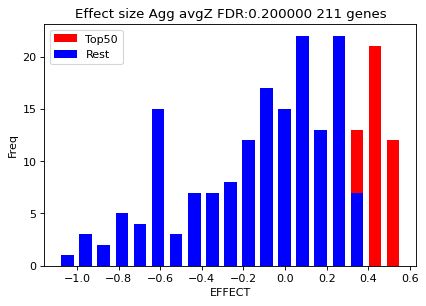

(148, 38)
44


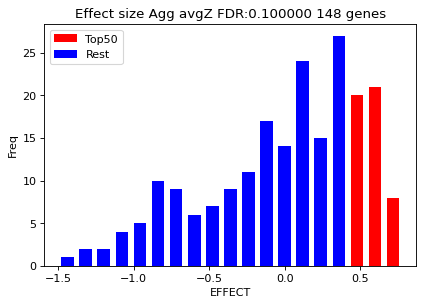

(118, 38)
45


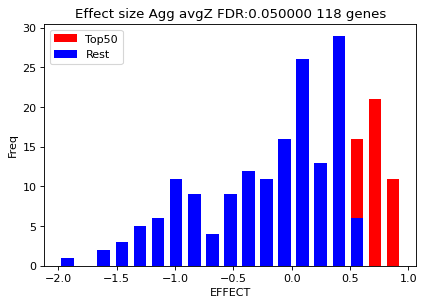

(83, 38)
34


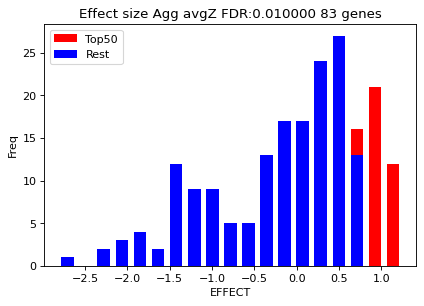

(71, 38)
50


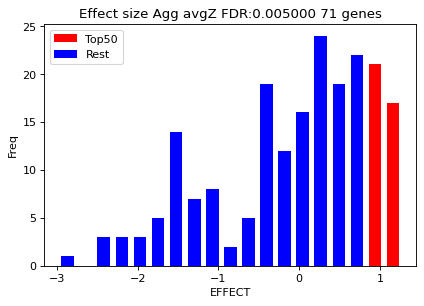

(57, 38)
48


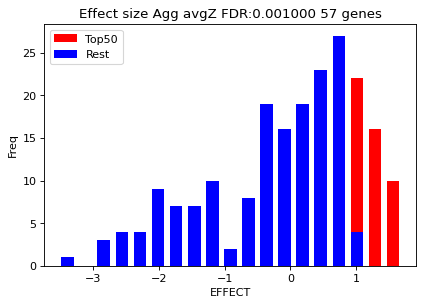

In [22]:
for FDR in [0.2, 0.1, 0.05, 0.01, 0.005, 0.001]:
    Agg_gene2None, Agg_gene2MutN = Aggregate_Gene_Weights(Aggregate, FDR=FDR)
    N_gene = len(Agg_gene2MutN)
    Agg_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN)
    PlotEffectDist(Agg_avgZ_Mutcount, title="Effect size Agg avgZ FDR:%f %d genes"%(FDR, N_gene))

In [5]:
Agg_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat2, Agg_gene2MutN, Agg_match_df,
                                              csv_fil = "dat/bias2/Agg.ExpL.Mutcount.bias.csv")
RD_Agg_expl_RD = RegionDistributions(Agg_explevel_Mutcount.set_index("STR"), show=True)

7
Isocortex 	 29 	 Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Prelimbic_area; Primary_visual_area; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Infralimbic_area; Lateral_visual_area; Primary_somatosensory_area_lower_limb; Visceral_area; Anterior_cingulate_area_dorsal_part; Dorsal_auditory_area; Posterolateral_visual_area; Agranular_insular_area_posterior_part; Secondary_motor_area; Orbital_area_medial_part; Posterior_parietal_association_areas; Anterolateral_visual_area; Primary_motor_area; Primary_somatosensory_area_trunk; posteromedial_visual_area; Supplemental_somatosensory_area; Gustatory_areas; Primary_somatosensory_area_barrel_field; Anterior_cingulate_area_ventral_part; Frontal_pole_cerebral_cortex; Retrosplenial_area_dorsal_part; Agranular_insular_area_ventral_part; Ventral_auditory_area
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum
Cortical_subplate 	 4 	 Claustrum; Lateral_amygdalar_nucleus; E

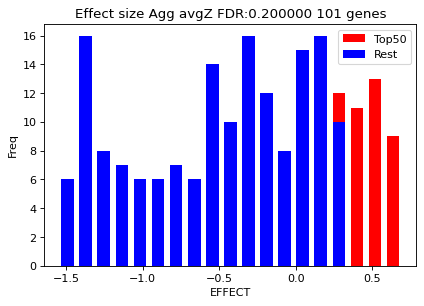

In [24]:
PlotEffectDist(Agg_explevel_Mutcount, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

#### ASDp vs NDD Genes

In [15]:
Aggregate_candidates = Aggregate_top_Genes(Aggregate)
ASD_NDD_Classfiy = pd.read_csv("./dat/ASC_SPARK_NDD_split.csv")
ASDp_genes = ASD_NDD_Classfiy[ASD_NDD_Classfiy["AggClass"]=="ASD_p"]["gene"].values
ASD_NDD_genes = ASD_NDD_Classfiy[ASD_NDD_Classfiy["AggClass"]=="ASD_NDD"]["gene"].values
print(len(ASDp_genes), len(ASD_NDD_genes))
Agg_asdp = Aggregate_candidates[Aggregate_candidates["HGNC"].isin(ASDp_genes)]
Agg_asdndd = Aggregate_candidates[Aggregate_candidates["HGNC"].isin(ASD_NDD_genes)]
Agg_gene2None, Agg_asdp_gene2MutN = Aggregate_Gene_Weights(Agg_asdp)
Agg_gene2None, Agg_asdndd_gene2MutN = Aggregate_Gene_Weights(Agg_asdndd)
print(len(Agg_asdp_gene2MutN), len(Agg_asdndd_gene2MutN))

182 148
0.02
(42, 38)
0.02
(58, 38)
42 58


40
38


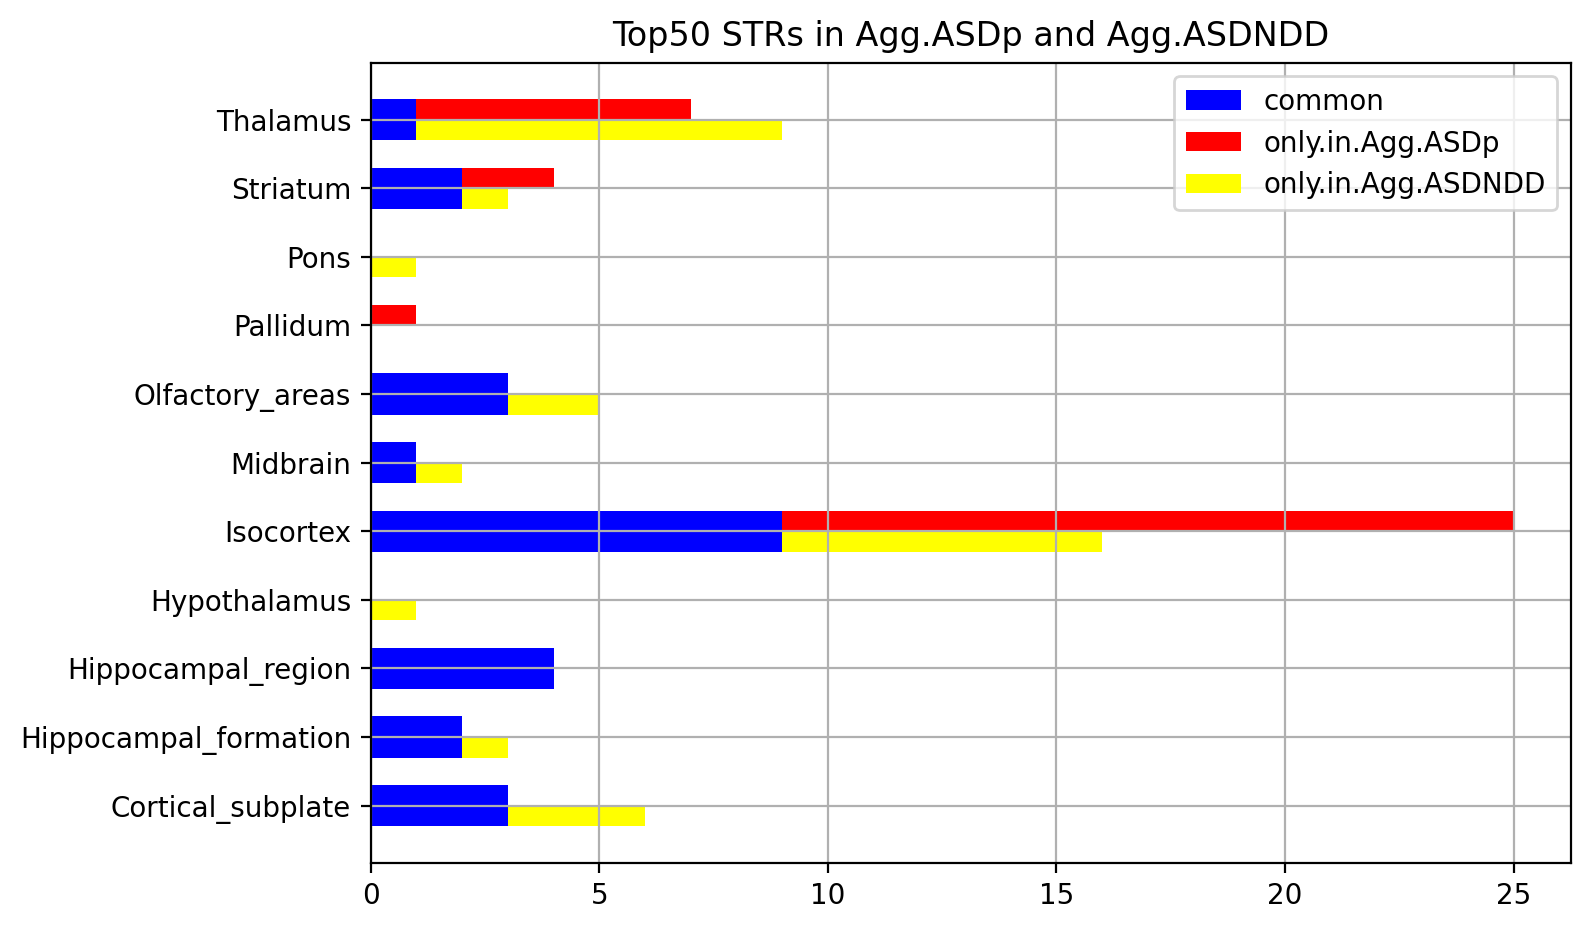

In [18]:
Agg_asdp_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_asdp_gene2MutN,
                                              csv_fil = "dat/bias2/Agg.asdp.AvgZ.Mutcount.bias.csv")
Agg_asdndd_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_asdndd_gene2MutN,
                                              csv_fil = "dat/bias2/Agg.asdndd.AvgZ.Mutcount.bias.csv")
Agg_ASDNDD_BRS_compare = CompareSTROverlap(Agg_asdp_avgZ_Mutcount, Agg_asdndd_avgZ_Mutcount, "Agg.ASDp", "Agg.ASDNDD")
Agg_ASDNDD_BRS_compare.to_csv("dat/bias2/Agg_ASDNDD_BRS_STR_Overlap.csv", index=False)

12
6


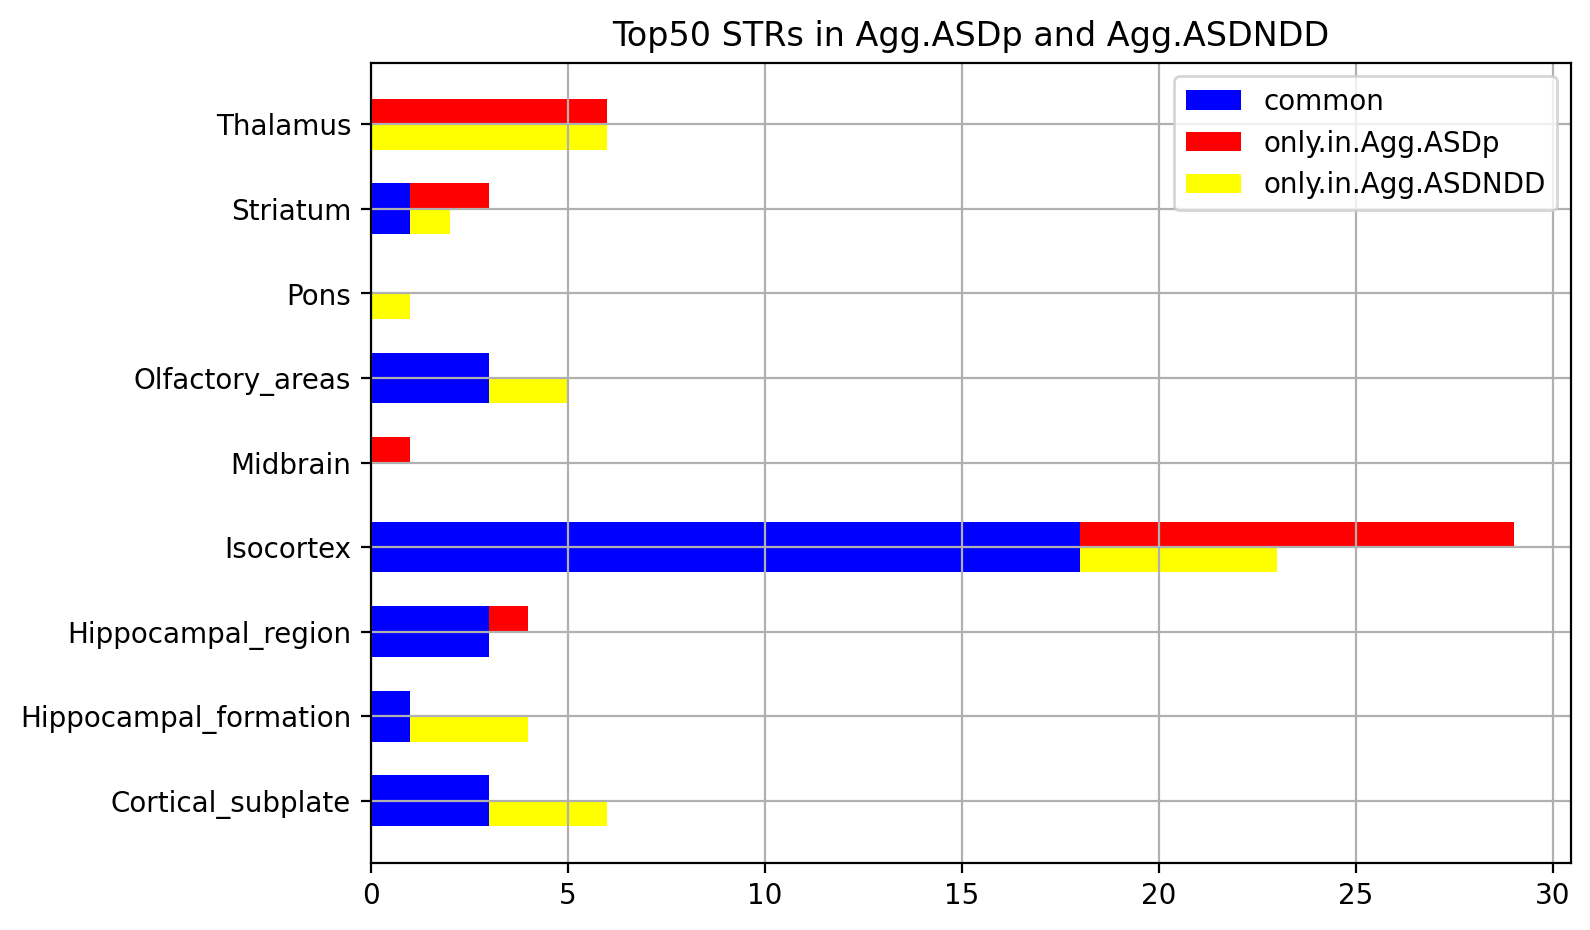

In [19]:
Agg_asdp_expL_Mutcount = ExpAVGWithExpMatch(ExpMat2, Agg_asdp_gene2MutN, Agg_match_df,
                                              csv_fil = "dat/bias2/Agg.asdp.expL.Mutcount.bias.csv")
Agg_asdndd_expL_Mutcount = ExpAVGWithExpMatch(ExpMat2, Agg_asdndd_gene2MutN, Agg_match_df,
                                              csv_fil = "dat/bias2/Agg.asdndd.expL.Mutcount.bias.csv")
Agg_ASDNDD_BRS_compare = CompareSTROverlap(Agg_asdp_expL_Mutcount, Agg_asdndd_expL_Mutcount, "Agg.ASDp", "Agg.ASDNDD")
Agg_ASDNDD_BRS_compare.to_csv("dat/bias2/Agg_ASDNDD_EXP_STR_Overlap.csv", index=False)

In [ ]:
### Compare different 

## MissingValue Dropped

In [80]:
ASD_NDD_Classfiy = pd.read_csv("./dat/ASC_SPARK_NDD_split.csv")
ASDp_genes = ASD_NDD_Classfiy[ASD_NDD_Classfiy["AggClass"]=="ASD_p"]["gene"].values
ASD_NDD_genes = ASD_NDD_Classfiy[ASD_NDD_Classfiy["AggClass"]=="ASD_NDD"]["gene"].values
Agg_asdp = Aggregate[Aggregate["HGNC"].isin(ASDp_genes)]
Agg_asdndd = Aggregate[Aggregate["HGNC"].isin(ASD_NDD_genes)]
Agg_gene2None, Agg_asdp_gene2MutN = Aggregate_Gene_Weights(Agg_asdp, FDR=0.1)
Agg_gene2None, Agg_asdndd_gene2MutN = Aggregate_Gene_Weights(Agg_asdndd, FDR=0.1)

Agg_match_df0 = pd.read_csv("dat/matching/asd_agg_exp_matches_1000.csv", index_col="GENE")
Agg_match_df = pd.read_csv("dat/matching/asd_agg_exp_matches_1000.new1.csv", index_col="GENE")
Agg_match_df2 = pd.read_csv("dat/matching/asd_agg_exp_matches_1000.new2.csv", index_col="GENE")

In [12]:
#WriteGeneList(Aggregate[Aggregate["Qvalue"]<0.2]["EntrezID"].values, "../dat/genes/asd/agg.FDR0.2.txt")
#WriteGeneList(Aggregate[Aggregate["pDenovoWEST"]<1e-3]["EntrezID"].values, "../dat/genes/asd/agg.pD1e-3.txt")

In [63]:
Agg_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, Agg_gene2MutN,
                                              csv_fil = "dat/bias/Agg.AvgZ.Mutcount.bias.csv")
RD_Agg_avgZ_RD = RegionDistributions(Agg_avgZ_Mutcount.set_index("STR"), show=True)

Isocortex 	 21 	 Prelimbic_area; Primary_motor_area; Primary_somatosensory_area_lower_limb; Primary_visual_area; Secondary_motor_area; Orbital_area_lateral_part; Gustatory_areas; Anterior_cingulate_area_dorsal_part; Agranular_insular_area_ventral_part; Infralimbic_area; Anteromedial_visual_area; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Retrosplenial_area_lateral_agranular_part; Orbital_area_ventrolateral_part; Primary_somatosensory_area_upper_limb; Lateral_visual_area; Primary_somatosensory_area_barrel_field; Anterior_cingulate_area_ventral_part; posteromedial_visual_area; Visceral_area
Hippocampal_formation 	 4 	 Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum; Presubiculum
Cortical_subplate 	 6 	 Endopiriform_nucleus_dorsal_part; Claustrum; Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_ventral_part; Basolateral_amygdalar_nucleus
Midbrain 	 2 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract
Hippocampal

In [104]:
Agg_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, Agg_gene2MutN, ConnFil="../dat/allen-mouse-conn/jw-conn-al1.csv",
                                              csv_fil = "dat/bias/Agg.AvgZ.Mutcount.bias.conn2.csv")
RD_Agg_avgZ_RD = RegionDistributions(Agg_avgZ_Mutcount.set_index("STR"), show=True)

Isocortex 	 21 	 Prelimbic_area; Primary_motor_area; Primary_somatosensory_area_lower_limb; Primary_visual_area; Secondary_motor_area; Orbital_area_lateral_part; Gustatory_areas; Anterior_cingulate_area_dorsal_part; Agranular_insular_area_ventral_part; Infralimbic_area; Anteromedial_visual_area; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Retrosplenial_area_lateral_agranular_part; Orbital_area_ventrolateral_part; Primary_somatosensory_area_upper_limb; Lateral_visual_area; Primary_somatosensory_area_barrel_field; Anterior_cingulate_area_ventral_part; posteromedial_visual_area; Visceral_area
Hippocampal_formation 	 4 	 Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum; Presubiculum
Cortical_subplate 	 6 	 Endopiriform_nucleus_dorsal_part; Claustrum; Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_ventral_part; Basolateral_amygdalar_nucleus
Midbrain 	 2 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract
Hippocampal

In [106]:
Agg_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, Agg_gene2MutN, ConnFil="../dat/allen-mouse-conn/jw-conn-al0.csv",
                                              csv_fil = "dat/bias/Agg.AvgZ.Mutcount.bias.conn1.csv")
RD_Agg_avgZ_RD = RegionDistributions(Agg_avgZ_Mutcount.set_index("STR"), show=True)

Isocortex 	 21 	 Prelimbic_area; Primary_motor_area; Primary_somatosensory_area_lower_limb; Primary_visual_area; Secondary_motor_area; Orbital_area_lateral_part; Gustatory_areas; Anterior_cingulate_area_dorsal_part; Agranular_insular_area_ventral_part; Infralimbic_area; Anteromedial_visual_area; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Retrosplenial_area_lateral_agranular_part; Orbital_area_ventrolateral_part; Primary_somatosensory_area_upper_limb; Lateral_visual_area; Primary_somatosensory_area_barrel_field; Anterior_cingulate_area_ventral_part; posteromedial_visual_area; Visceral_area
Hippocampal_formation 	 4 	 Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum; Presubiculum
Cortical_subplate 	 6 	 Endopiriform_nucleus_dorsal_part; Claustrum; Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_ventral_part; Basolateral_amygdalar_nucleus
Midbrain 	 2 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract
Hippocampal

In [81]:
Agg_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, Agg_gene2MutN, Agg_match_df0,
                                              csv_fil = "dat/bias/0.Agg.explevel.Mutcount.bias.csv")
RD_Agg_expl_RD = RegionDistributions(Agg_explevel_Mutcount.set_index("STR"), show=True)

6
Isocortex 	 28 	 Orbital_area_ventrolateral_part; Orbital_area_lateral_part; Prelimbic_area; Primary_visual_area; Infralimbic_area; Lateral_visual_area; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Orbital_area_medial_part; Secondary_motor_area; Visceral_area; Anterolateral_visual_area; Primary_motor_area; Posterolateral_visual_area; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; posteromedial_visual_area; Gustatory_areas; Primary_somatosensory_area_barrel_field; Supplemental_somatosensory_area; Frontal_pole_cerebral_cortex; Agranular_insular_area_posterior_part; Retrosplenial_area_dorsal_part; Anterior_cingulate_area_ventral_part; Agranular_insular_area_ventral_part; Primary_somatosensory_area_upper_limb
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum
Cortical_subplate 	 5 	 Claustrum; Lateral_amygdalar_nucleus; Endopir

In [109]:
Agg_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, Agg_gene2MutN, Agg_match_df,
                                              csv_fil = "dat/bias/Agg.explevel.Mutcount.bias.csv")
RD_Agg_expl_RD = RegionDistributions(Agg_explevel_Mutcount.set_index("STR"), show=True)

Isocortex 	 28 	 Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Prelimbic_area; Primary_visual_area; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Infralimbic_area; Lateral_visual_area; Primary_somatosensory_area_lower_limb; Anterior_cingulate_area_dorsal_part; Visceral_area; Posterolateral_visual_area; Secondary_motor_area; Orbital_area_medial_part; Primary_motor_area; Posterior_parietal_association_areas; Anterolateral_visual_area; Primary_somatosensory_area_trunk; posteromedial_visual_area; Supplemental_somatosensory_area; Agranular_insular_area_posterior_part; Gustatory_areas; Primary_somatosensory_area_barrel_field; Agranular_insular_area_ventral_part; Anterior_cingulate_area_ventral_part; Retrosplenial_area_dorsal_part; Frontal_pole_cerebral_cortex; Primary_somatosensory_area_upper_limb
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Parasubiculum; Subiculum_dorsal_part
Cortical_subplate 	 6 	 Claustrum; Lateral_amygdalar_nucleus; Endopirif

In [110]:
Agg_explevel_Mutcount2 = ExpAVGWithExpMatch(ExpMat, Agg_gene2MutN, Agg_match_df2,
                                              csv_fil = "dat/bias/Agg.explevel2.Mutcount.bias.csv")
RD_Agg_expl_RD = RegionDistributions(Agg_explevel_Mutcount.set_index("STR"), show=True)

Isocortex 	 28 	 Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Prelimbic_area; Primary_visual_area; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Infralimbic_area; Lateral_visual_area; Primary_somatosensory_area_lower_limb; Anterior_cingulate_area_dorsal_part; Visceral_area; Posterolateral_visual_area; Secondary_motor_area; Orbital_area_medial_part; Primary_motor_area; Posterior_parietal_association_areas; Anterolateral_visual_area; Primary_somatosensory_area_trunk; posteromedial_visual_area; Supplemental_somatosensory_area; Agranular_insular_area_posterior_part; Gustatory_areas; Primary_somatosensory_area_barrel_field; Agranular_insular_area_ventral_part; Anterior_cingulate_area_ventral_part; Retrosplenial_area_dorsal_part; Frontal_pole_cerebral_cortex; Primary_somatosensory_area_upper_limb
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Parasubiculum; Subiculum_dorsal_part
Cortical_subplate 	 6 	 Claustrum; Lateral_amygdalar_nucleus; Endopirif

0.9996765789592329 0.0


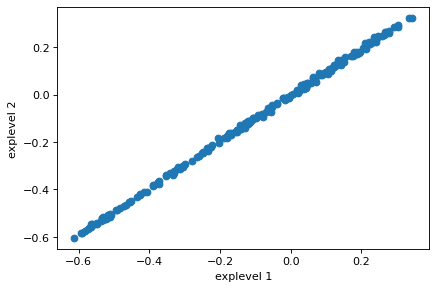

In [111]:
X, Y = [], []
for _str in Agg_explevel_Mutcount.index:
    X.append(Agg_explevel_Mutcount.loc[_str, "EFFECT"])
    Y.append(Agg_explevel_Mutcount2.loc[_str, "EFFECT"])
r, p = pearsonr(X, Y)
print(r, p)
plt.scatter(X, Y)
plt.xlabel("explevel 1")
plt.ylabel("explevel 2")
plt.show()

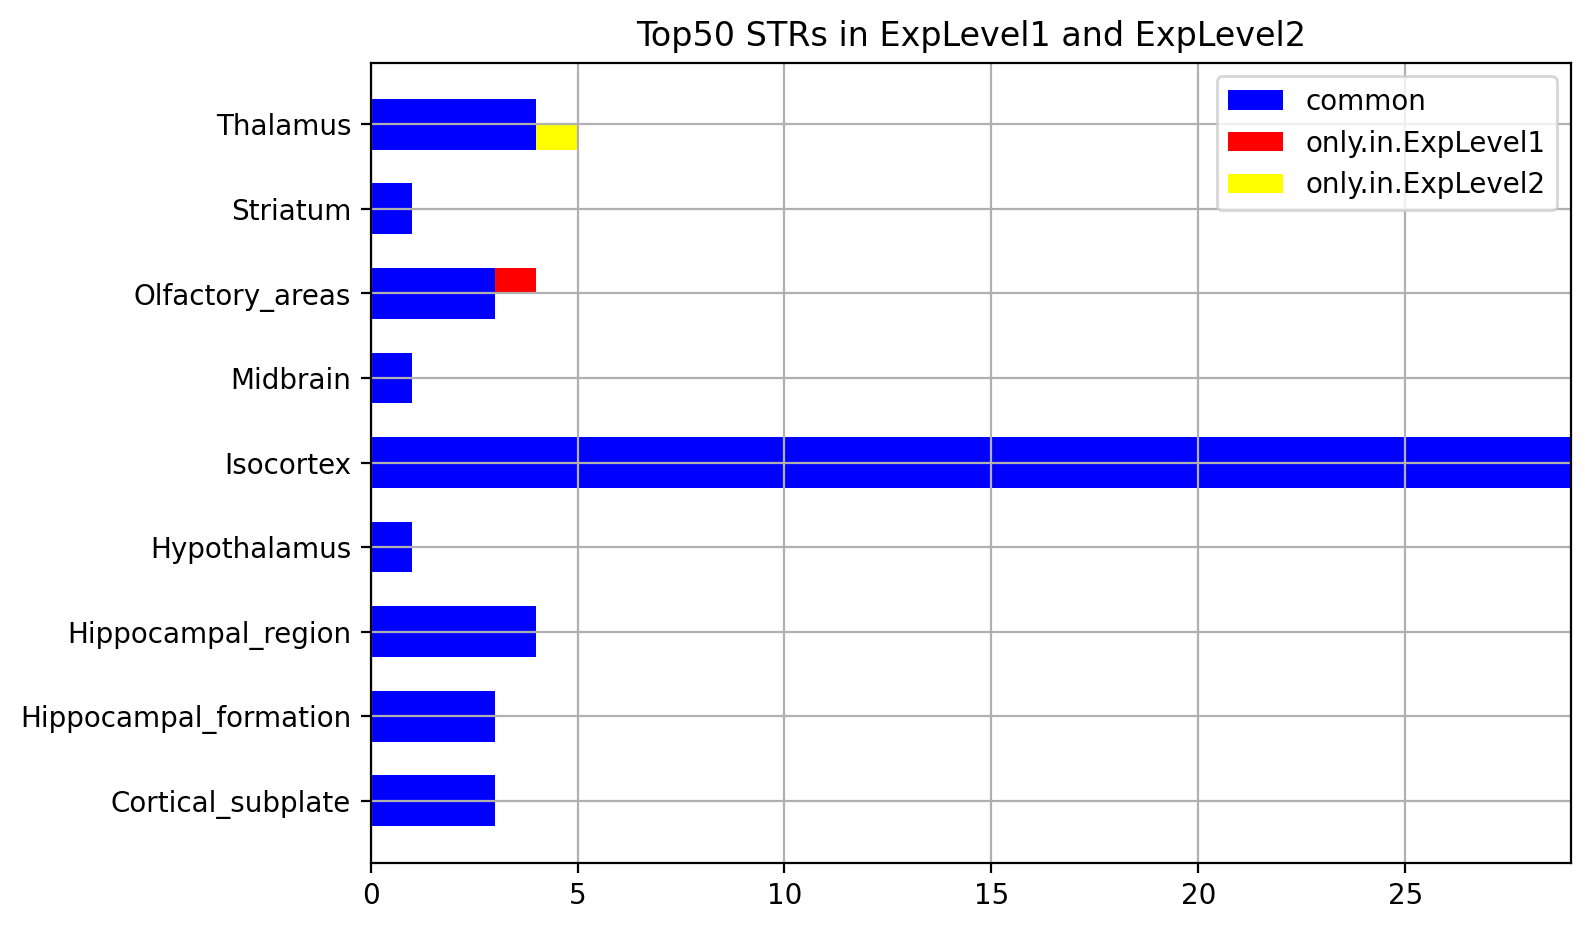

In [101]:
Agg_ASDNDD_BRS_compare = CompareSTROverlap(Agg_explevel_Mutcount, Agg_explevel_Mutcount2, "ExpLevel1", "ExpLevel2")

So there's no big difference between different run of gene matches.

In [92]:
Agg_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, Agg_gene2MutN, Agg_match_df,
                                              csv_fil = "dat/bias/Agg.explevel.Mutcount.bias.csv")
RD_Agg_expl_RD = RegionDistributions(Agg_explevel_Mutcount.set_index("STR"), show=True)

6
Isocortex 	 29 	 Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Prelimbic_area; Primary_visual_area; Lateral_visual_area; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Infralimbic_area; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Visceral_area; Anterolateral_visual_area; Secondary_motor_area; Orbital_area_medial_part; Posterolateral_visual_area; Primary_somatosensory_area_trunk; Primary_motor_area; Supplemental_somatosensory_area; Posterior_parietal_association_areas; Primary_somatosensory_area_barrel_field; posteromedial_visual_area; Gustatory_areas; Agranular_insular_area_posterior_part; Primary_somatosensory_area_upper_limb; Retrosplenial_area_dorsal_part; Frontal_pole_cerebral_cortex; Anterior_cingulate_area_ventral_part; Agranular_insular_area_ventral_part; Primary_somatosensory_area_nose
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Parasubiculum; Subiculum_dorsal_part
Cortical_subplate 	 3 	 Lateral_amyg

35
43


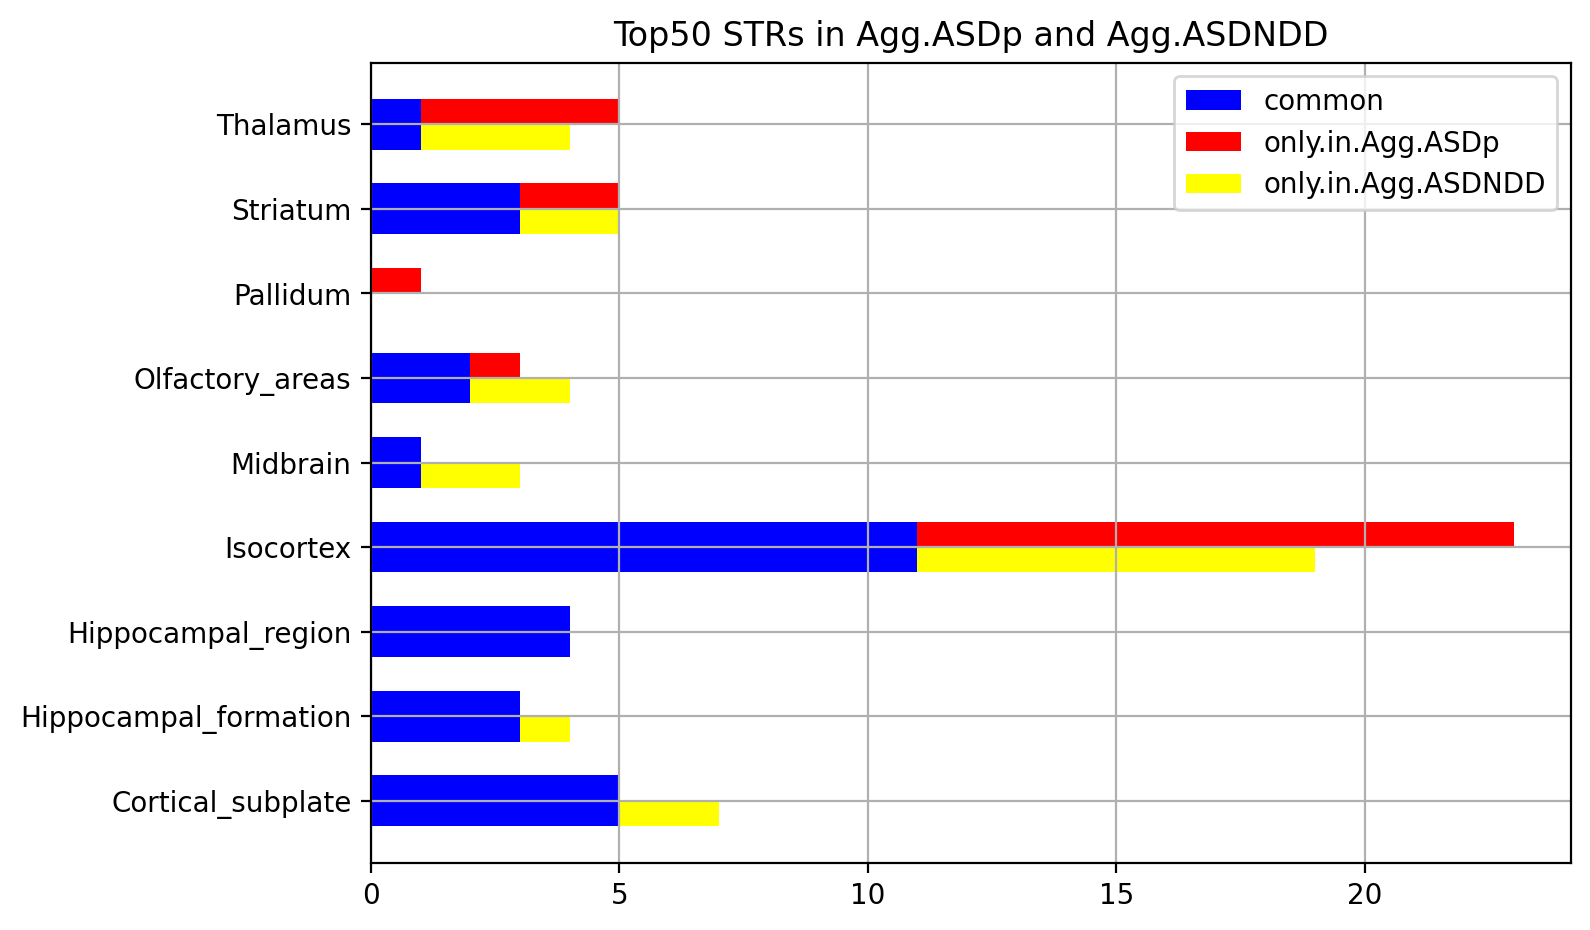

In [15]:
Agg_asdp_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, Agg_asdp_gene2MutN,
                                              csv_fil = "dat/bias/Agg.asdp.AvgZ.Mutcount.bias.csv")
Agg_asdndd_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, Agg_asdndd_gene2MutN,
                                              csv_fil = "dat/bias/Agg.asdndd.AvgZ.Mutcount.bias.csv")
Agg_ASDNDD_BRS_compare = CompareSTROverlap(Agg_asdp_avgZ_Mutcount, Agg_asdndd_avgZ_Mutcount, "Agg.ASDp", "Agg.ASDNDD")
Agg_ASDNDD_BRS_compare.to_csv("dat/Agg_ASDNDD_BRS_STR_Overlap.csv", index=False)

11
13


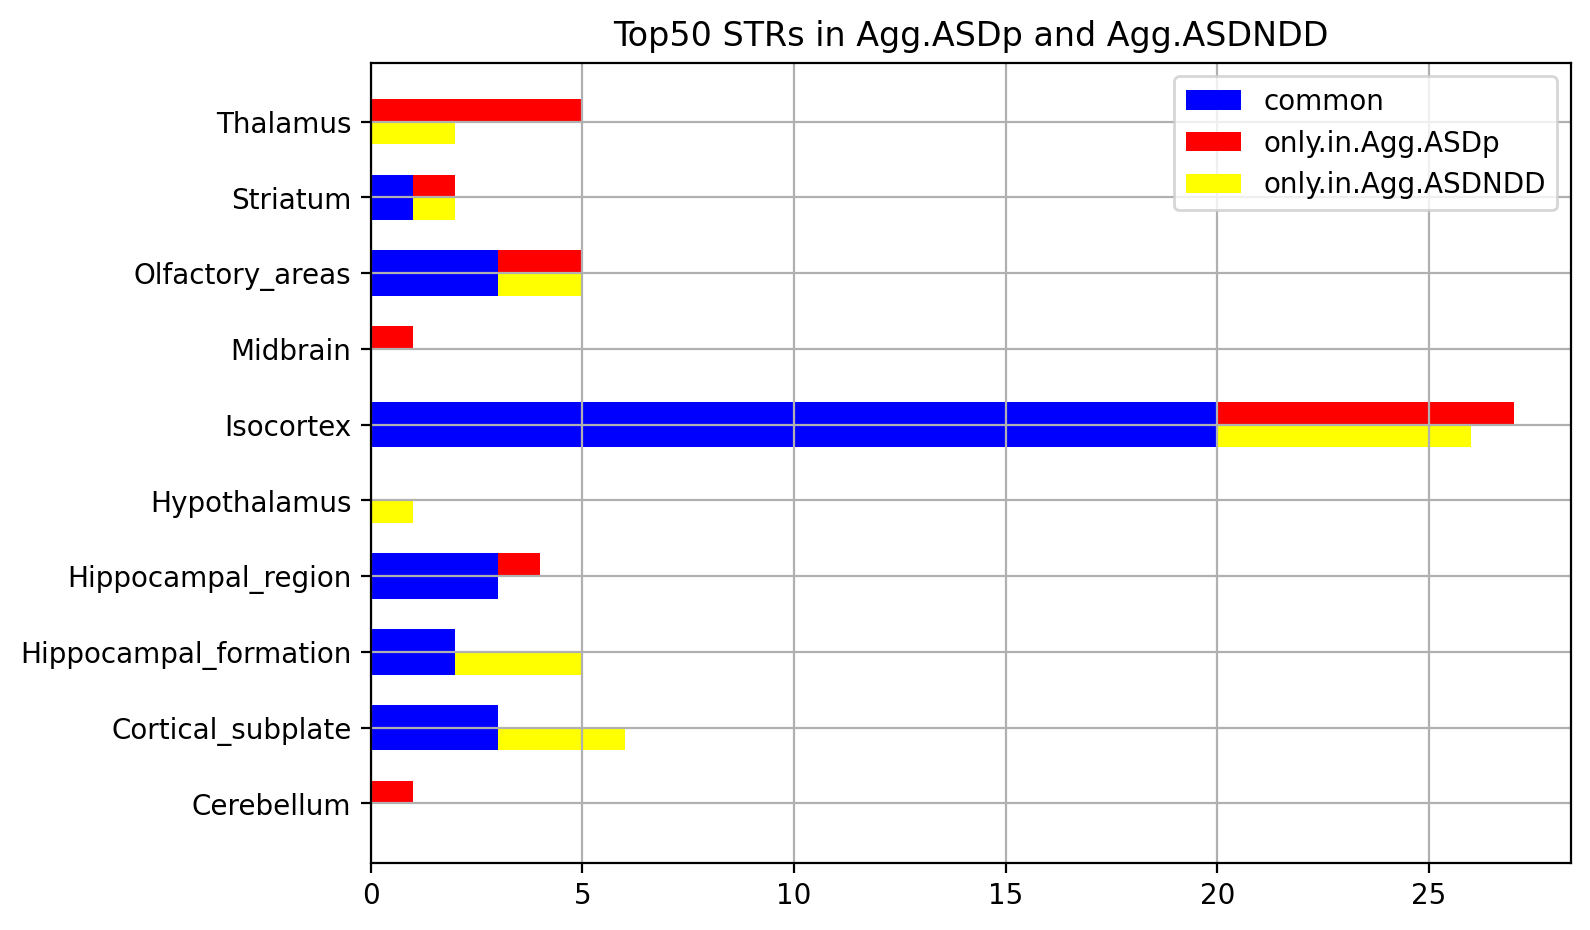

In [16]:
Agg_asdp_expL_Mutcount = ExpAVGWithExpMatch(ExpMat, Agg_asdp_gene2MutN, agg_match_df,
                                              csv_fil = "dat/bias/Agg.asdp.expL.Mutcount.bias.csv")
Agg_asdndd_expL_Mutcount = ExpAVGWithExpMatch(ExpMat, Agg_asdndd_gene2MutN, agg_match_df,
                                              csv_fil = "dat/bias/Agg.asdndd.expL.Mutcount.bias.csv")
Agg_ASDNDD_BRS_compare = CompareSTROverlap(Agg_asdp_expL_Mutcount, Agg_asdndd_expL_Mutcount, "Agg.ASDp", "Agg.ASDNDD")
Agg_ASDNDD_BRS_compare.to_csv("dat/Agg_ASDNDD_EXP_STR_Overlap.csv", index=False)

In [11]:
Selected_Thalamic_STRs = ["Lateral_posterior_nucleus_of_the_thalamus", "Parafascicular_nucleus",
                          "Mediodorsal_nucleus_of_thalamus", "Rhomboid_nucleus", "Nucleus_of_reuniens"]
Agg_avgZ_TR = Agg_avgZ_Mutcount.loc[Selected_Thalamic_STRs, "Rank"]
print("Agg_avgZ_TR\n", Agg_avgZ_TR)

Agg_avgZ_TR
 Lateral_posterior_nucleus_of_the_thalamus    26
Parafascicular_nucleus                       30
Mediodorsal_nucleus_of_thalamus              66
Rhomboid_nucleus                             67
Nucleus_of_reuniens                          39
Name: Rank, dtype: int64


33


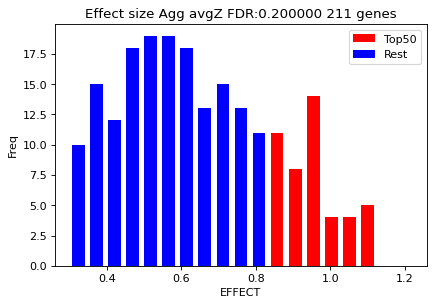

39


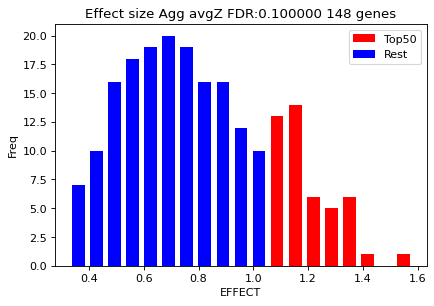

39


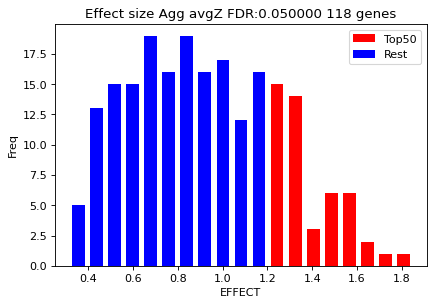

43


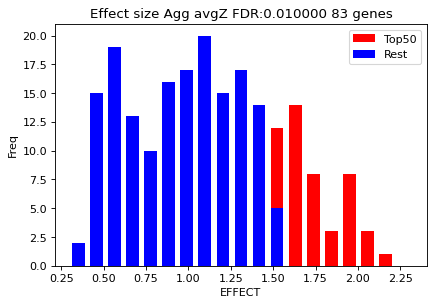

43


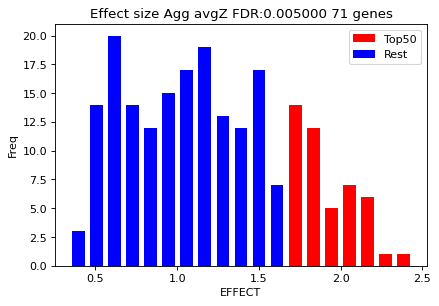

44


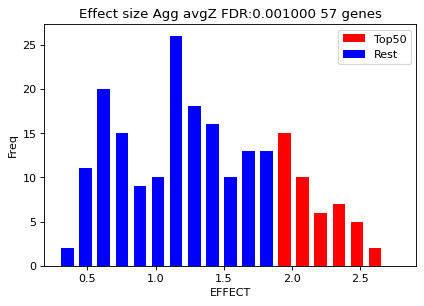

In [426]:
for FDR in [0.2, 0.1, 0.05, 0.01, 0.005, 0.001]:
    Agg_gene2None, Agg_gene2MutN = Aggregate_Gene_Weights(Aggregate, FDR=FDR)
    N_gene = len(Agg_gene2MutN)
    Agg_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, Agg_gene2MutN)
    PlotEffectDist(Agg_avgZ_Mutcount, title="Effect size Agg avgZ FDR:%f %d genes"%(FDR, N_gene))
    

In [427]:
Agg_avgZ_Mutcount.tail(50)

,STR,EFFECT,REGION,Rank,InCircuit,TrimRank
Pontine_reticular_nucleus,Pontine_reticular_nucleus,0.839862,Pons,164,0,1
Globus_pallidus_external_segment,Globus_pallidus_external_segment,0.825915,Pallidum,165,0,1
Spinal_vestibular_nucleus,Spinal_vestibular_nucleus,0.806970,Medulla,166,0,1
Arcuate_hypothalamic_nucleus,Arcuate_hypothalamic_nucleus,0.805409,Hypothalamus,167,0,1
Midbrain_reticular_nucleus_retrorubral_area,Midbrain_reticular_nucleus_retrorubral_area,0.773879,Midbrain,168,0,1
Lateral_vestibular_nucleus,Lateral_vestibular_nucleus,0.773164,Medulla,169,0,1
Intermediate_reticular_nucleus,Intermediate_reticular_nucleus,0.769661,Medulla,170,0,1
Interposed_nucleus,Interposed_nucleus,0.762817,Cerebellum,171,0,1
Anteroventral_nucleus_of_thalamus,Anteroventral_nucleus_of_thalamus,0.761678,Thalamus,172,0,1
Parvicellular_reticular_nucleus,Parvicellular_reticular_nucleus,0.755887,Medulla,173,0,1


In [358]:
Agg_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, Agg_gene2MutN,
                                              csv_fil = "dat/bias/Agg.AvgZ.Mutcount.bias.csv")
RD_Agg_avgZ_RD = RegionDistributions(Agg_avgZ_Mutcount.set_index("STR"), show=True)

39
Midbrain 	 2 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract
Olfactory_areas 	 4 	 Piriform_area; Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area
Thalamus 	 4 	 Lateral_posterior_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Mediodorsal_nucleus_of_thalamus; Parafascicular_nucleus
Hippocampal_formation 	 3 	 Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum
Striatum 	 3 	 Nucleus_accumbens; Caudoputamen; Intercalated_amygdalar_nucleus
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA3; Field_CA2
Isocortex 	 24 	 Primary_motor_area; Prelimbic_area; Primary_visual_area; Secondary_motor_area; Primary_somatosensory_area_lower_limb; Posterior_parietal_association_areas; Primary_somatosensory_area_barrel_field; Anterior_cingulate_area_dorsal_part; Frontal_pole_cerebral_cortex; Gustatory_areas; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_somatosensory_area_trunk; Primary_somatosensory_

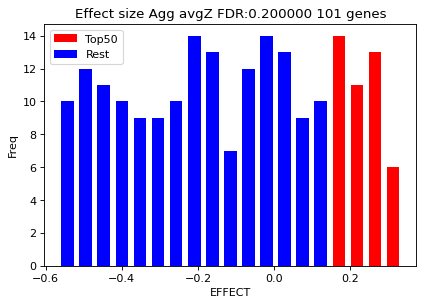

In [47]:
PlotEffectDist(agg_explevel_Mutcount, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

In [87]:
jon_explevel = pd.read_excel("dat/bias/dat.xlsx", sheet_name="meta.exp_lev", index_col="struc")
jon_explevel.columns = ["EFFECT", "rank", 'n.gene', "Region"]
jon_explevel.head(2)

,EFFECT,rank,n.gene,Region
struc,,,,
Orbital_area_lateral_part,0.374820,1,95,Isocortex
Orbital_area_ventrolateral_part,0.365346,2,95,Isocortex


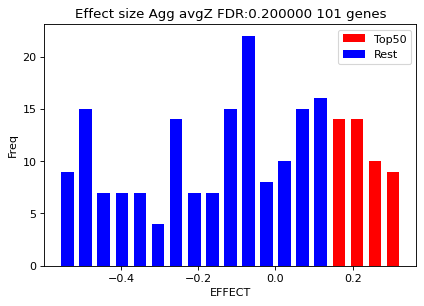

In [88]:
PlotEffectDist(jon_explevel, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

In [89]:
agg_explevel_Mutcount.head(2)

,STR,EFFECT,Region,Rank,InCircuit,TrimRank
Orbital_area_ventrolateral_part,Orbital_area_ventrolateral_part,0.383292,Isocortex,113,1,26
Orbital_area_lateral_part,Orbital_area_lateral_part,0.373232,Isocortex,111,1,27


0.9837588274884845 2.2466598821607178e-159


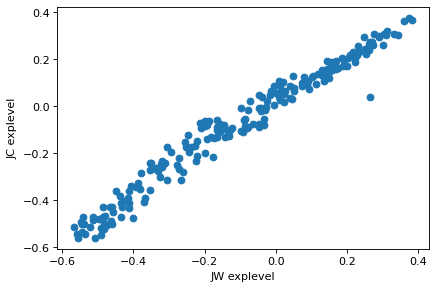

In [91]:
X, Y = [], []
for _str in agg_explevel_Mutcount.index:
    X.append(agg_explevel_Mutcount.loc[_str, "EFFECT"])
    Y.append(jon_explevel.loc[_str, "EFFECT"])
r, p = pearsonr(X, Y)
print(r, p)
plt.scatter(X, Y)
plt.xlabel("JW explevel")
plt.ylabel("JC explevel")
plt.show()

In [83]:
jon_spec = pd.read_excel("dat/bias/dat.xlsx", sheet_name="meta.exp_spec.mean", index_col="struc")
jon_spec.columns = ["EFFECT", "rank", "Region"]
jon_spec.head(2)

,EFFECT,rank,Region
struc,,,
Dentate_gyrus,0.632435,1,Hippocampal_formation
Field_CA1,0.559321,2,Hippocampal_formation


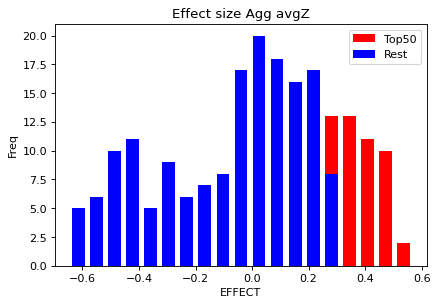

In [84]:
PlotEffectDist(jon_spec, title="Effect size Agg avgZ")

0.9994242124460044 4.9280348571e-312


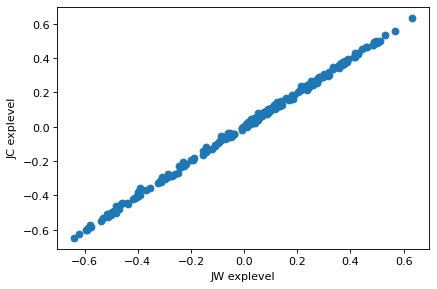

In [85]:
X, Y = [], []
for _str in Agg_avgZ_Mutcount.index:
    X.append(Agg_avgZ_Mutcount.loc[_str, "EFFECT"])
    Y.append(jon_spec.loc[_str, "EFFECT"])
r, p = pearsonr(X, Y)
print(r, p)
plt.scatter(X, Y)
plt.xlabel("JW explevel")
plt.ylabel("JC explevel")
plt.show()

# SSC

In [91]:
ssc_highIQ = pd.read_csv("../dat/genes/asd/ssc_highIQ.csv")
ssc_lowIQ = pd.read_csv("../dat/genes/asd/ssc_LowIQ.csv")
ssc_match_df = pd.read_csv("dat/matching/asd_ssc_exp_matches_1000.csv", index_col="GENE")

ssc_lowIQ_gene2MutN = SSC_Gene_Weights(ssc_lowIQ, gnomad_cons, FDR=0.8)
ssc_highIQ_gene2MutN = SSC_Gene_Weights(ssc_highIQ, gnomad_cons, FDR=0.8)

In [103]:
ssc_hiq_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, ssc_highIQ_gene2MutN, ssc_match_df,
                                              csv_fil = "dat/bias/ssc.highIQ.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(ssc_hiq_explevel_Mutcount.set_index("STR"))

Hippocampal_formation 	 3 	 Subiculum_dorsal_part; Postsubiculum; Parasubiculum
Cortical_subplate 	 1 	 Posterior_amygdalar_nucleus
Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Main_olfactory_bulb; Dorsal_peduncular_area; Taenia_tecta
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA3; Field_CA2; Field_CA1
Thalamus 	 10 	 Lateral_posterior_nucleus_of_the_thalamus; Parataenial_nucleus; Central_lateral_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Parafascicular_nucleus; Anteromedial_nucleus_dorsal_part; Mediodorsal_nucleus_of_thalamus; Lateral_habenula; Dorsal_part_of_the_lateral_geniculate_complex; Nucleus_of_reuniens
Isocortex 	 16 	 Orbital_area_ventrolateral_part; Infralimbic_area; Orbital_area_lateral_part; Frontal_pole_cerebral_cortex; Retrosplenial_area_lateral_agranular_part; Secondary_motor_area; Anteromedial_visual_area; Primary_visual_area; Retrosplenial_area_dorsal_part; Agranular_insular_area_ventral_part; Posterolateral_visual_a

In [104]:
ssc_liq_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, ssc_lowIQ_gene2MutN, ssc_match_df,
                                              csv_fil = "dat/bias/ssc.lowIQ.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(ssc_liq_explevel_Mutcount.set_index("STR"))

Hippocampal_formation 	 4 	 Parasubiculum; Subiculum_ventral_part; Presubiculum; Postsubiculum
Cortical_subplate 	 4 	 Endopiriform_nucleus_dorsal_part; Basomedial_amygdalar_nucleus; Claustrum; Basolateral_amygdalar_nucleus
Olfactory_areas 	 6 	 Anterior_olfactory_nucleus; Accessory_olfactory_bulb; Dorsal_peduncular_area; Piriform_area; Taenia_tecta; Piriform_amygdalar_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA3; Field_CA1
Thalamus 	 2 	 Lateral_posterior_nucleus_of_the_thalamus; Nucleus_of_reuniens
Isocortex 	 26 	 Prelimbic_area; Infralimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Orbital_area_ventrolateral_part; Anterior_cingulate_area_ventral_part; Lateral_visual_area; Retrosplenial_area_lateral_agranular_part; Retrosplenial_area_dorsal_part; Secondary_motor_area; Primary_somatosensory_area_lower_limb; Primary_somatosensory_area_upper_limb; Anteromedial_visual_area; Agranular_insular_area_ventral_part; Temporal_association_areas; 

# ASC

In [26]:
asc_df = pd.read_csv("../dat/genes/asd/asc_tada_RR.csv")
asd_asc_match_df = pd.read_csv("dat/matching/asd_asc_exp_matches_1000.new.csv", index_col="GENE")
asc_gene2MutN = ASC_Gene_Weights(asc_df, gnomad_cons, FDR=0.1)

## Missing Values as Zeros

#### All Genes

In [28]:
asc_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat2, asc_gene2MutN,
                                              csv_fil = "dat/bias2/asc.avgZ.Mutcount.bias.csv")
asc_avgZ_RD = RegionDistributions(asc_avgZ_Mutcount.set_index("STR"), show=True)

31
Isocortex 	 17 	 Prelimbic_area; Dorsal_auditory_area; Infralimbic_area; Orbital_area_lateral_part; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Agranular_insular_area_posterior_part; Anterior_cingulate_area_dorsal_part; Primary_visual_area; Orbital_area_medial_part; Anterior_cingulate_area_ventral_part; Posterior_parietal_association_areas; Visceral_area; Secondary_motor_area; Lateral_visual_area
Hippocampal_formation 	 2 	 Subiculum_dorsal_part; Subiculum_ventral_part
Pons 	 1 	 Superior_central_nucleus_raphe
Cortical_subplate 	 4 	 Lateral_amygdalar_nucleus; Claustrum; Endopiriform_nucleus_dorsal_part; Basomedial_amygdalar_nucleus
Midbrain 	 1 	 Anterior_pretectal_nucleus
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA3; Field_CA1
Olfactory_areas 	 3 	 Anterior_olfactory_nucleus; Accessory_olfactory_bulb; Dorsal_peduncular_area
Pallidum 	 1 	 Bed_nuclei_of_the_stria_termina

In [30]:
asc_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat2, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias2/asc.explevel.Mutcount.bias.csv")
asc_explevel_RD = RegionDistributions(asc_explevel_Mutcount.set_index("STR"), show=True)

14
Isocortex 	 26 	 Prelimbic_area; Orbital_area_lateral_part; Infralimbic_area; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Orbital_area_ventrolateral_part; Dorsal_auditory_area; Primary_visual_area; Primary_somatosensory_area_lower_limb; Anterior_cingulate_area_dorsal_part; Orbital_area_medial_part; Primary_auditory_area; Posterior_parietal_association_areas; Lateral_visual_area; posteromedial_visual_area; Anterior_cingulate_area_ventral_part; Agranular_insular_area_posterior_part; Visceral_area; Ventral_auditory_area; Posterolateral_visual_area; Secondary_motor_area; Anterolateral_visual_area; Retrosplenial_area_dorsal_part; Primary_somatosensory_area_trunk; Primary_motor_area; Frontal_pole_cerebral_cortex
Hippocampal_formation 	 1 	 Subiculum_dorsal_part
Cortical_subplate 	 3 	 Lateral_amygdalar_nucleus; Claustrum; Endopiriform_nucleus_dorsal_part
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Olfactory_areas 	 6 	 Anterior_olfactor

#### ASD/NDD split

In [31]:
ASD_NDD_Classfiy = pd.read_csv("./dat/ASC_SPARK_NDD_split.csv")
ASDp_genes = ASD_NDD_Classfiy[ASD_NDD_Classfiy["ASCClass"]=="ASD_P"]["gene"].values
ASD_NDD_genes = ASD_NDD_Classfiy[ASD_NDD_Classfiy["ASCClass"]=="ASD_NDD"]["gene"].values
asc_asdp = asc_df[asc_df["gene"].isin(ASDp_genes)]
asc_asdndd = asc_df[asc_df["gene"].isin(ASD_NDD_genes)]

In [32]:
asc_asdp_gene2MutN = ASC_Gene_Weights(asc_asdp, gnomad_cons, FDR=0.1)
asc_asdndd_gene2MutN = ASC_Gene_Weights(asc_asdndd, gnomad_cons, FDR=0.1)

In [33]:
asc_asdp_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat2, asc_asdp_gene2MutN,
                                              csv_fil = "dat/bias2/asc.asdp.avgZ.weighted.Mutcount.bias.csv")
asc_asdp_avgZ_RD = RegionDistributions(asc_asdp_avgZ_Mutcount.set_index("STR"))
asc_asdndd_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat2, asc_asdndd_gene2MutN,
                                              csv_fil = "dat/bias2/asc.asdndd.avgZ.weighted.Mutcount.bias.csv")
asc_asdndd_avgZ_RD = RegionDistributions(asc_asdndd_avgZ_Mutcount.set_index("STR"))

12
47


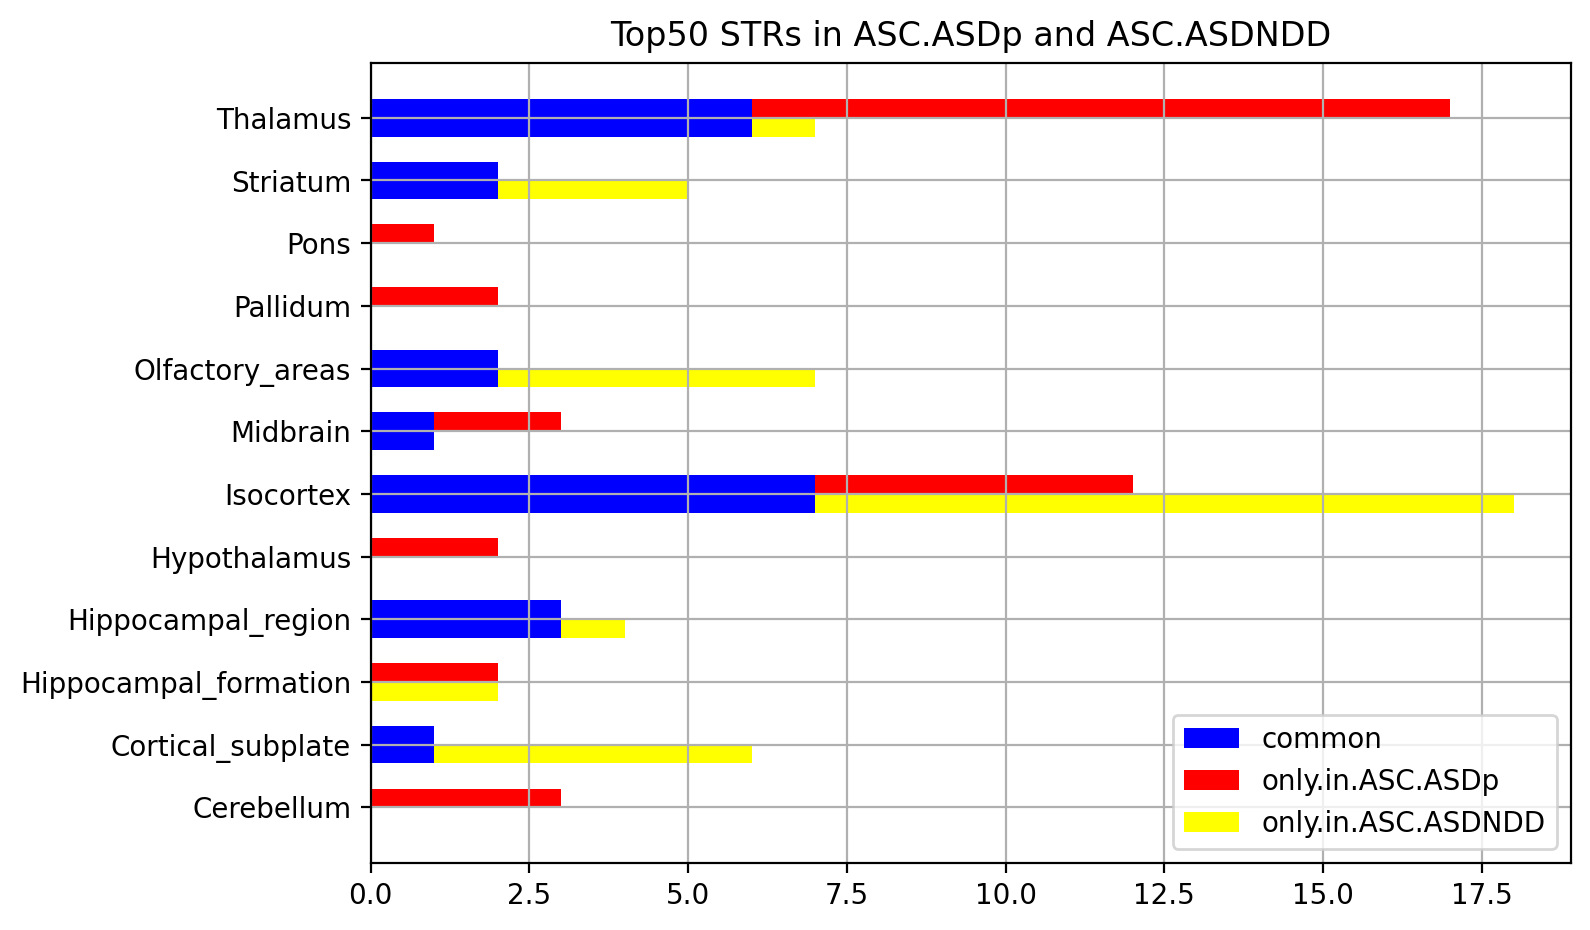

In [34]:
ASC_ASDNDD_BRS_compare = CompareSTROverlap(asc_asdp_avgZ_Mutcount, asc_asdndd_avgZ_Mutcount, "ASC.ASDp", "ASC.ASDNDD")
ASC_ASDNDD_BRS_compare.to_csv("dat/bias2/ASC_ASDNDD_BRS_STR_Overlap.csv", index=False)

In [ ]:
asc_asdp_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, asc_asdp_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias2/asc.asdp.explevel.weighted.Mutcount.bias.csv")
asc_asdp_explevel_RD = RegionDistributions(asc_asdp_explevel_Mutcount.set_index("STR"))


In [ ]:
asc_asdndd_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, asc_asdndd_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias2/asc.asdndd.explevel.weighted.Mutcount.bias.csv")
asc_asdndd_explevel_RD = RegionDistributions(asc_asdndd_explevel_Mutcount.set_index("STR"))

In [ ]:
Agg_ASDNDD_BRS_compare = CompareSTROverlap(Agg_asdp_avgZ_Mutcount, Agg_asdndd_avgZ_Mutcount, "Agg.ASDp", "Agg.ASDNDD")
Agg_ASDNDD_BRS_compare.to_csv("dat/bias2/Agg_ASDNDD_BRS_STR_Overlap.csv", index=False)

In [212]:
ASD_NDD_Classfiy = pd.read_csv("./dat/ASC_SPARK_NDD_split.csv")
ASDp_genes = ASD_NDD_Classfiy[ASD_NDD_Classfiy["ASCClass"]=="ASD_P"]["gene"].values
ASD_NDD_genes = ASD_NDD_Classfiy[ASD_NDD_Classfiy["ASCClass"]=="ASD_NDD"]["gene"].values
asc_asdp = asc_df[asc_df["gene"].isin(ASDp_genes)]
asc_asdndd = asc_df[asc_df["gene"].isin(ASD_NDD_genes)]

#### ASC IQ

In [215]:
asc_highIQ = pd.read_csv("../dat/genes/asd/asc.HighIQ.csv")
asc_lowIQ = pd.read_csv("../dat/genes/asd/asc.LowIQ.csv")
#ssc_match_df = pd.read_csv("dat/matching/asd_ssc_exp_matches_1000.csv", index_col="GENE")

asc_lowIQ_gene2MutN = ASC_Gene_Weights_ByIQ(asc_lowIQ, FDR=0.2)
asc_highIQ_gene2MutN = ASC_Gene_Weights_ByIQ(asc_highIQ, FDR=0.2)

In [291]:
genes, weights = [], []
out = csv.writer(open("asc.gene.weights.csv", 'wt'))
out.writerow(["gene", "weight"])
for k, v in asc_gene2MutN.items():
    #print(k,v)
    genes.append(k)
    weights.append(v)
    out.writerow([k, v])

In [293]:
genes, weights = [], []
out = csv.writer(open("spark.gene.weights.csv", 'wt'))
out.writerow(["gene", "weight"])
for k, v in spark_gene2MutN.items():
    print(k,v)
    genes.append(k)
    weights.append(v)
    out.writerow([k, v])

23394 4.552
6326 4.827999999999999
85358 3.705
57680 3.3579999999999997
10765 2.899
27086 2.1229999999999998
4204 2.052
5728 2.011
8831 2.1229999999999998
80816 2.082
1106 2.1639999999999997
51111 1.7349999999999999
8452 1.7349999999999999
23126 1.7349999999999999
9024 1.5819999999999999
57492 1.817
64599 1.7349999999999999
55870 2.082
57551 1.623
6812 1.4289999999999998
7248 1.4289999999999998
6601 1.388
9969 1.5819999999999999
10492 1.041
51317 1.041
1778 2.1639999999999997
1859 1.041
26053 1.041
1742 1.041
5991 1.041
221092 1.041
4763 1.5819999999999999
4297 1.7759999999999998
57508 1.041
2904 1.0819999999999999
57148 1.041
7812 0.8879999999999999
1183 0.929
9739 1.0819999999999999
23040 0.8879999999999999
9568 0.776
9759 0.8879999999999999
84440 0.694
253738 0.735
3184 0.694
64207 0.694
6096 0.735
10915 0.8879999999999999
79718 0.5820000000000001
10664 0.694
4212 0.694
776 0.97
4076 0.694
4121 0.694
57524 0.5820000000000001
4929 0.694
60 0.5820000000000001
7090 0.694
8408 0.694
218

In [216]:
print(len(asc_lowIQ_gene2MutN), len(asc_highIQ_gene2MutN))

76 104


In [236]:
asc_hiq_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, asc_highIQ_gene2MutN,
                                              csv_fil = "dat/bias/asc.highIQ.avgZ.weighted.Mutcount.bias.csv")
asc_hiq_avgZ_RD = RegionDistributions(asc_hiq_avgZ_Mutcount.set_index("STR"))

36


In [237]:
asc_liq_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, asc_lowIQ_gene2MutN,
                                              csv_fil = "dat/bias/asc.highIQ.avgZ.weighted.Mutcount.bias.csv")
asc_liq_avgZ_RD = RegionDistributions(asc_liq_avgZ_Mutcount.set_index("STR"))

44


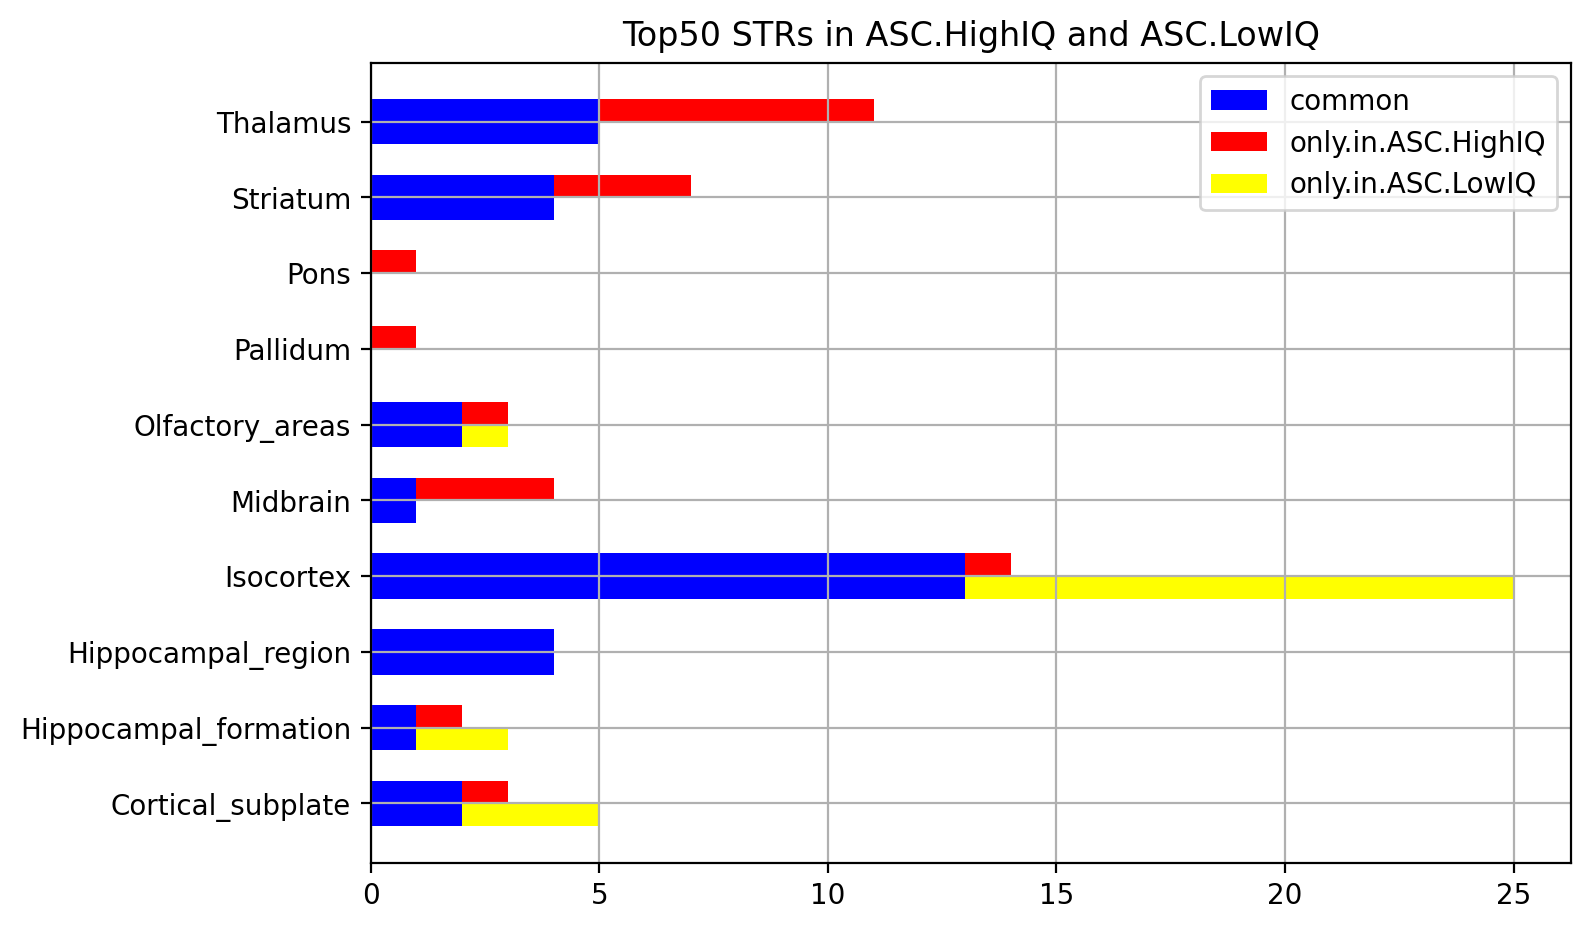

In [238]:
ASC_IQ_BRS_compare = CompareSTROverlap(asc_hiq_avgZ_Mutcount, asc_liq_avgZ_Mutcount, "ASC.HighIQ", "ASC.LowIQ")
ASC_IQ_BRS_compare.to_csv("dat/ASC_IQ_BRS_STR_Overlap.csv", index=False)

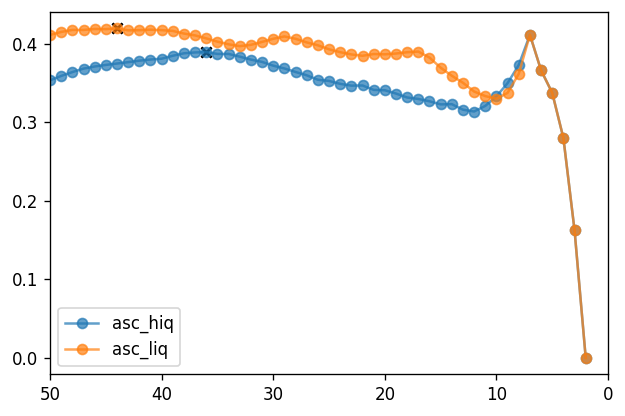

In [245]:
ShowTrimmingProfile([asc_hiq_avgZ_Mutcount, asc_liq_avgZ_Mutcount],["asc_hiq", "asc_liq"])

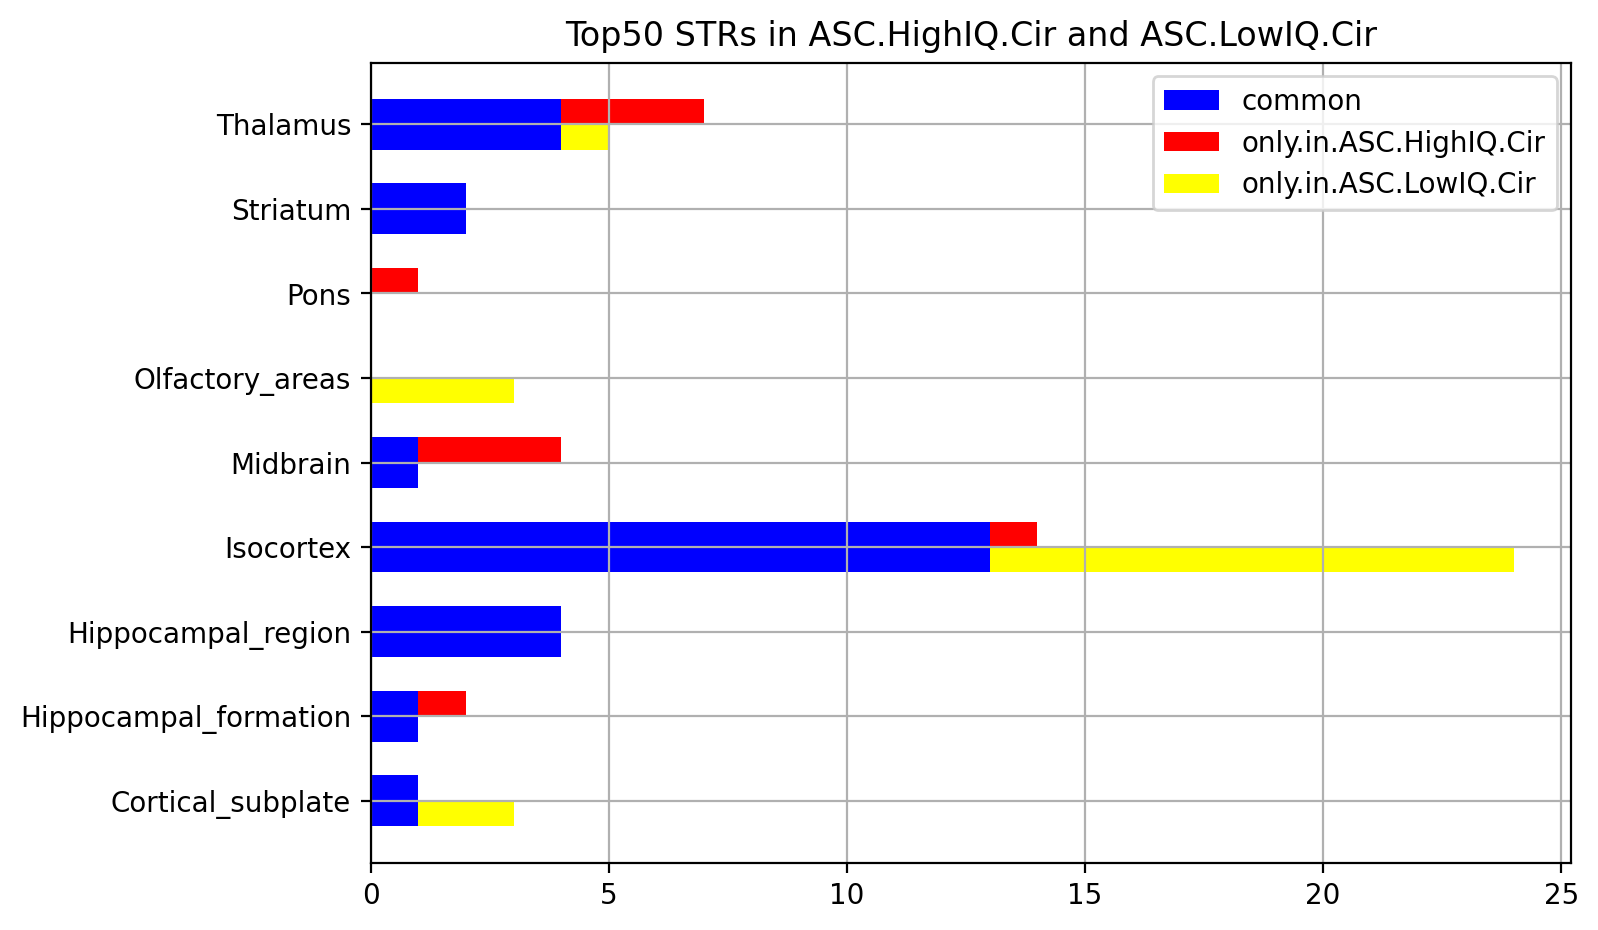

In [241]:
DF1 = asc_hiq_avgZ_Mutcount[asc_hiq_avgZ_Mutcount["InCircuit"]==1]
DF2 = asc_liq_avgZ_Mutcount[asc_liq_avgZ_Mutcount["InCircuit"]==1]
ASC_IQ_BRS_compare = CompareSTROverlap(DF1, DF2, "ASC.HighIQ.Cir", "ASC.LowIQ.Cir")
ASC_IQ_BRS_compare.to_csv("dat/ASC_IQ_BRS_Cir_Overlap.csv", index=False)

#### asdfl

In [ ]:
#### sdf

asc_gene2MutN = ASC_Gene_Weights(asc_df, gnomad_cons, FDR=0.1)
asc_asdp_gene2MutN = ASC_Gene_Weights(asc_asdp, gnomad_cons, FDR=0.1)
asc_asdndd_gene2MutN = ASC_Gene_Weights(asc_asdndd, gnomad_cons, FDR=0.1)

In [71]:
asc_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, asc_gene2MutN,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
asc_avgZ_RD = RegionDistributions(asc_avgZ_Mutcount.set_index("STR"))

In [72]:
asc_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.explevel.weighted.Mutcount.bias.csv")
asc_explevel_RD = RegionDistributions(asc_explevel_Mutcount.set_index("STR"))

In [73]:
asc_asdp_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, asc_asdp_gene2MutN,
                                              csv_fil = "dat/bias/asc.asdp.avgZ.weighted.Mutcount.bias.csv")
asc_asdp_avgZ_RD = RegionDistributions(asc_asdp_avgZ_Mutcount.set_index("STR"))

In [74]:
asc_asdndd_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, asc_asdndd_gene2MutN,
                                              csv_fil = "dat/bias/asc.asdndd.avgZ.weighted.Mutcount.bias.csv")
asc_asdndd_avgZ_RD = RegionDistributions(asc_asdndd_avgZ_Mutcount.set_index("STR"))

In [75]:
asc_asdp_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, asc_asdp_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.asdp.explevel.weighted.Mutcount.bias.csv")
asc_asdp_explevel_RD = RegionDistributions(asc_asdp_explevel_Mutcount.set_index("STR"))

In [76]:
asc_asdndd_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, asc_asdndd_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.asdndd.explevel.weighted.Mutcount.bias.csv")
asc_asdndd_explevel_RD = RegionDistributions(asc_asdndd_explevel_Mutcount.set_index("STR"))

In [7]:
#asc_gene2None, asc_gene2RR, asc_gene2MutN, asc_gene2Cons, asc_gene2MutNLofZ, asc_gene2MutNQValue = ASC_Gene_Weights(
#    "../dat/genes/asd/asc_tada_RR.csv", gnomad_cons, FDR=0.1)
#asd_asc_match_df = pd.read_csv("dat/matching/asd_asc_exp_matches_1000.csv", index_col="GENE")
#print("Number of genes: %d"%len(asc_gene2RR))
#asc_gene2MutN_Length = ASC_MutCountByLength(
#    "../dat/genes/asd/asc_tada_RR.csv", 
#    "/Users/jiayao/Work/ASD_Circuits/src/dat/match-features.csv" , FDR=0.1)

In [40]:
#asc_explevel_norm_Mutcount = ExpAVGWithExpMatch(ExpMatNorm, asc_gene2MutN, asd_asc_match_df,
#                                              csv_fil = "dat/bias/asc.norm.explevel.weighted.Mutcount.bias.csv")
#RegionDistributions(asc_explevel_norm_Mutcount.set_index("STR"))

In [41]:
#asc_avgZ_norm_Mutcount = AvgSTRZ_Weighted(ExpZscoreMatNorm, asc_gene2MutN,
#                                              csv_fil = "dat/bias/asc.norm.avgZ.weighted.Mutcount.bias.csv")
#RegionDistributions(asc_avgZ_norm_Mutcount.set_index("STR"))

In [42]:
#asc_specificity_MutNQ = AvgSTRZ_Weighted(ExpZscoreMat, asc_gene2MutNQValue, 
#                                                         csv_fil="dat/bias/asc.avgZ.weighted.MutNQ.bias.csv")
#RegionDistributions(asc_specificity_MutNQ.set_index("STR"))

In [43]:
#asc_explevel_MutNQ = ExpAVGWithExpMatch(ExpMat, asc_gene2MutNQValue, asd_asc_match_df,
#                                                         csv_fil="dat/bias/asc.explevel.weighted.MutNQ.bias.csv")
#RegionDistributions(asc_explevel_MutNQ.set_index("STR"))

In [44]:
#asc_specificity_MutNGL = AvgSTRZ_Weighted(ExpZscoreMat, asc_gene2MutN_Length, 
#                                                         csv_fil="dat/bias/asc.avgZ.weighted.MutNGL.bias.csv")
#RegionDistributions(asc_specificity_MutNGL.set_index("STR"))

In [45]:
#asc_explevel_MutNGL = ExpAVGWithExpMatch(ExpMat, asc_gene2MutN_Length, asd_asc_match_df,
#                                              csv_fil = "dat/bias/asc.explevel.weighted.MutNGL.bias.csv")
#RegionDistributions(asc_explevel_MutNGL.set_index("STR"))

In [46]:
#asc_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, asc_gene2MutN, asd_asc_match_df,
#                                              csv_fil = "dat/bias/asc.explevel.weighted.Mutcount.bias.csv")
#RegionDistributions(asc_explevel_Mutcount.set_index("STR"))

In [47]:
#asc_explevel_Unifrom = ExpAVGWithExpMatch(ExpMat, asc_gene2None, asd_asc_match_df,
#                                              csv_fil = "dat/bias/asc.explevel.weighted.Uniform.bias.csv")
#RegionDistributions(asc_explevel_Unifrom.set_index("STR"))

In [48]:
#asc_explevel_RR = ExpAVGWithExpMatch(ExpMat, asc_gene2RR, asd_asc_match_df,
#                                              csv_fil = "dat/bias/asc.explevel.weighted.RR.bias.csv")
#RegionDistributions(asc_explevel_RR.set_index("STR"))

In [49]:
#asc_avgZ_RR = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, asc_gene2RR, asd_asc_match_df,
#                                              csv_fil = "dat/bias/asc.avgZ.weighted.RR.bias.csv")
#RegionDistributions(asc_avgZ_RR.set_index("STR"))

In [50]:
#asc_avgZ_Uniform = AvgSTRZ_Weighted(ExpMat, asc_gene2None, Match_DF=1,
#                                              csv_fil = "dat/bias/asc.avgZ.weighted.Uniform.bias.csv")
#RegionDistributions(asc_avgZ_Uniform.set_index("STR"))

In [51]:
#asc_explevel_LofZ = ExpressionLevelWeightedBias(ExpMat, asc_gene2LofZ, asd_asc_match_df,
#                                              csv_fil = "dat/bias/asc.explevel.weighted.LofZ.bias.csv")
#RegionDistributions(asc_explevel_LofZ.set_index("STR"))

In [52]:
#asc_zmatch_bias = pd.read_csv("dat/bias/asd.asc.zmatch.rank.csv", index_col="STR")
#asc_elevel_bias = pd.read_csv("dat/bias/asc.explevel.rank.tsv", index_col="STR")
#spark_zmatch_bias = pd.read_csv("dat/bias/asd.sparktada.zmatch.rank.csv", index_col="STR")
#spark_elevel_bias = pd.read_csv("dat/bias/sparktada.explevel.rank.tsv", index_col="STR")
#asc_uniform_top50 = set(asc_explevel_Unifrom.head(50).index.values)
#asc_RR_top50 = set(asc_explevel_RR.head(50).index.values)
#asc_MutCount_top50 = set(asc_explevel_Mutcount.head(50).index.values)
#asc_LofZ_top50 = set(asc_explevel_LofZ.head(50).index.values)
#dat_dict = {"asc_uniform_top50": asc_uniform_top50, "asc_RR_top50":asc_RR_top50, 
#            "asc_MutCount_top50": asc_MutCount_top50, "asc_LofZ_top50":asc_LofZ_top50}
#venn(dat_dict)

# SPARK TADA

In [36]:
spark_tada = pd.read_csv("../dat/genes/asd/spark_tada_RR.csv", index_col="HGNC")
spark_tada_pred = spark_tada[spark_tada["Qvalue"]<0.2]
asd_sparktada_match_df = pd.read_csv("dat/matching/asd_sparktada_exp_matches_1000.new.csv", index_col="GENE")

## Missing Values as Zeros

In [37]:
spark_gene2MutN = SPARK_Gene_Weights(spark_tada_pred, gnomad_cons, FDR=0.2)

In [38]:
spark_highconf_avgZ_MutN = AvgSTRZ_Weighted(ExpZscoreMat2, spark_gene2MutN,
                                              csv_fil = "dat/bias2/sparktada.avgZ.mutN.csv")
spark_avgZ_RD = RegionDistributions(spark_highconf_avgZ_MutN.set_index("STR"), show=True)

41
Isocortex 	 24 	 Prelimbic_area; Dorsal_auditory_area; Orbital_area_ventrolateral_part; Infralimbic_area; Orbital_area_lateral_part; Primary_visual_area; Orbital_area_medial_part; Anterior_cingulate_area_dorsal_part; Secondary_motor_area; Retrosplenial_area_lateral_agranular_part; Lateral_visual_area; Anteromedial_visual_area; Primary_motor_area; Primary_somatosensory_area_lower_limb; Frontal_pole_cerebral_cortex; Visceral_area; Posterolateral_visual_area; Gustatory_areas; Supplemental_somatosensory_area; Agranular_insular_area_ventral_part; Anterior_cingulate_area_ventral_part; Agranular_insular_area_posterior_part; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk
Hippocampal_formation 	 4 	 Subiculum_ventral_part; Parasubiculum; Subiculum_dorsal_part; Presubiculum
Pons 	 1 	 Superior_central_nucleus_raphe
Cortical_subplate 	 6 	 Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Claustrum; Basolateral_amygdalar_nucleus; Endopiriform_nucleus_ventral_part

In [77]:
spark_tada = pd.read_csv("../dat/genes/asd/spark_tada_RR.csv", index_col="HGNC")
asd_sparktada_match_df = pd.read_csv("dat/matching/asd_sparktada_exp_matches_1000.csv", index_col="GENE")
print(spark_tada.columns.values)
spark_tada_pred = spark_tada[spark_tada["Qvalue"]<0.2]
spark_tada_pred.head(2)

#ASD_NDD_Classfiy = pd.read_csv("./dat/ASC_SPARK_NDD_split.csv")
ASDp_genes = ASD_NDD_Classfiy[ASD_NDD_Classfiy["SPARKClass"]=="ASD_p"]["gene"].values
ASD_NDD_genes = ASD_NDD_Classfiy[ASD_NDD_Classfiy["SPARKClass"]=="ASD_NDD"]["gene"].values
spark_asdp = spark_tada_pred[spark_tada_pred.index.isin(ASDp_genes)]
spark_asdndd = spark_tada_pred[spark_tada_pred.index.isin(ASD_NDD_genes)]

['GeneID' 'ExACpLI' 'gnomADpLI' 'LoFOvsE' 'sHet' 'SFARICategory'
 'SFARIScore' 'DDDCategory' 'DDDAllelic' 'DDDMutCons' 'DDDOrgan' 'dnLGD'
 'mutLGD' 'log10BF_dnLGD' 'dnDmis' 'mutDmis' 'log10BF_dnDmis'
 'log10BF_All' 'PP_All' 'Qvalue' 'LGD_RR' 'Dmis_RR' 'Entrez']


In [246]:
spark_gene2MutN = SPARK_Gene_Weights(spark_tada_pred, gnomad_cons, FDR=0.2)
spark_asdp_gene2MutN = SPARK_Gene_Weights(spark_asdp, gnomad_cons, FDR=0.2)
spark_asdndd_gene2MutN = SPARK_Gene_Weights(spark_asdndd, gnomad_cons, FDR=0.2)

spark_cog = pd.read_csv("../dat/genes/asd/spark.CongImpair.csv")
spark_noncong = pd.read_csv("../dat/genes/asd/spark.NonCog_impair.csv")
spark_cog_gene2MutN = ASC_Gene_Weights_ByIQ(spark_cog, FDR=0.2)
spark_noncong_gene2MutN = ASC_Gene_Weights_ByIQ(spark_noncong, FDR=0.2)

In [281]:
spark_highconf_gene2MutN = SPARK_Gene_Weights(spark_tada_pred, gnomad_cons, FDR=0.001)
print(len(spark_highconf_gene2MutN))
spark_highconf_avgZ_MutN = AvgSTRZ_Weighted(ExpZscoreMat, spark_highconf_gene2MutN,
                                              csv_fil = "dat/bias/sparktada.avgZ.highconf.csv")
spark_avgZ_RD = RegionDistributions(spark_highconf_avgZ_MutN.set_index("STR"), show=True)

25
43
Midbrain 	 1 	 Anterior_pretectal_nucleus
Olfactory_areas 	 3 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Piriform_area
Thalamus 	 3 	 Parafascicular_nucleus; Lateral_posterior_nucleus_of_the_thalamus; Nucleus_of_reuniens
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum
Pallidum 	 1 	 Bed_nuclei_of_the_stria_terminalis
Striatum 	 3 	 Caudoputamen; Nucleus_accumbens; Lateral_septal_nucleus_ventral_part
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA3; Field_CA1; Field_CA2
Isocortex 	 26 	 Prelimbic_area; Primary_visual_area; Primary_motor_area; Secondary_motor_area; Primary_somatosensory_area_lower_limb; Infralimbic_area; Anterior_cingulate_area_dorsal_part; Frontal_pole_cerebral_cortex; Anteromedial_visual_area; Gustatory_areas; Lateral_visual_area; Orbital_area_lateral_part; Primary_somatosensory_area_trunk; Orbital_area_ventrolateral_part; Primary_somatosensory_area_barrel_field; Primary_somatosensory_area_mouth; Supplemental_s

In [247]:
print(len(spark_cog_gene2MutN), len(spark_noncong_gene2MutN))

72 95


In [248]:
spark_noncong_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, spark_noncong_gene2MutN,
                                              csv_fil = "dat/bias/spark.noncog.avgZ.weighted.Mutcount.bias.csv")
spark_noncong_avgZ_RD = RegionDistributions(spark_noncong_avgZ_Mutcount.set_index("STR"))

40


In [249]:
spark_cong_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, spark_cog_gene2MutN,
                                              csv_fil = "dat/bias/spark.cog.avgZ.weighted.Mutcount.bias.csv")
spark_cong_avgZ_RD = RegionDistributions(spark_cong_avgZ_Mutcount.set_index("STR"))

48


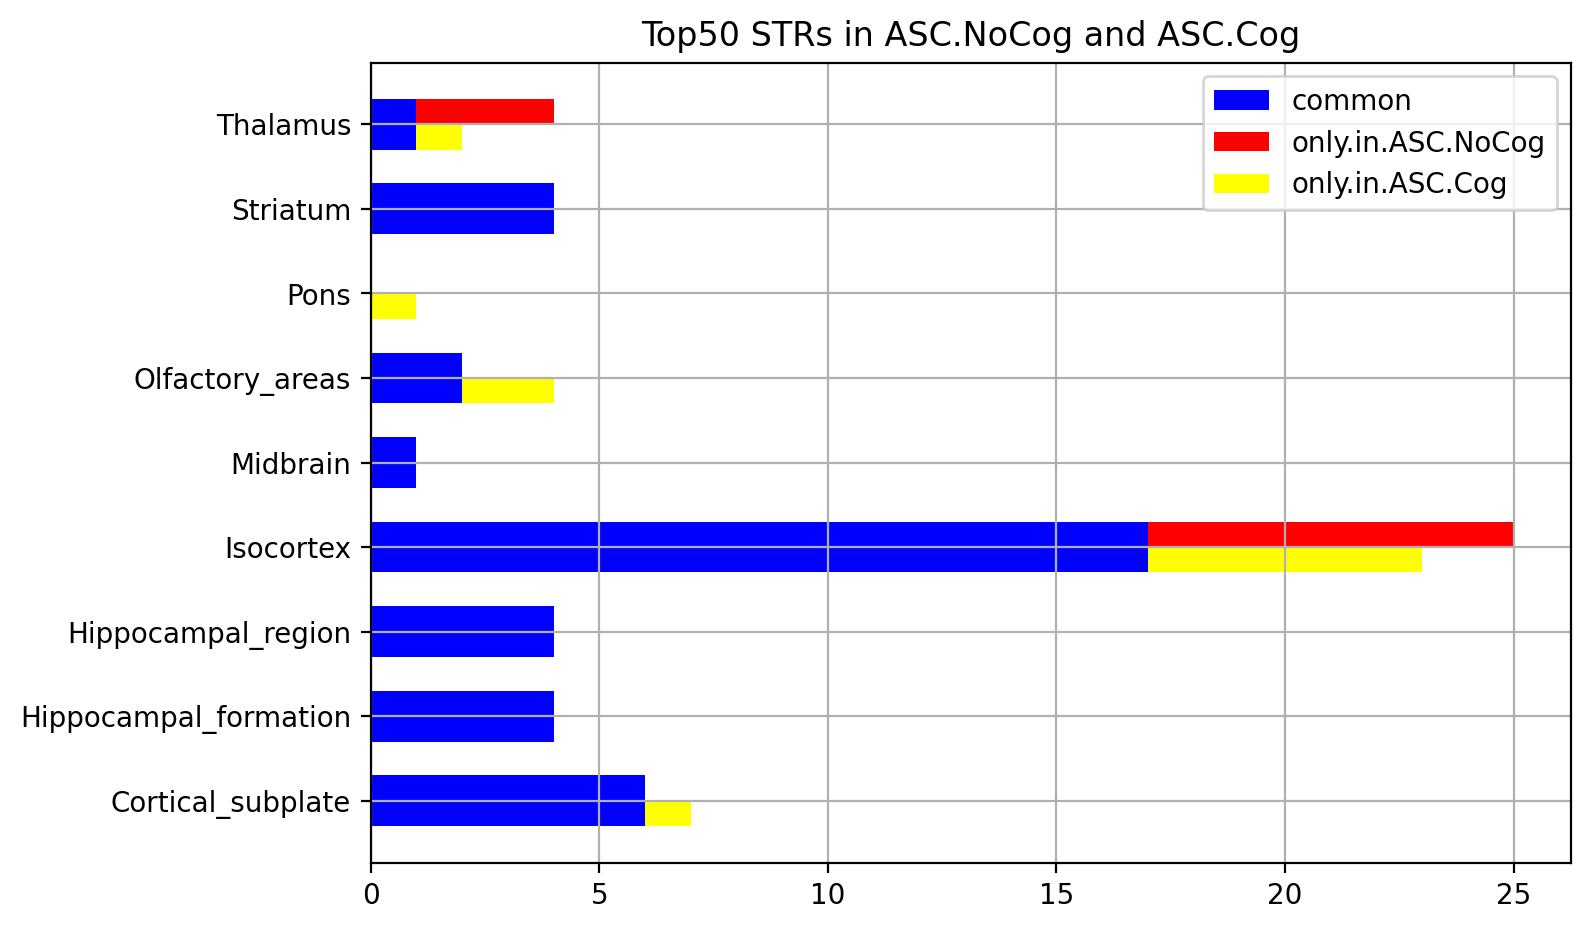

In [250]:
SPARK_Cong_BRS_compare = CompareSTROverlap(spark_noncong_avgZ_Mutcount, spark_cong_avgZ_Mutcount, "spark.NoCog", "spark.Cog")
SPARK_Cong_BRS_compare.to_csv("dat/ASC_IQ_BRS_ STR_Overlap.csv", index=False)

In [ ]:
ShowTrimmingProfile([asc_hiq_avgZ_Mutcount, asc_liq_avgZ_Mutcount],["asc_hiq", "asc_liq"])

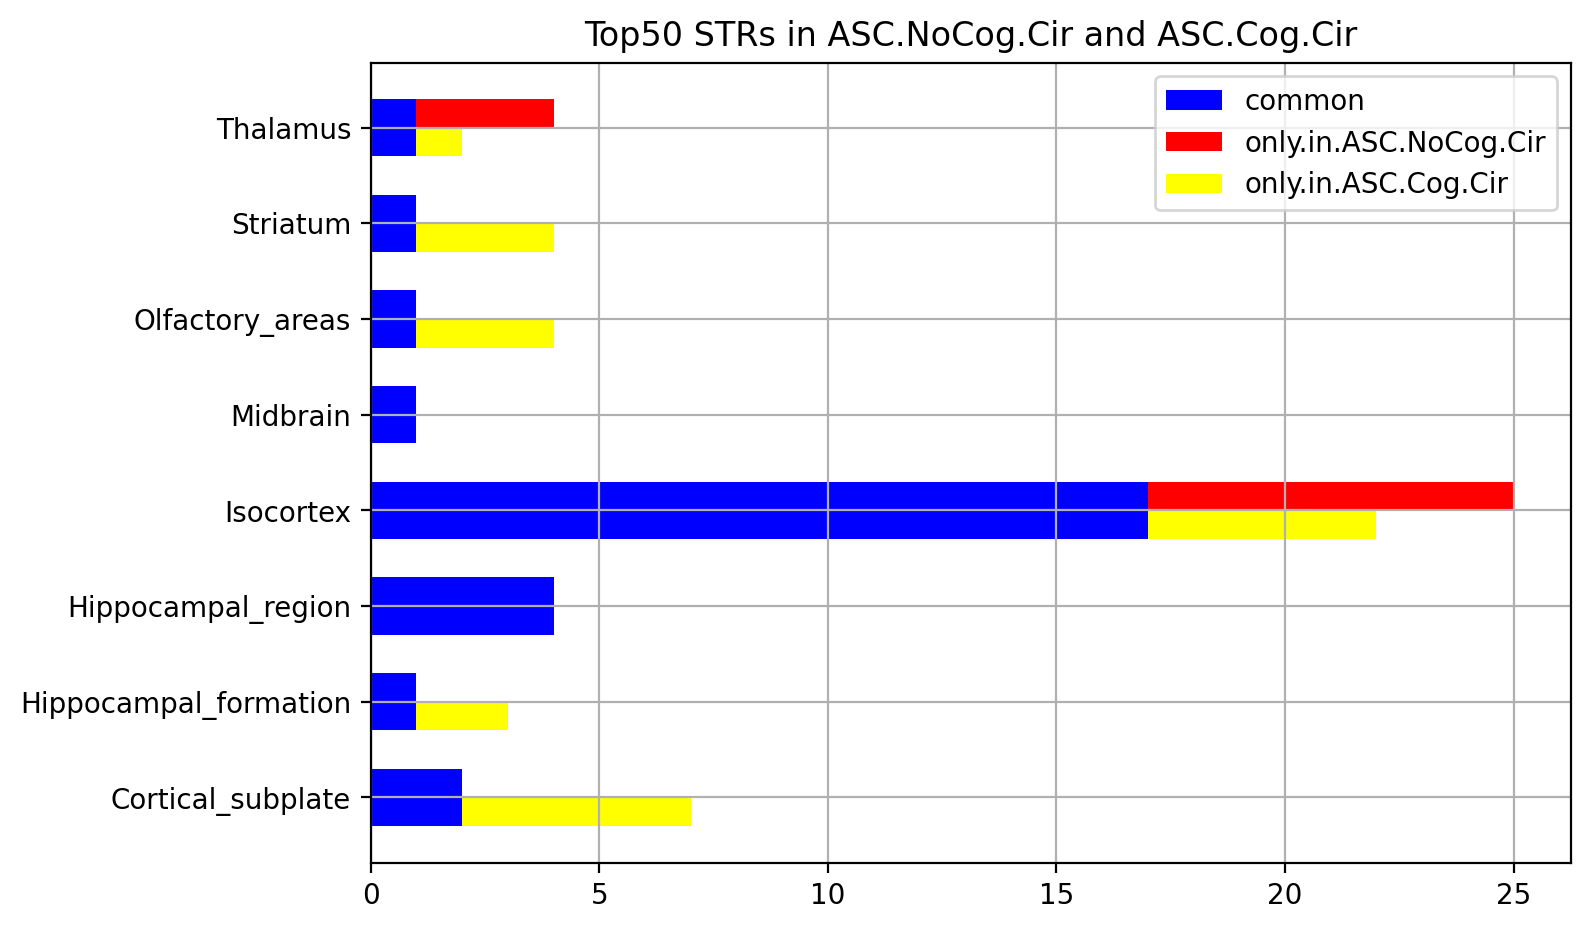

In [251]:
DF1 = spark_noncong_avgZ_Mutcount[spark_noncong_avgZ_Mutcount["InCircuit"]==1]
DF2 = spark_cong_avgZ_Mutcount[spark_cong_avgZ_Mutcount["InCircuit"]==1]
ASC_IQ_BRS_compare = CompareSTROverlap(DF1, DF2, "spark.NoCog.Cir", "spark.Cog.Cir")
ASC_IQ_BRS_compare.to_csv("dat/ASC_IQ_BRS_Cir_Overlap.csv", index=False)

In [79]:
spark_avgZ_MutN = AvgSTRZ_Weighted(ExpZscoreMat, spark_gene2MutN,
                                              csv_fil = "dat/bias/sparktada.avgZ.weighted.Mutcount.bias.csv")
spark_avgZ_RD = RegionDistributions(spark_avgZ_MutN.set_index("STR"))

In [80]:
spark_explevel_MutN = ExpAVGWithExpMatch(ExpMat, spark_gene2MutN, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.Mutcount.bias.csv")
spark_explevel_RD = RegionDistributions(spark_explevel_MutN.set_index("STR"))

In [81]:
spark_asdp_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, spark_asdp_gene2MutN,
                                              csv_fil = "dat/bias/spark.asdp.avgZ.weighted.Mutcount.bias.csv")
spark_asdp_avgZ_RD = RegionDistributions(spark_asdp_avgZ_Mutcount.set_index("STR"))

In [82]:
spark_asdndd_avgZ_Mutcount = AvgSTRZ_Weighted(ExpZscoreMat, spark_asdndd_gene2MutN,
                                              csv_fil = "dat/bias/spark.asdndd.avgZ.weighted.Mutcount.bias.csv")
spark_asdndd_avgZ_RD = RegionDistributions(spark_asdndd_avgZ_Mutcount.set_index("STR"))

In [83]:
spark_asdp_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, spark_asdp_gene2MutN, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/spark.asdp.explevel.weighted.Mutcount.bias.csv")
spark_asdp_explevel_RD = RegionDistributions(spark_asdp_explevel_Mutcount.set_index("STR"))

In [84]:
spark_asdndd_explevel_Mutcount = ExpAVGWithExpMatch(ExpMat, spark_asdndd_gene2MutN, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/spark.asdndd.explevel.weighted.Mutcount.bias.csv")
spark_asdndd_explevel_RD = RegionDistributions(spark_asdndd_explevel_Mutcount.set_index("STR"))

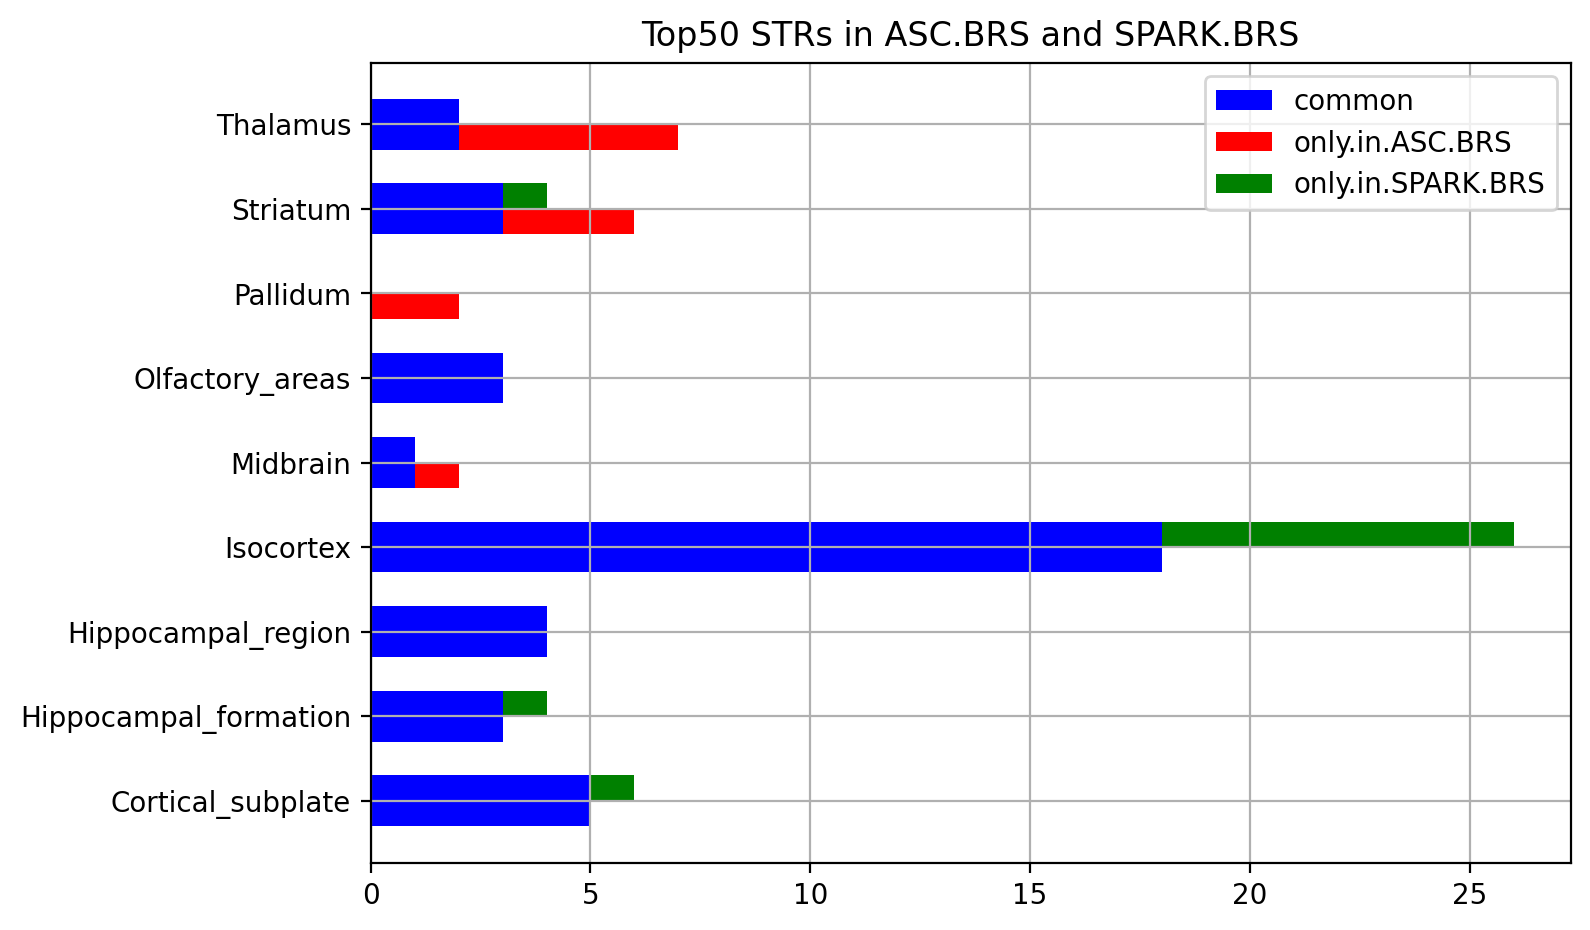

In [146]:
ASC_SPARK_BRS_compare = CompareSTROverlap(asc_avgZ_Mutcount, spark_avgZ_MutN, "ASC.BRS", "SPARK.BRS")
ASC_SPARK_BRS_compare.to_csv("dat/ASC_SPARK_BRS_STR_Overlap.csv", index=False)

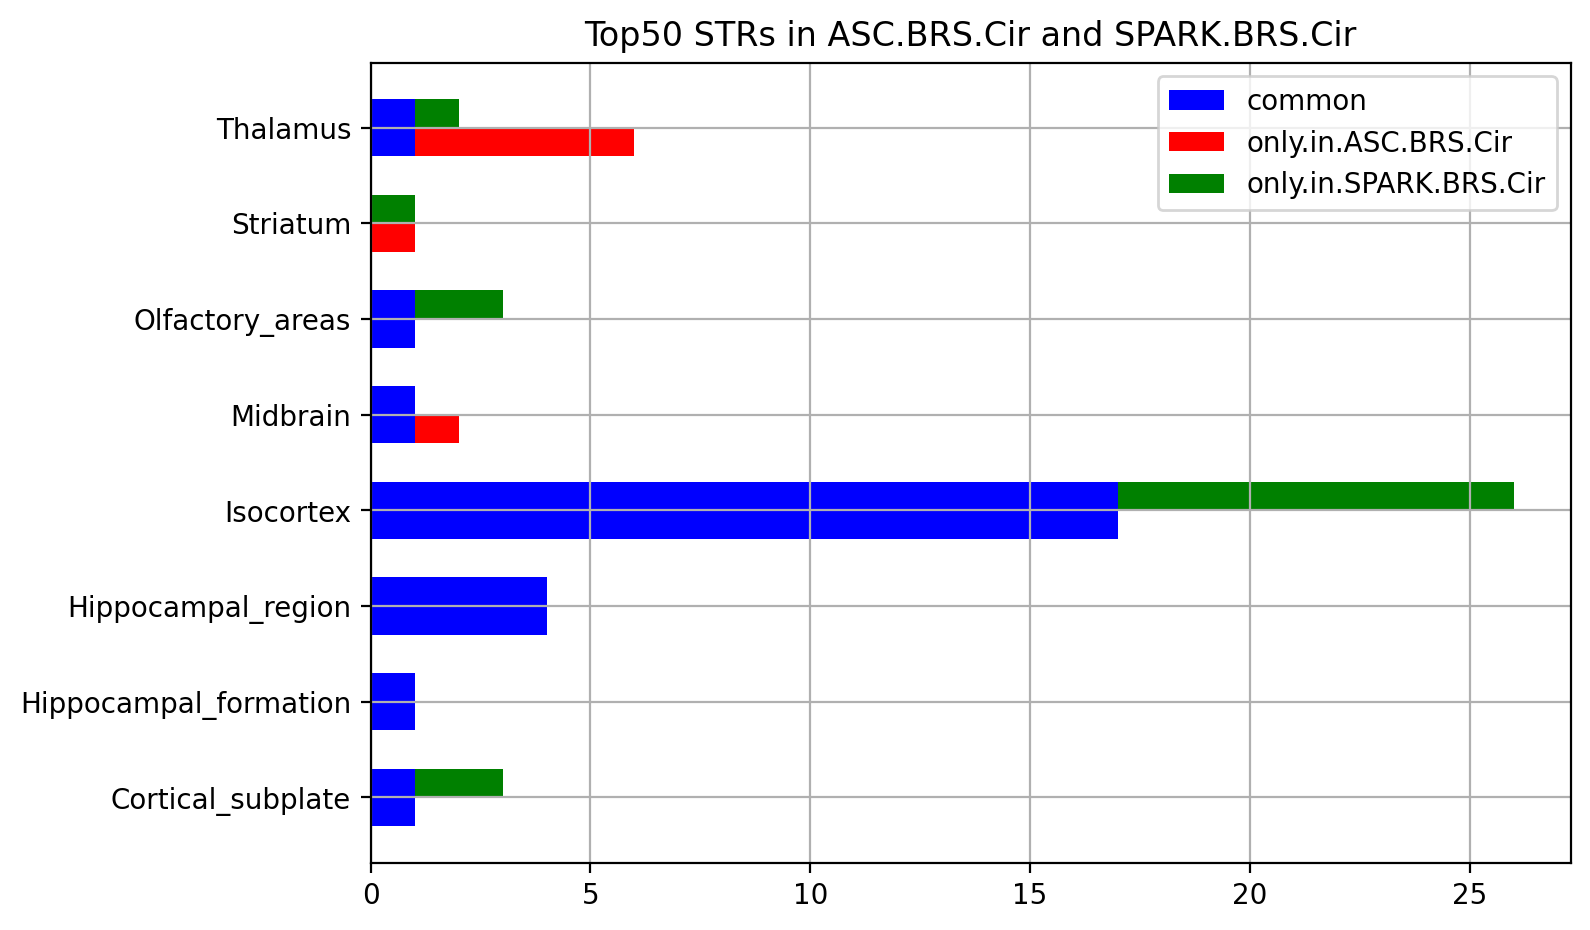

In [159]:
DF1 = asc_avgZ_Mutcount[asc_avgZ_Mutcount["InCircuit"]==1]
DF2 = spark_avgZ_MutN[spark_avgZ_MutN["InCircuit"]==1]
ASC_SPARK_BRS_compare = CompareSTROverlap(DF1, DF2, "ASC.BRS.Cir", "SPARK.BRS.Cir")
ASC_SPARK_BRS_compare.to_csv("dat/ASC_SPARK_BRS_CIR_Overlap.csv", index=False)

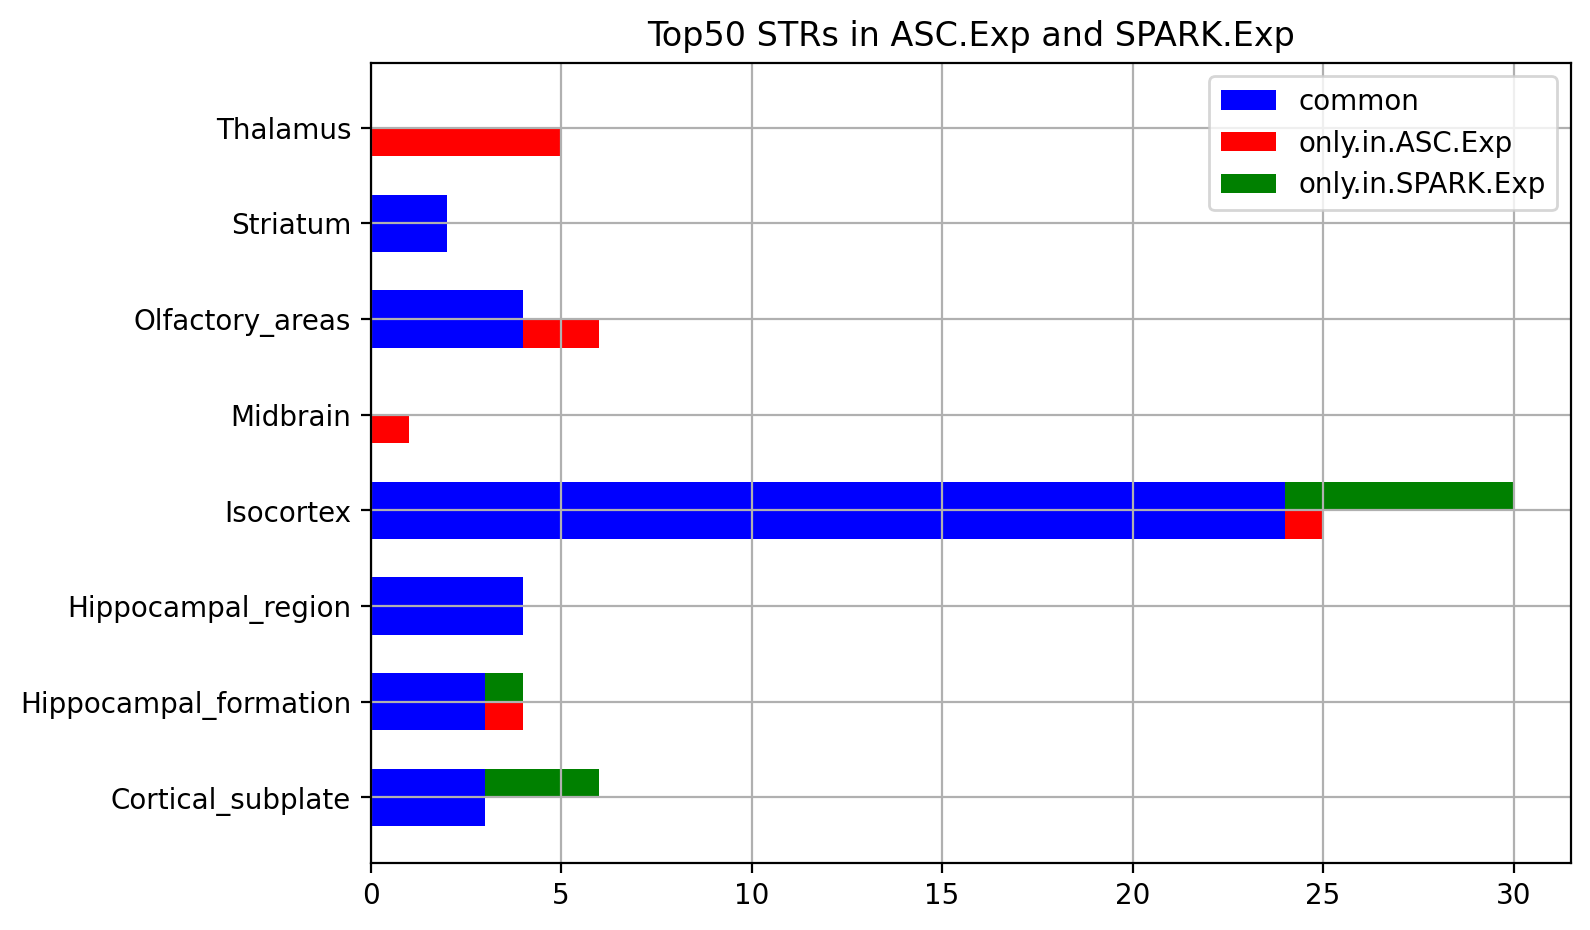

In [147]:
ASC_SPARK_explevel_compare = CompareSTROverlap(asc_explevel_Mutcount, spark_explevel_MutN, 
                                               "ASC.Exp", "SPARK.Exp")
ASC_SPARK_explevel_compare.to_csv("dat/ASC_SPARK_explevel_STR_Overlap.csv", index=False)

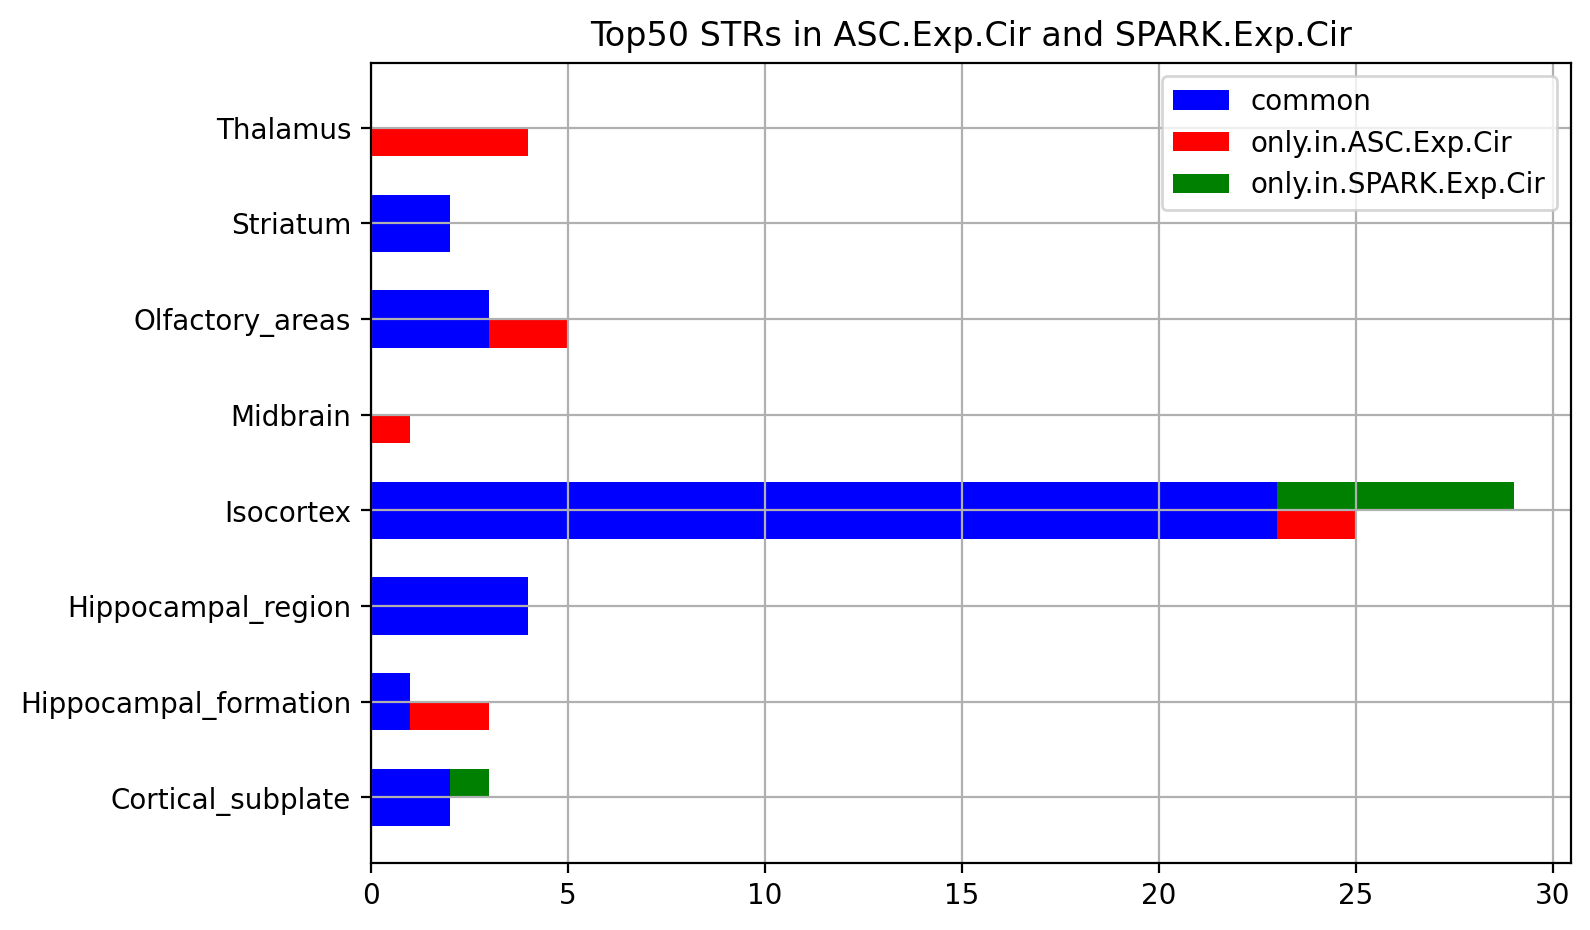

In [160]:
DF1 = asc_explevel_Mutcount[asc_explevel_Mutcount["InCircuit"]==1]
DF2 = spark_explevel_MutN[spark_explevel_MutN["InCircuit"]==1]
ASC_SPARK_BRS_compare = CompareSTROverlap(DF1, DF2, "ASC.Exp.Cir", "SPARK.Exp.Cir")
ASC_SPARK_BRS_compare.to_csv("dat/ASC_SPARK_explevel_CIR_Overlap.csv", index=False)

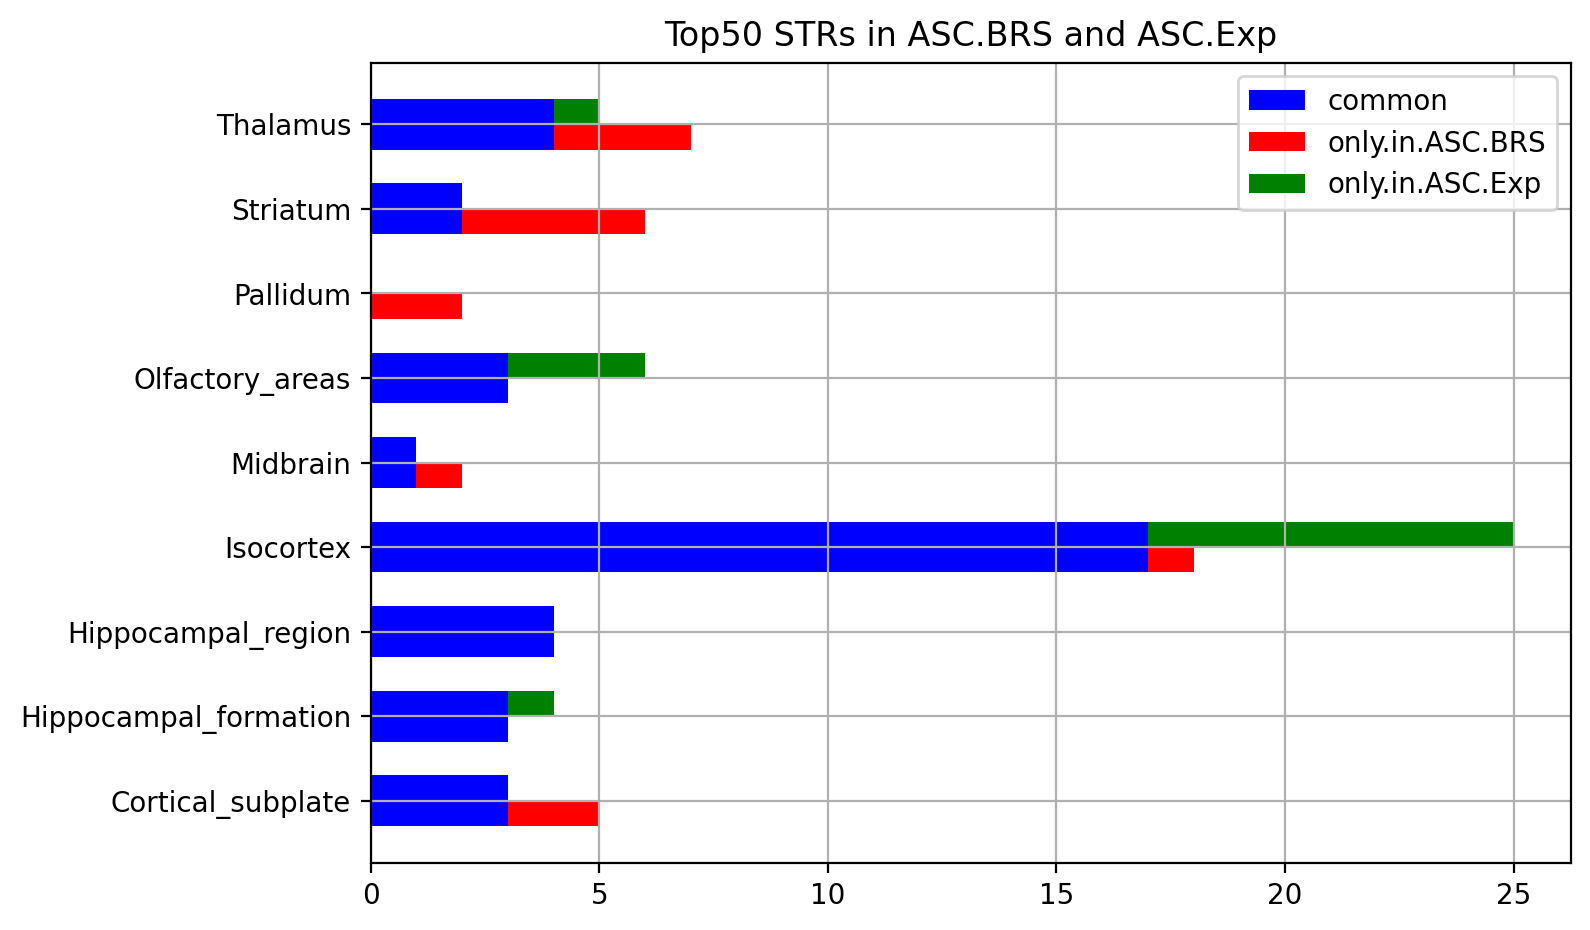

In [157]:
ASC_Exp_BRS_compare = CompareSTROverlap(asc_avgZ_Mutcount, asc_explevel_Mutcount, "ASC.BRS", "ASC.Exp")
ASC_Exp_BRS_compare.to_csv("dat/ASC_BRS_Exp_STR_Overlap.csv", index=False)

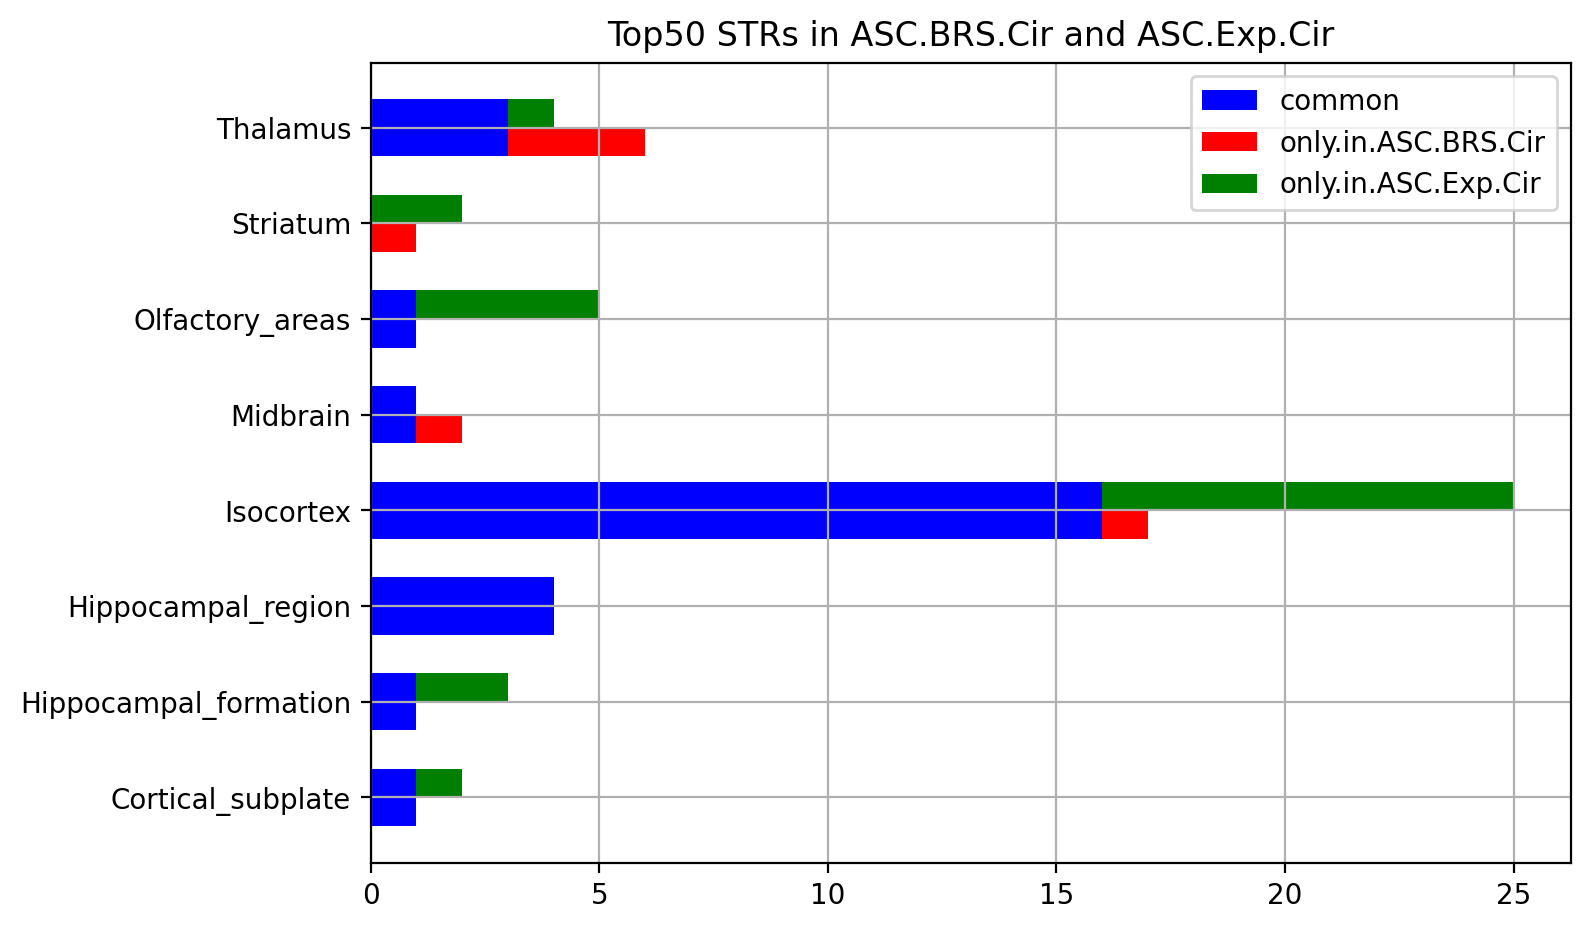

In [161]:
DF1 = asc_avgZ_Mutcount[asc_avgZ_Mutcount["InCircuit"]==1]
DF2 = asc_explevel_Mutcount[asc_explevel_Mutcount["InCircuit"]==1]
ASC_SPARK_BRS_compare = CompareSTROverlap(DF1, DF2, "ASC.BRS.Cir", "ASC.Exp.Cir")
ASC_SPARK_BRS_compare.to_csv("dat/ASC_BRS_Exp_Cir_Overlap.csv", index=False)

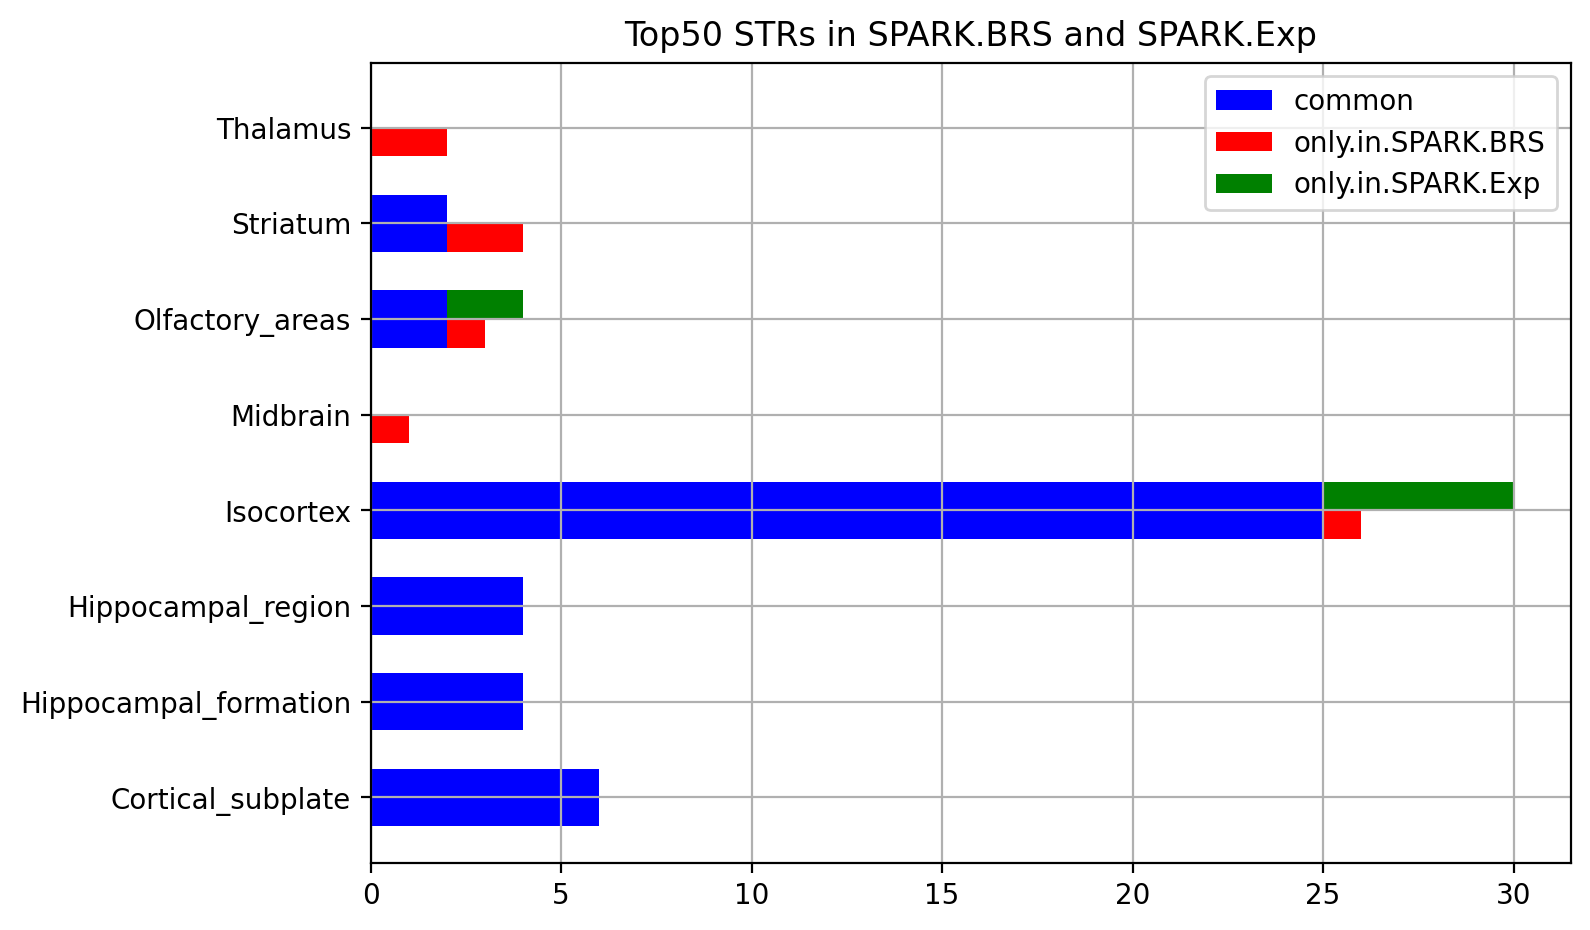

In [158]:
SPARK_BRS_EXP_compare = CompareSTROverlap(spark_avgZ_MutN, spark_explevel_MutN, 
                                               "SPARK.BRS", "SPARK.Exp")
SPARK_BRS_EXP_compare.to_csv("dat/SPARK_BRS_explevel_STR_Overlap.csv", index=False)

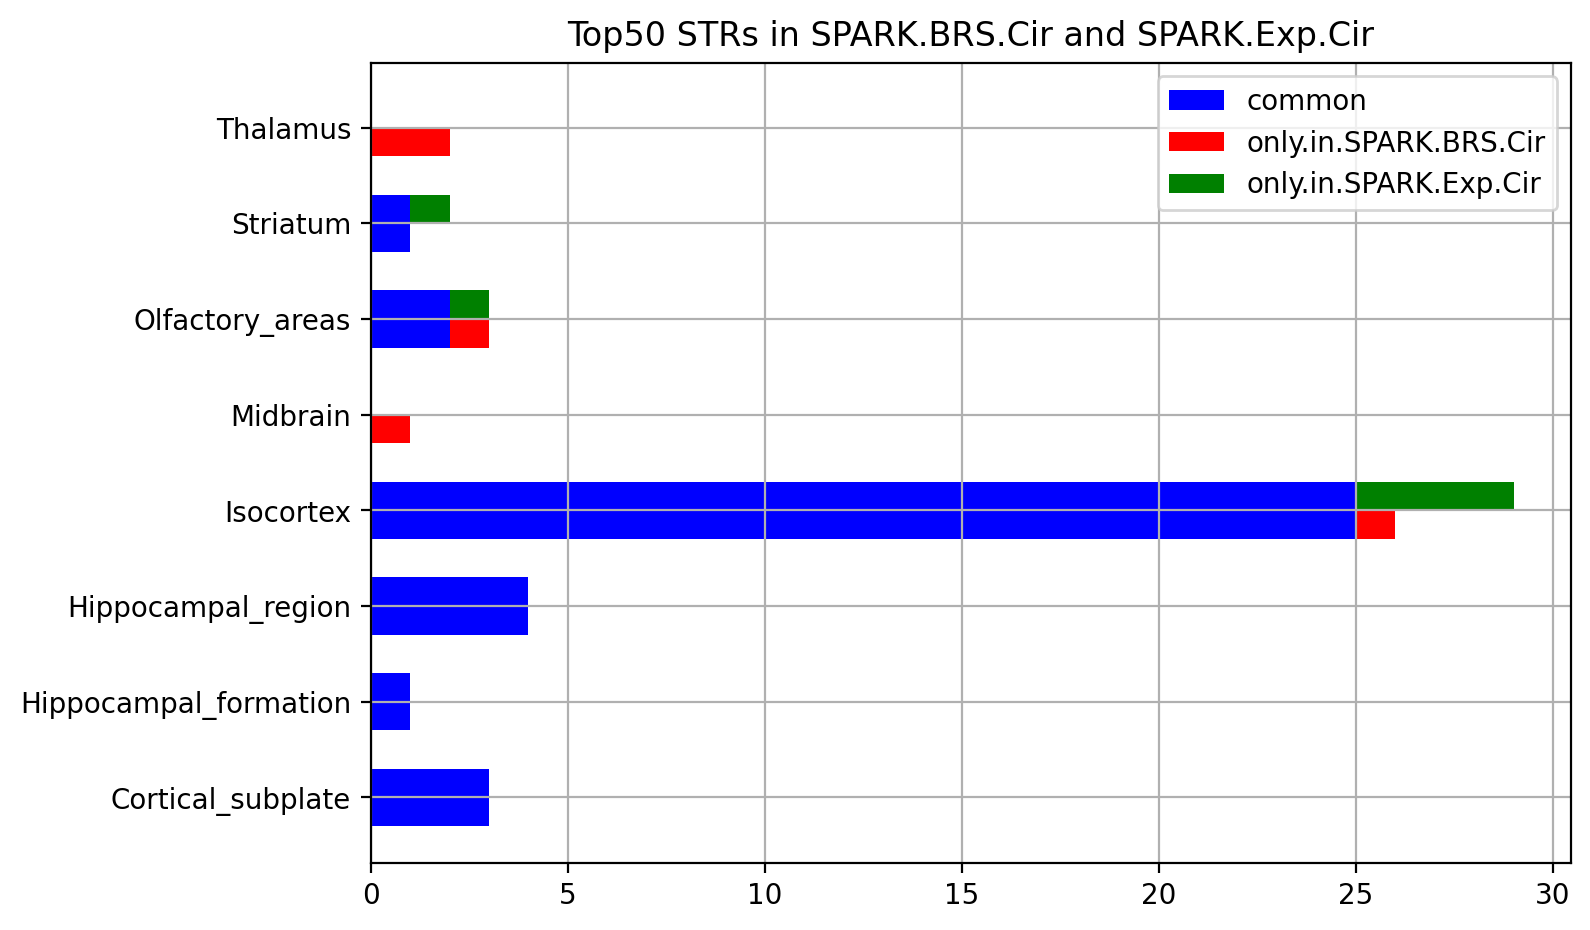

In [162]:
DF1 = spark_avgZ_MutN[spark_avgZ_MutN["InCircuit"]==1]
DF2 = spark_explevel_MutN[spark_explevel_MutN["InCircuit"]==1]
ASC_SPARK_BRS_compare = CompareSTROverlap(DF1, DF2, "SPARK.BRS.Cir", "SPARK.Exp.Cir")
ASC_SPARK_BRS_compare.to_csv("dat/SPARK_BRS_Exp_Cir_Overlap.csv", index=False)

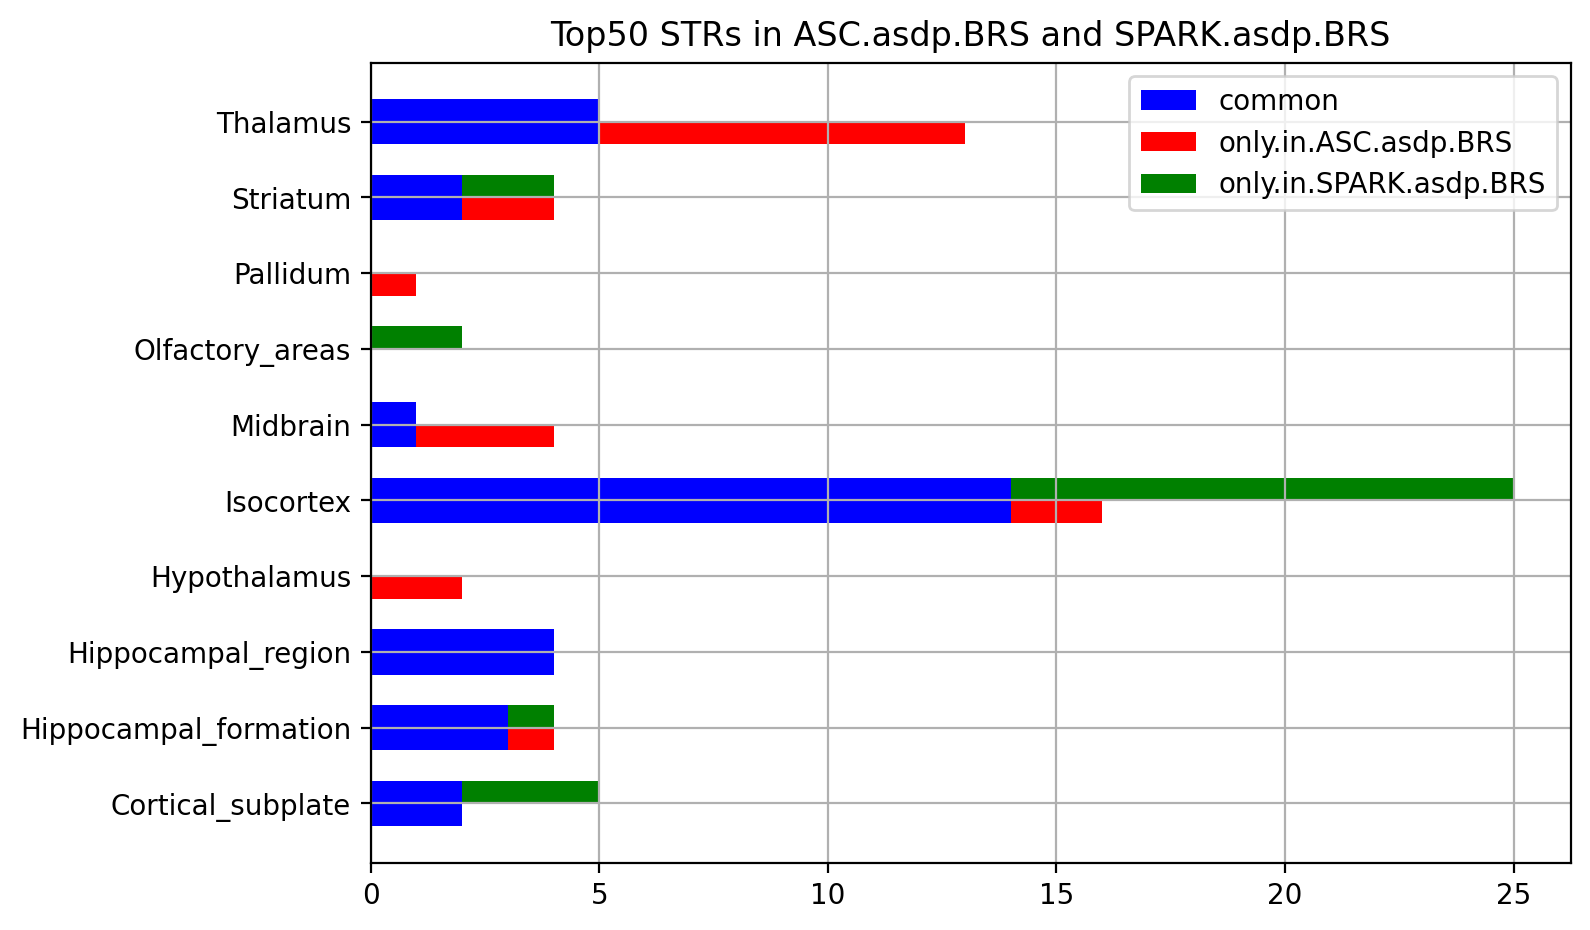

In [150]:
ASC_SPARK_asdp_BRS_compare = CompareSTROverlap(asc_asdp_avgZ_Mutcount, spark_asdp_avgZ_Mutcount,
                                               "ASC.asdp.BRS", "SPARK.asdp.BRS")
ASC_SPARK_asdp_BRS_compare.to_csv("dat/ASC_SPARK_asdp_BRS_STR_Overlap.csv", index=False)

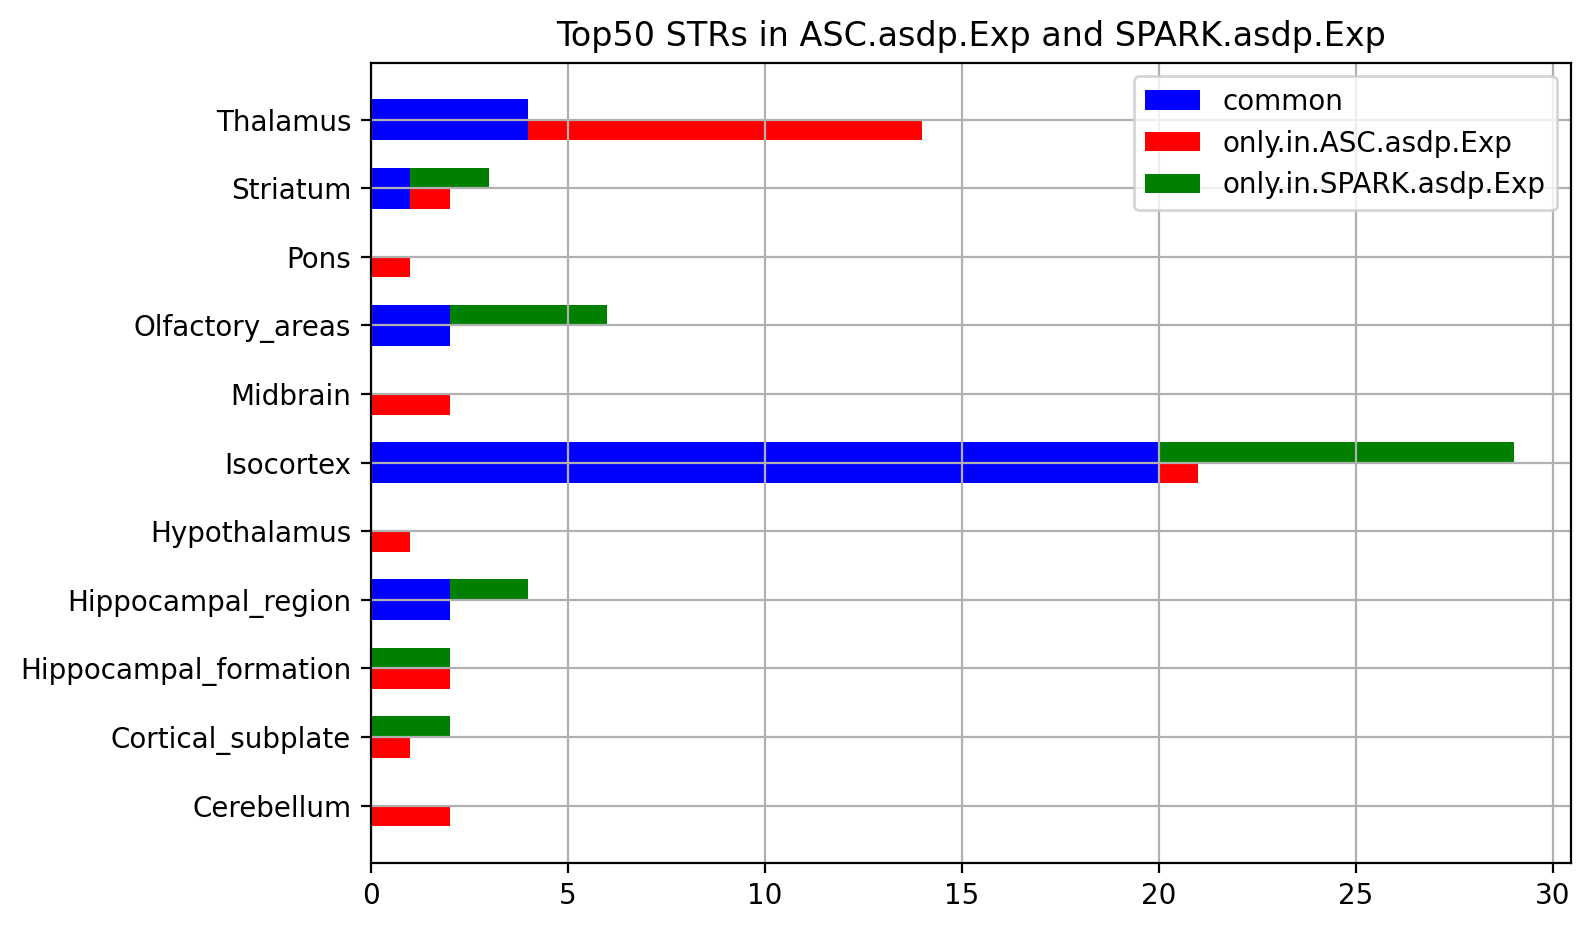

In [149]:
ASC_SPARK_asdp_explevel_compare = CompareSTROverlap(asc_asdp_explevel_Mutcount, spark_asdp_explevel_Mutcount, 
                                               "ASC.asdp.Exp", "SPARK.asdp.Exp")
ASC_SPARK_asdp_explevel_compare.to_csv("dat/ASC_SPARK_asdp_explevel_STR_Overlap.csv", index=False)

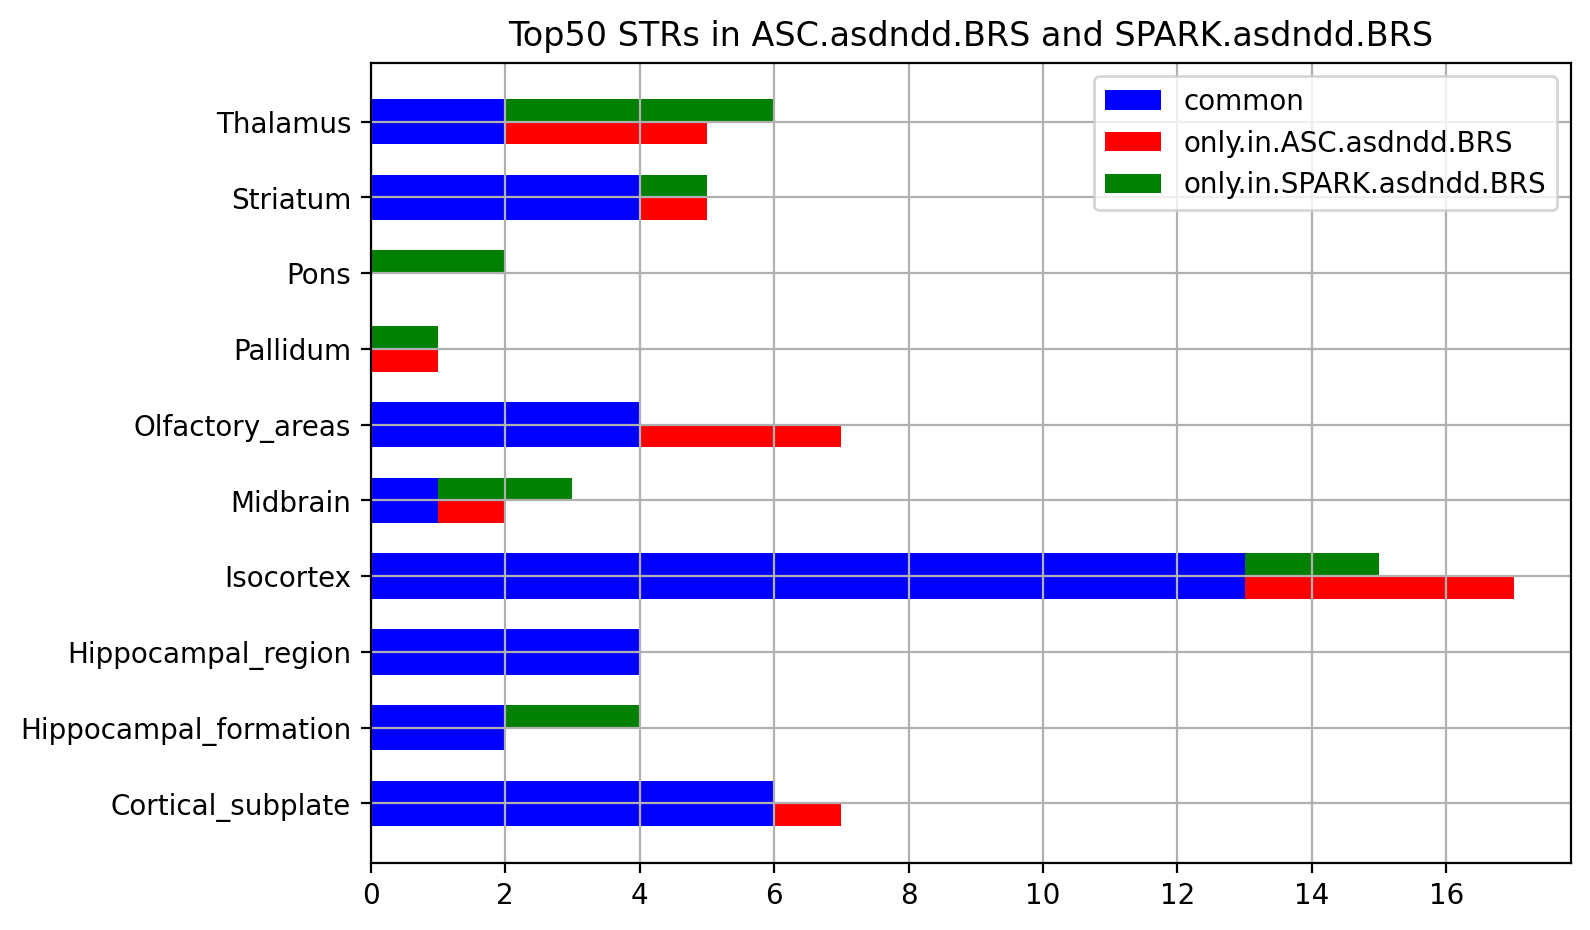

In [151]:
ASC_SPARK_ndd_BRS_compare = CompareSTROverlap(asc_asdndd_avgZ_Mutcount, spark_asdndd_avgZ_Mutcount,
                                               "ASC.asdndd.BRS", "SPARK.asdndd.BRS")
ASC_SPARK_ndd_BRS_compare.to_csv("dat/ASC_SPARK_asdndd_BRS_STR_Overlap.csv", index=False)

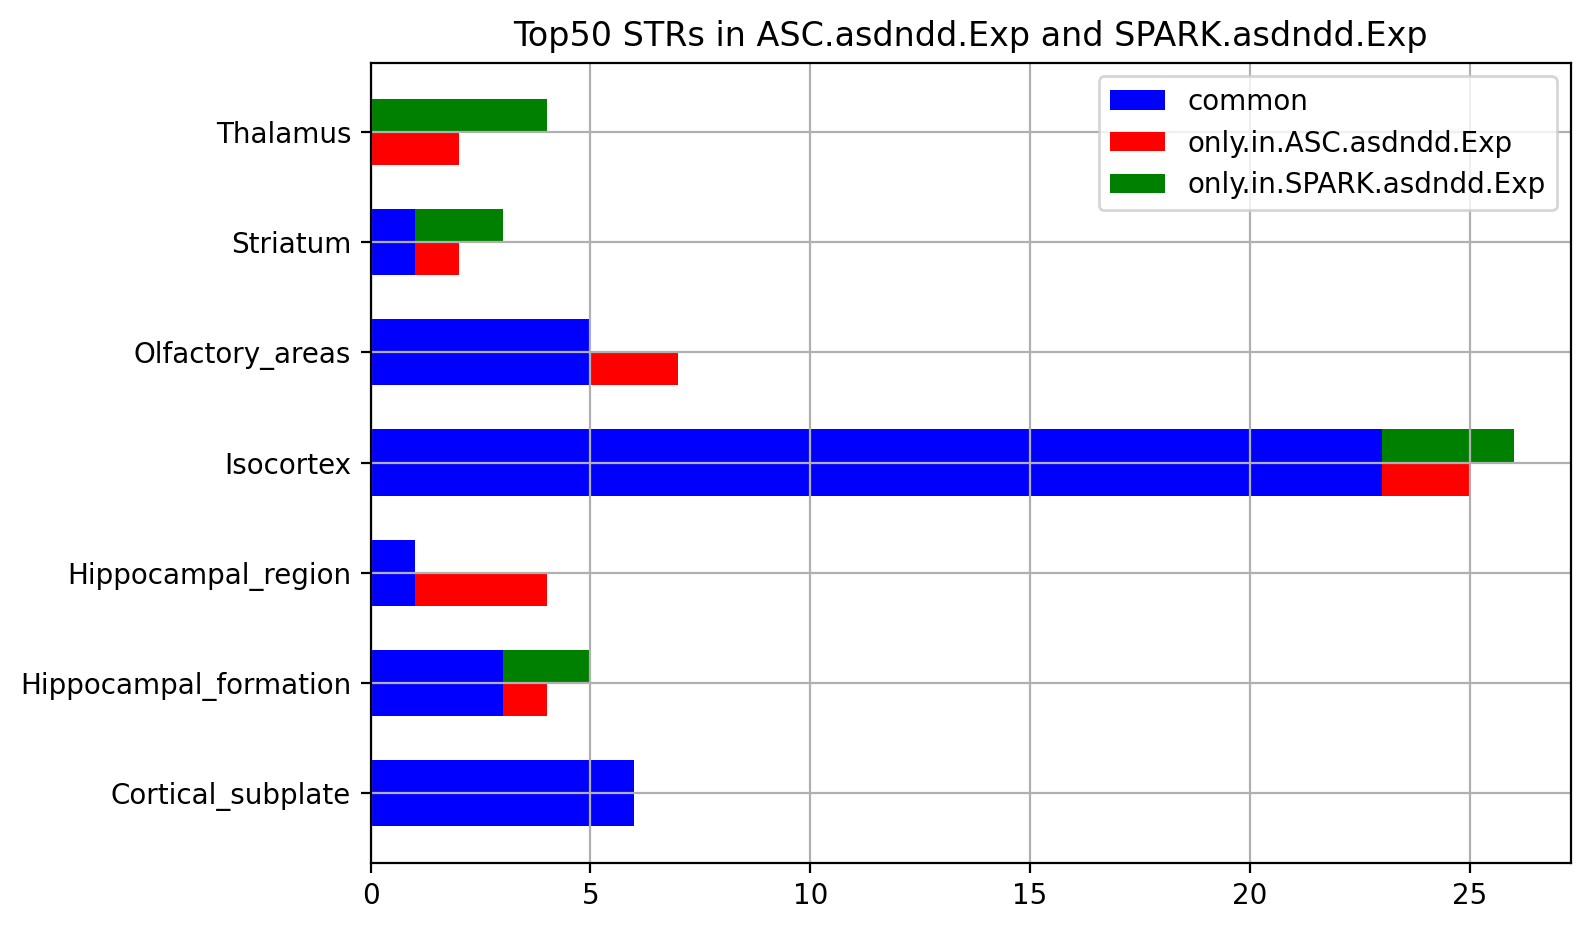

In [152]:
ASC_SPARK_ndd_explevel_compare = CompareSTROverlap(asc_asdndd_explevel_Mutcount, spark_asdndd_explevel_Mutcount, 
                                               "ASC.asdndd.Exp", "SPARK.asdndd.Exp")
ASC_SPARK_ndd_explevel_compare.to_csv("dat/ASC_SPARK_asdndd_explevel_STR_Overlap.csv", index=False)

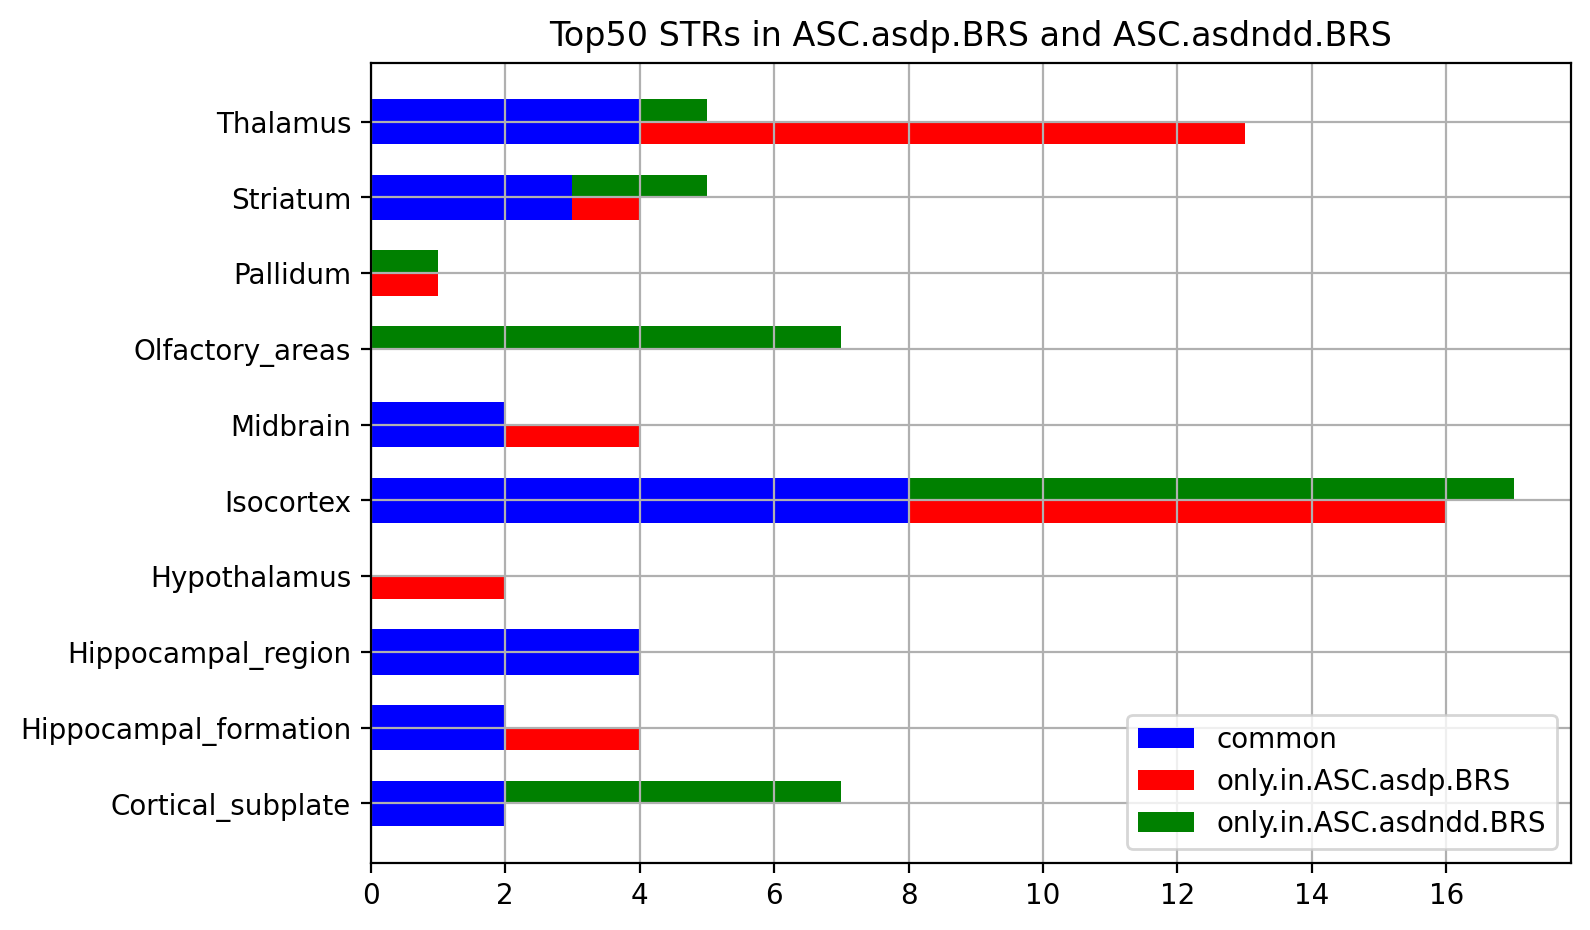

In [153]:
ASC_BRS_compare = CompareSTROverlap(asc_asdp_avgZ_Mutcount, asc_asdndd_avgZ_Mutcount,
                                               "ASC.asdp.BRS", "ASC.asdndd.BRS")
ASC_BRS_compare.to_csv("dat/ASC_asdp_asdndd_BRS_STR_Overlap.csv", index=False)

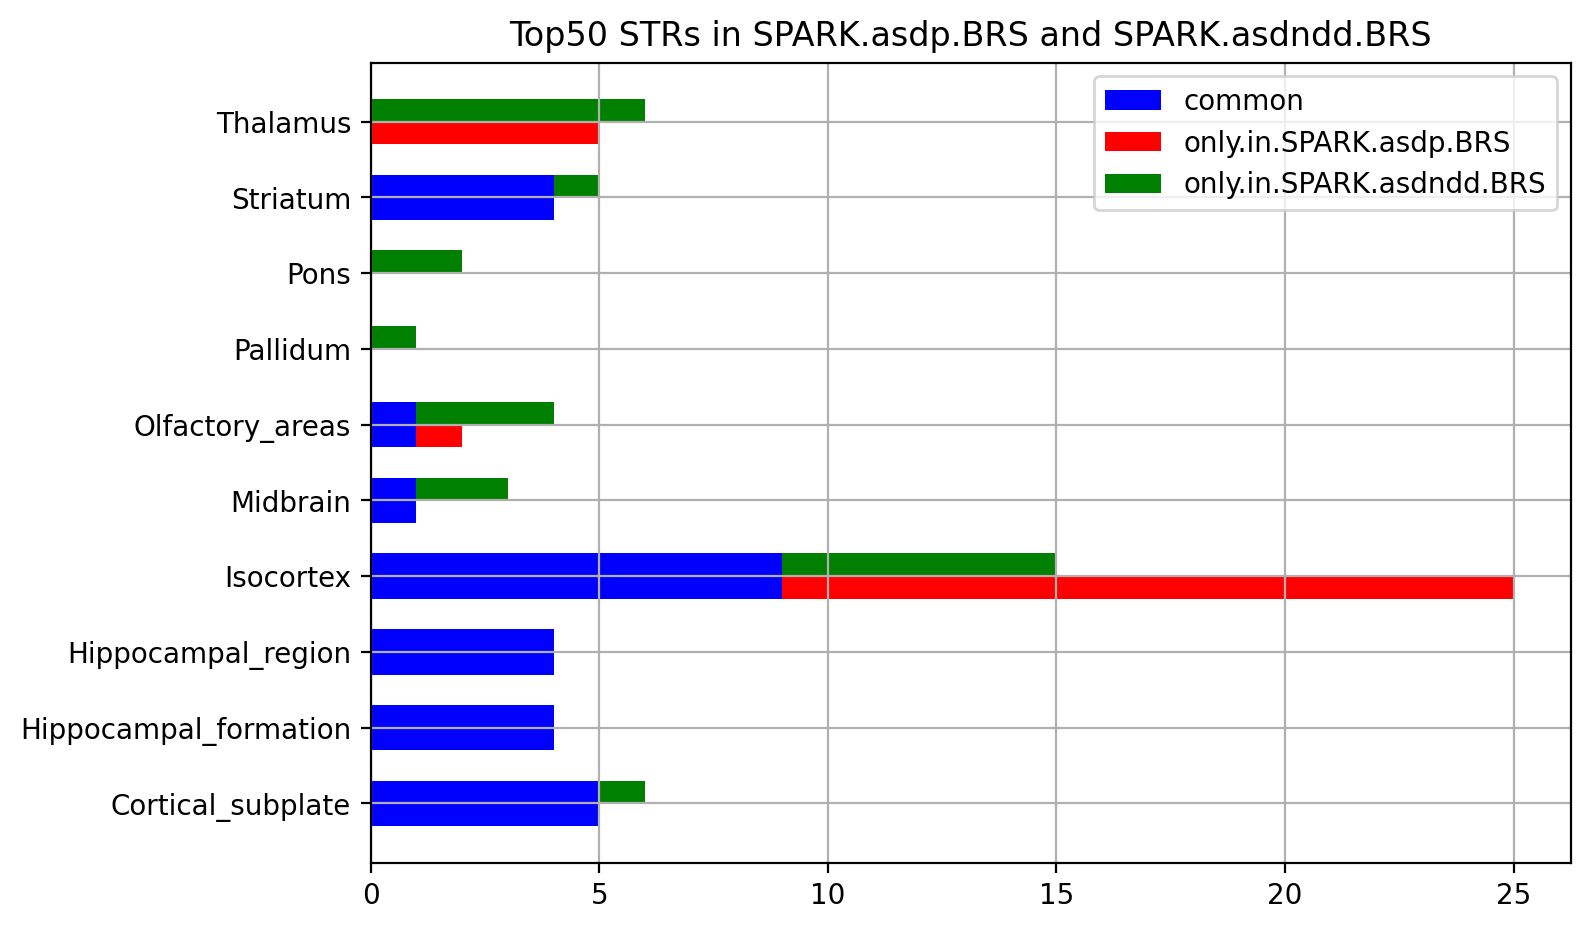

In [154]:
SPARK_BRS_compare = CompareSTROverlap(spark_asdp_avgZ_Mutcount, spark_asdndd_avgZ_Mutcount,
                                               "SPARK.asdp.BRS", "SPARK.asdndd.BRS")
SPARK_BRS_compare.to_csv("dat/SPARK_asdp_asdndd_BRS_STR_Overlap.csv", index=False)

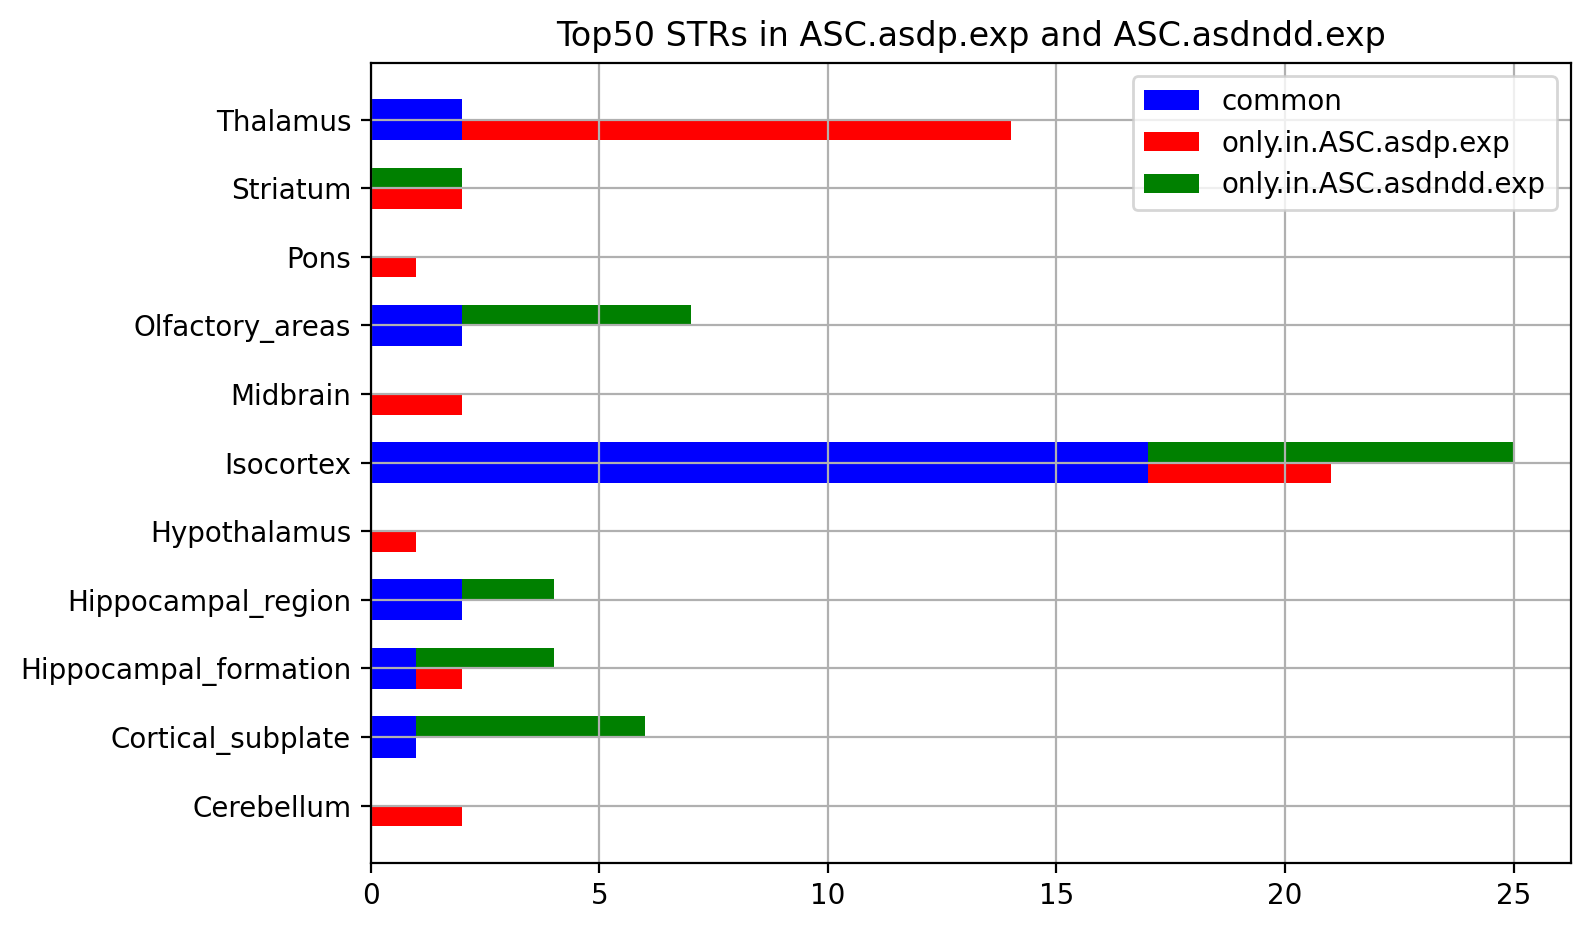

In [156]:
ASC_exp_compare = CompareSTROverlap(asc_asdp_explevel_Mutcount, asc_asdndd_explevel_Mutcount,
                                               "ASC.asdp.exp", "ASC.asdndd.exp")
ASC_exp_compare.to_csv("dat/ASC_asdp_asdndd_explevel_STR_Overlap.csv", index=False)

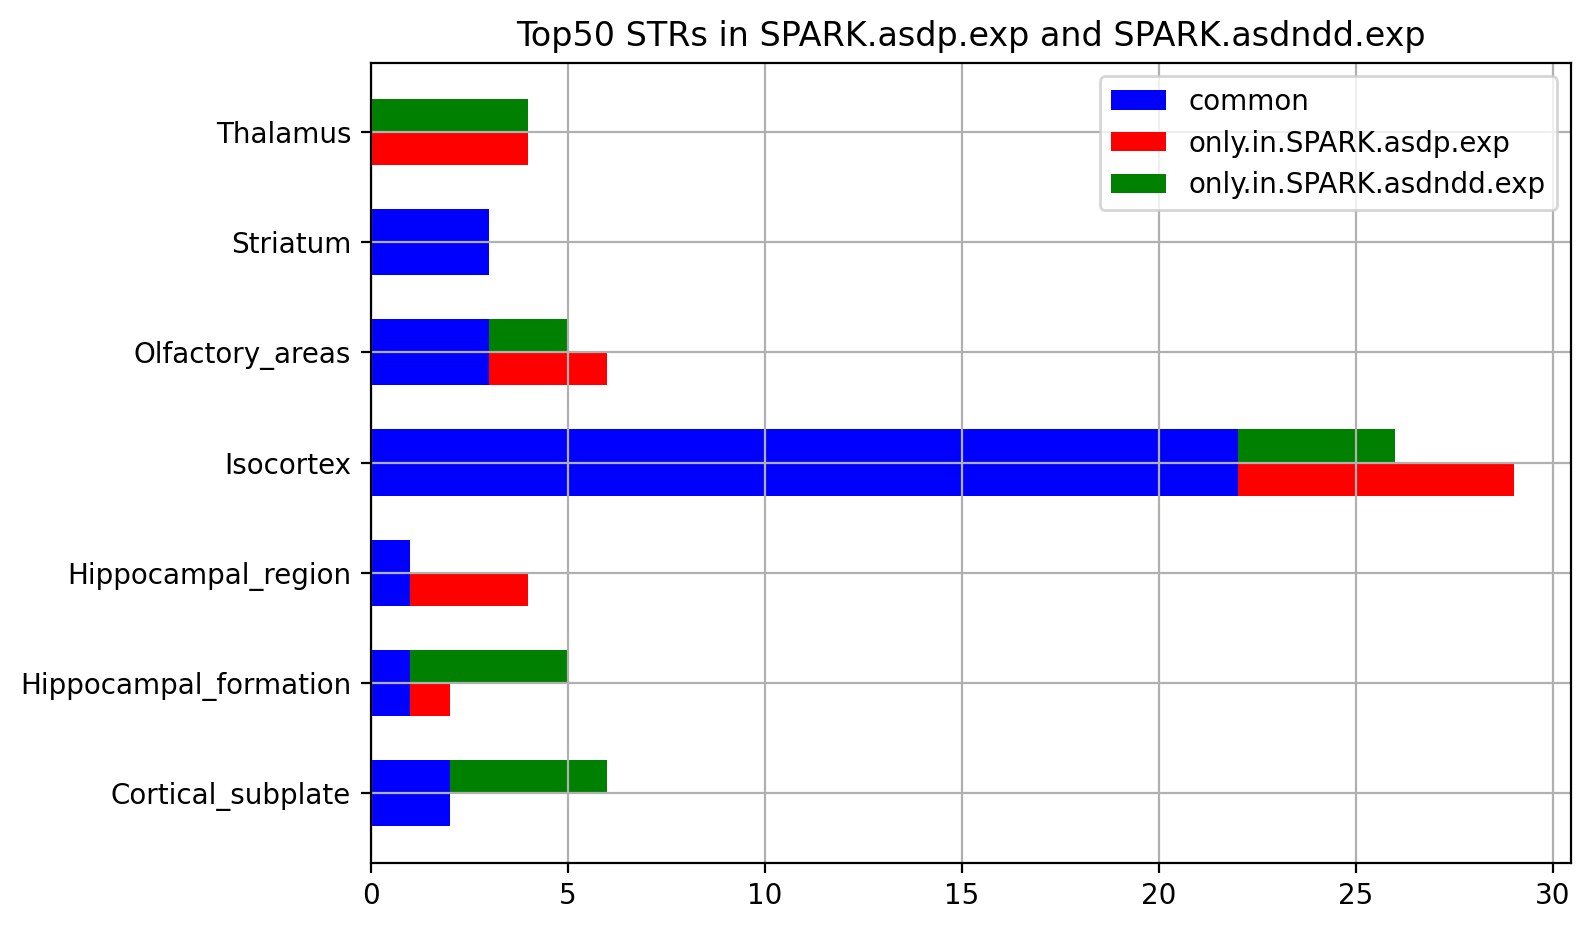

In [155]:
SPARK_BRS_compare = CompareSTROverlap(spark_asdp_explevel_Mutcount, spark_asdndd_explevel_Mutcount,
                                               "SPARK.asdp.exp", "SPARK.asdndd.exp")
SPARK_BRS_compare.to_csv("dat/SPARK_asdp_asdndd_explevel_STR_Overlap.csv", index=False)

In [132]:
ASC_SPARK_BRS_compare

,Region,STR.Common,STR.only.in.ASC.BRS,STR.only.in.SPARK.BRS,N.common,N.only.ASC.BRS,N.only.SPARK.BRS
0,Cortical_subplate,"Lateral_amygdalar_nucleus, Claustrum, Endopiri...",,Basolateral_amygdalar_nucleus,5,0,1
1,Hippocampal_formation,"Subiculum_dorsal_part, Subiculum_ventral_part,...",,Presubiculum,3,0,1
2,Hippocampal_region,"Dentate_gyrus, Field_CA2, Field_CA1, Field_CA3",,,4,0,0
3,Isocortex,"Primary_visual_area, posteromedial_visual_area...",,"Primary_somatosensory_area_upper_limb, Anterol...",18,0,8
4,Midbrain,Anterior_pretectal_nucleus,Nucleus_of_the_optic_tract,,1,1,0
5,Olfactory_areas,"Dorsal_peduncular_area, Anterior_olfactory_nuc...",,,3,0,0
6,Pallidum,,"Substantia_innominata, Bed_nuclei_of_the_stria...",,0,2,0
7,Striatum,"Intercalated_amygdalar_nucleus, Nucleus_accumb...",Lateral_septal_nucleus_caudal_caudodorsal_part...,Central_amygdalar_nucleus,3,3,1
8,Thalamus,"Lateral_posterior_nucleus_of_the_thalamus, Par...","Posterior_complex_of_the_thalamus, Lateral_dor...",,2,5,0


In [69]:
CompareList(spark_asdd_region["Thalamus"], spark_asdp_explevel_region["Thalamus"])

Common: 4 {'Lateral_dorsal_nucleus_of_thalamus', 'Lateral_posterior_nucleus_of_the_thalamus', 'Posterior_complex_of_the_thalamus', 'Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part'}
Present in 1: 1 {'Dorsal_part_of_the_lateral_geniculate_complex'}
Present in 2: 0 set()


In [39]:
CompareList(spark_asdd_region["Isocortex"], spark_asdndd_region["Isocortex"])

Common: 18 {'Prelimbic_area', 'Lateral_visual_area', 'Infralimbic_area', 'Secondary_motor_area', 'Gustatory_areas', 'Orbital_area_lateral_part', 'Temporal_association_areas', 'Anteromedial_visual_area', 'posteromedial_visual_area', 'Primary_motor_area', 'Anterior_cingulate_area_dorsal_part', 'Posterior_parietal_association_areas', 'Primary_visual_area', 'Posterolateral_visual_area', 'Orbital_area_ventrolateral_part', 'Orbital_area_medial_part', 'Frontal_pole_cerebral_cortex', 'Agranular_insular_area_ventral_part'}
Present in 1: 9 {'Primary_somatosensory_area_upper_limb', 'Dorsal_auditory_area', 'Primary_somatosensory_area_mouth', 'Perirhinal_area', 'Anterolateral_visual_area', 'Primary_somatosensory_area_trunk', 'Agranular_insular_area_dorsal_part', 'Primary_somatosensory_area_lower_limb', 'Primary_somatosensory_area_barrel_field'}
Present in 2: 5 {'Visceral_area', 'Supplemental_somatosensory_area', 'Retrosplenial_area_lateral_agranular_part', 'Anterior_cingulate_area_ventral_part', 'A

In [107]:
## Combine Resutlts
Fils = ["dat/bias/asc.avgZ.weighted.Mutcount.bias.csv", "dat/bias/asc.explevel.weighted.Mutcount.bias.csv", 
       "dat/bias/sparktada.avgZ.weighted.Mutcount.bias.csv", "dat/bias/sparktada.explevel.weighted.Mutcount.bias.csv"]
def CombineResults(Fils, Name=["ASC.BRS", "ASC.EXP", "SPARK.BRS", "SPARK.EXP"]):
    assert len(Fils) == len(Name)
    DFs = [pd.read_csv(Fil, index_col="STR") for Fil in Fils]
    Heads = []
    for N in Name:
        Heads.append(N+".top50")
        Heads.append(N+".incircuits")
    #
    UNION_STRs = []
    for DF in DFs:
        top50 = DF.head(50)
        UNION_STRs.extend(top50.index.values)
    UNION_STRs = list(set(UNION_STRs))
    print(len(UNION_STRs))
    dat = []
    for STR in UNION_STRs:
        Region = DFs[0].loc[STR, "REGION"]
        row = [Region, STR]
        for i, DF in enumerate(DFs):
            if STR in DF.head(50).index.values:
                row.append(1)
            else:
                row.append(0)
            if DF.loc[STR, "InCircuit"] == 1:
                row.append(1)
            else:
                row.append(0)
        dat.append(row)
    res_df = pd.DataFrame(data=dat, columns=["Region", "STR"]+Heads)
    for i, row in res_df.iterrows():
        #print(sum(row[Heads[1::2]]))
        intop50 = sum(row[Heads[0::2]])
        incircuit = sum(row[Heads[1::2]])
        Total = intop50 + incircuit
        res_df.loc[i, "TotalTop50"] = int(intop50)
        res_df.loc[i, "TotalInCircuit"] = int(incircuit)
        res_df.loc[i, "TotalAll"] = int(Total)
    return res_df

In [108]:
df = CombineResults(Fils)
print(df.shape)
df.head(5)

72
(72, 13)


,Region,STR,ASC.BRS.top50,ASC.BRS.incircuits,ASC.EXP.top50,ASC.EXP.incircuits,SPARK.BRS.top50,SPARK.BRS.incircuits,SPARK.EXP.top50,SPARK.EXP.incircuits,TotalTop50,TotalInCircuit,TotalAll
0,Isocortex,Primary_somatosensory_area_upper_limb,0,0,0,0,1,1,1,1,2.0,2.0,4.0
1,Striatum,Central_amygdalar_nucleus,0,0,0,0,1,0,0,0,1.0,0.0,1.0
2,Isocortex,Frontal_pole_cerebral_cortex,0,0,1,1,1,1,1,1,3.0,3.0,6.0
3,Isocortex,Prelimbic_area,1,1,1,1,1,1,1,1,4.0,4.0,8.0
4,Cortical_subplate,Claustrum,1,1,1,1,1,1,1,1,4.0,4.0,8.0


In [109]:
df.to_csv("dat/RegionBiasSummary.csv", index=False)

In [116]:
#spark_gene2None, spark_gene2MutN, spark_gene2LofZ, spark_gene2RR, spark_gene2MutNLofZ = SPARK_Gene_Weights(
#    "../dat/genes/asd/spark_tada_RR.csv", gnomad_cons, FDR=0.2)
#spark_gene2MutN =  SPARK_Gene_Weights(
    "../dat/genes/asd/spark_tada_RR.csv", gnomad_cons, FDR=0.2)
#print("Number of genes: %d"%len(spark_gene2RR))
#spark_gene2MutNGL = SPARK_MutCountByLength("../dat/genes/asd/spark_tada_RR.csv", 
                                           "/Users/jiayao/Work/ASD_Circuits/src/dat/match-features.csv", FDR=0.2)

27086
23126


In [111]:
spark_avgZ_MutN = AvgSTRZ_Weighted(ExpZscoreMat, spark_gene2MutN,
                                              csv_fil = "dat/bias/sparktada.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(spark_avgZ_MutN.set_index("STR"))

NameError: name 'spark_gene2MutN' is not defined

In [64]:
spark_avgZ_norm_MutN = AvgSTRZ_Weighted(ExpZscoreMatNorm, spark_gene2MutN,
                                              csv_fil = "dat/bias/sparktada.norm.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(spark_avgZ_norm_MutN.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_ventral_part; Subiculum_dorsal_part; Presubiculum; Parasubiculum
Cortical_subplate 	 6 	 Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus; Endopiriform_nucleus_ventral_part; Claustrum; Endopiriform_nucleus_dorsal_part; Posterior_amygdalar_nucleus
Olfactory_areas 	 4 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Taenia_tecta; Accessory_olfactory_bulb
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Isocortex 	 25 	 Prelimbic_area; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_visual_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Orbital_area_medial_part; Secondary_motor_area; Frontal_pole_cerebral_cortex; Anteromedial_visual_area; Posterolateral_visual_area; Anterior_cingulate_area_ventral_part; Retrosplenial_area_lateral_agranular_part; Primary_motor_area; posteromedial_visual_area; Primary_somatosensory_area_lower_limb; Agranular_insular_area_ventral_part; Anterolateral_

In [59]:
spark_explevel_MutN = ExpAVGWithExpMatch(ExpMat, spark_gene2MutN, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(spark_explevel_MutN.set_index("STR"))

Hippocampal_formation 	 5 	 Presubiculum; Subiculum_dorsal_part; Subiculum_ventral_part; Parasubiculum; Entorhinal_area_lateral_part
Cortical_subplate 	 6 	 Lateral_amygdalar_nucleus; Claustrum; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part; Basolateral_amygdalar_nucleus; Endopiriform_nucleus_ventral_part
Olfactory_areas 	 5 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Taenia_tecta; Accessory_olfactory_bulb; Main_olfactory_bulb
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Isocortex 	 25 	 Prelimbic_area; Orbital_area_ventrolateral_part; Primary_visual_area; Orbital_area_medial_part; Infralimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Frontal_pole_cerebral_cortex; Secondary_motor_area; Posterolateral_visual_area; Anteromedial_visual_area; Lateral_visual_area; posteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Anterior_cingulate_area_ventral_part; Anterolateral_visual_area; Temporal_asso

In [61]:
spark_explevel_norm_MutN = ExpAVGWithExpMatch(ExpMatNorm, spark_gene2MutN, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.nrom.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(spark_explevel_norm_MutN.set_index("STR"))

Hippocampal_formation 	 5 	 Presubiculum; Subiculum_ventral_part; Parasubiculum; Subiculum_dorsal_part; Entorhinal_area_lateral_part
Cortical_subplate 	 6 	 Basomedial_amygdalar_nucleus; Claustrum; Lateral_amygdalar_nucleus; Basolateral_amygdalar_nucleus; Endopiriform_nucleus_ventral_part; Endopiriform_nucleus_dorsal_part
Olfactory_areas 	 4 	 Dorsal_peduncular_area; Taenia_tecta; Anterior_olfactory_nucleus; Accessory_olfactory_bulb
Hippocampal_region 	 4 	 Field_CA1; Dentate_gyrus; Field_CA2; Field_CA3
Isocortex 	 26 	 Prelimbic_area; Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Orbital_area_medial_part; Posterolateral_visual_area; Frontal_pole_cerebral_cortex; Secondary_motor_area; posteromedial_visual_area; Anterior_cingulate_area_ventral_part; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Temporal_association_areas; Lateral_visual_area; Anterolateral_visual_area; Ectorh

In [33]:
spark_explevel_MutNGL = ExpAVGWithExpMatch(ExpMat, spark_gene2MutNGL, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.MutNGL.bias.csv")
RegionDistributions(spark_explevel_MutNGL.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_ventral_part; Parasubiculum; Subiculum_dorsal_part; Presubiculum
Cortical_subplate 	 5 	 Lateral_amygdalar_nucleus; Claustrum; Endopiriform_nucleus_dorsal_part; Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Olfactory_areas 	 5 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb; Piriform_area; Taenia_tecta
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Isocortex 	 29 	 Orbital_area_ventrolateral_part; Prelimbic_area; Infralimbic_area; Primary_visual_area; Orbital_area_lateral_part; Orbital_area_medial_part; Lateral_visual_area; Retrosplenial_area_lateral_agranular_part; Secondary_motor_area; Anterior_cingulate_area_dorsal_part; Anteromedial_visual_area; Posterolateral_visual_area; Primary_motor_area; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Anterolateral_visual_area; Primary_somatosensory_area_barrel_field; Primary_somatosensory_area_lower_limb; postero

In [37]:
spark_specificity_MutNGL = AvgSTRZ_Weighted(ExpZscoreMat, spark_gene2MutNGL, 
                                                         csv_fil="dat/bias/spark.avgZ.weighted.MutNGL.bias.csv")
RegionDistributions(spark_specificity_MutNGL.set_index("STR"))

Hippocampal_formation 	 4 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum; Presubiculum
Cortical_subplate 	 6 	 Basomedial_amygdalar_nucleus; Lateral_amygdalar_nucleus; Claustrum; Endopiriform_nucleus_dorsal_part; Endopiriform_nucleus_ventral_part; Basolateral_amygdalar_nucleus
Olfactory_areas 	 4 	 Piriform_area; Dorsal_peduncular_area; Anterior_olfactory_nucleus; Accessory_olfactory_bulb
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA3; Field_CA2
Thalamus 	 3 	 Parafascicular_nucleus; Lateral_posterior_nucleus_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus
Isocortex 	 23 	 Primary_visual_area; Prelimbic_area; Primary_motor_area; Secondary_motor_area; Primary_somatosensory_area_trunk; Infralimbic_area; Gustatory_areas; Posterior_parietal_association_areas; Agranular_insular_area_ventral_part; Orbital_area_ventrolateral_part; Primary_somatosensory_area_barrel_field; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Primary_somatosensor

In [60]:
spark_specificity_MutNTol = AvgSTRZ_Weighted(ExpZscoreMat, spark_gene2MutNLofZ, 
                                                         csv_fil="dat/bias/spark.avgZ.weighted.MutNLofZ.bias.csv")

In [61]:
RegionDistributions(spark_specificity_MutNTol.set_index("STR"))

Striatum 	 4 	 Caudoputamen; Intercalated_amygdalar_nucleus; Nucleus_accumbens; Central_amygdalar_nucleus
Thalamus 	 4 	 Lateral_posterior_nucleus_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus; Parafascicular_nucleus; Lateral_dorsal_nucleus_of_thalamus
Olfactory_areas 	 2 	 Piriform_area; Dorsal_peduncular_area
Isocortex 	 23 	 Primary_motor_area; Gustatory_areas; Agranular_insular_area_ventral_part; Posterior_parietal_association_areas; Primary_visual_area; Prelimbic_area; Primary_somatosensory_area_trunk; Secondary_motor_area; Primary_somatosensory_area_barrel_field; Orbital_area_lateral_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_mouth; Retrosplenial_area_lateral_agranular_part; Lateral_visual_area; Dorsal_auditory_area; Primary_somatosensory_area_nose; Supplemental_somatosensory_area; Anterior_cingulate_area_dorsal_part; Agranular_insular_area_dorsal_part

In [62]:
spark_explevel_RR = ExpAVGWithExpMatch(ExpMat, spark_gene2RR, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.RR.bias.csv")
RegionDistributions(spark_explevel_RR.set_index("STR"))

Striatum 	 1 	 Intercalated_amygdalar_nucleus
Thalamus 	 1 	 Lateral_posterior_nucleus_of_the_thalamus
Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area; Main_olfactory_bulb; Piriform_area
Isocortex 	 32 	 Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Primary_somatosensory_area_upper_limb; Orbital_area_lateral_part; Primary_somatosensory_area_trunk; Dorsal_auditory_area; Secondary_motor_area; Primary_somatosensory_area_barrel_field; Prelimbic_area; Primary_somatosensory_area_mouth; Posterior_parietal_association_areas; Posterolateral_visual_area; Retrosplenial_area_lateral_agranular_part; Orbital_area_medial_part; Primary_motor_area; Anterior_cingulate_area_dorsal_part; Retrosplenial_area_dorsal_part; posteromedial_visual_area; Primary_somatosensory_area_lower_limb; Lateral_visual_area; Primary_somatosensory_area_nose; Anterior_cingulate_area_ventral_part; Agranular_insular_area_dorsal_part; Agranular_insular_ar

In [63]:
spark_explevel_None = ExpAVGWithExpMatch(ExpMat, spark_gene2None, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.Uniform.bias.csv")
RegionDistributions(spark_explevel_None.set_index("STR"))

Striatum 	 1 	 Caudoputamen
Olfactory_areas 	 5 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb; Taenia_tecta; Main_olfactory_bulb
Isocortex 	 34 	 Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Prelimbic_area; Secondary_motor_area; Orbital_area_medial_part; Orbital_area_lateral_part; Primary_somatosensory_area_upper_limb; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_trunk; Posterolateral_visual_area; Anterior_cingulate_area_ventral_part; Posterior_parietal_association_areas; posteromedial_visual_area; Primary_somatosensory_area_barrel_field; Dorsal_auditory_area; Primary_motor_area; Retrosplenial_area_lateral_agranular_part; Primary_somatosensory_area_mouth; Primary_somatosensory_area_lower_limb; Retrosplenial_area_dorsal_part; Lateral_visual_area; Anteromedial_visual_area; Agranular_insular_area_dorsal_part; Frontal_pole_cerebral_cortex; Ventral_auditory_area; Anterolateral_visual_area; Primary_auditory_area; 

In [64]:
spark_explevel_MutN = ExpAVGWithExpMatch(ExpMat, spark_gene2MutN, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.Mutcount.bias.csv")
RegionDistributions(spark_explevel_MutN.set_index("STR"))

Striatum 	 5 	 Nucleus_accumbens; Caudoputamen; Intercalated_amygdalar_nucleus; Fundus_of_striatum; Lateral_septal_nucleus_caudal_caudodorsal_part
Olfactory_areas 	 5 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Taenia_tecta; Accessory_olfactory_bulb; Main_olfactory_bulb
Isocortex 	 25 	 Prelimbic_area; Orbital_area_ventrolateral_part; Primary_visual_area; Orbital_area_medial_part; Infralimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Frontal_pole_cerebral_cortex; Secondary_motor_area; Posterolateral_visual_area; Anteromedial_visual_area; Lateral_visual_area; posteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Anterior_cingulate_area_ventral_part; Anterolateral_visual_area; Temporal_association_areas; Primary_motor_area; Primary_somatosensory_area_lower_limb; Ectorhinal_area; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Primary_somatosensory_area_barrel_field; Dorsal_auditory_area; Primary_somatosensory_a

In [117]:
spark_avgZ_MutN = AvgSTRZ_Weighted(ExpZscoreMat, spark_gene2MutN,
                                              csv_fil = "dat/bias/sparktada.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(spark_avgZ_MutN.set_index("STR"))

Olfactory_areas 	 3 	 Dorsal_peduncular_area; Piriform_area; Anterior_olfactory_nucleus
Cortical_subplate 	 6 	 Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Claustrum; Endopiriform_nucleus_dorsal_part; Endopiriform_nucleus_ventral_part; Basolateral_amygdalar_nucleus
Striatum 	 4 	 Caudoputamen; Nucleus_accumbens; Intercalated_amygdalar_nucleus; Central_amygdalar_nucleus
Thalamus 	 2 	 Parafascicular_nucleus; Lateral_posterior_nucleus_of_the_thalamus
Hippocampal_formation 	 4 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum; Presubiculum
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA3; Field_CA2
Midbrain 	 1 	 Anterior_pretectal_nucleus
Isocortex 	 26 	 Prelimbic_area; Primary_visual_area; Primary_motor_area; Secondary_motor_area; Infralimbic_area; Anterior_cingulate_area_dorsal_part; Gustatory_areas; Posterior_parietal_association_areas; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Agranular_insular_area_ventral_part; Pr

{'Cerebellum': [],
 'Olfactory_areas': ['Dorsal_peduncular_area',
  'Piriform_area',
  'Anterior_olfactory_nucleus'],
 'Pallidum': [],
 'Cortical_subplate': ['Lateral_amygdalar_nucleus',
  'Basomedial_amygdalar_nucleus',
  'Claustrum',
  'Endopiriform_nucleus_dorsal_part',
  'Endopiriform_nucleus_ventral_part',
  'Basolateral_amygdalar_nucleus'],
 'Striatum': ['Caudoputamen',
  'Nucleus_accumbens',
  'Intercalated_amygdalar_nucleus',
  'Central_amygdalar_nucleus'],
 'Thalamus': ['Parafascicular_nucleus',
  'Lateral_posterior_nucleus_of_the_thalamus'],
 'Hippocampal_formation': ['Subiculum_ventral_part',
  'Subiculum_dorsal_part',
  'Parasubiculum',
  'Presubiculum'],
 'Medulla': [],
 'Pons': [],
 'Hippocampal_region': ['Dentate_gyrus',
  'Field_CA1',
  'Field_CA3',
  'Field_CA2'],
 'Midbrain': ['Anterior_pretectal_nucleus'],
 'Hypothalamus': [],
 'Isocortex': ['Prelimbic_area',
  'Primary_visual_area',
  'Primary_motor_area',
  'Secondary_motor_area',
  'Infralimbic_area',
  'Anterior_

In [43]:
spark_explevel_LofZ = ExpressionLevelWeightedBias(ExpMat, spark_gene2LofZ, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.explevel.weighted.LofZ.bias.csv")
RegionDistributions(spark_explevel_LofZ.set_index("STR"))

Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area; Main_olfactory_bulb; Taenia_tecta
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Hippocampal_formation 	 4 	 Presubiculum; Parasubiculum; Subiculum_dorsal_part; Subiculum_ventral_part
Striatum 	 2 	 Caudoputamen; Intercalated_amygdalar_nucleus
Cortical_subplate 	 2 	 Claustrum; Basomedial_amygdalar_nucleus
Isocortex 	 32 	 Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Orbital_area_lateral_part; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_trunk; Secondary_motor_area; Prelimbic_area; Dorsal_auditory_area; Orbital_area_medial_part; Primary_somatosensory_area_barrel_field; Posterior_parietal_association_areas; Primary_somatosensory_area_mouth; Posterolateral_visual_area; Primary_motor_area; Retrosplenial_area_lateral_agranular_part; Anterior_cingulate_area_dorsal_part; posteromedial_visual_area; Primary_somatosensory_ar

In [83]:
spark_Norm_explevel_LofZ = ExpressionLevelWeightedBias(ExpMatNorm, spark_gene2LofZ, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.norm.explevel.weighted.LofZ.bias.csv")

In [84]:
RegionDistributions(spark_Norm_explevel_LofZ.set_index("STR"))

Isocortex 	 30 	 Orbital_area_ventrolateral_part; Primary_visual_area; Infralimbic_area; Orbital_area_lateral_part; Prelimbic_area; Posterolateral_visual_area; Anterior_cingulate_area_dorsal_part; posteromedial_visual_area; Primary_somatosensory_area_trunk; Retrosplenial_area_lateral_agranular_part; Orbital_area_medial_part; Secondary_motor_area; Anterior_cingulate_area_ventral_part; Primary_somatosensory_area_upper_limb; Posterior_parietal_association_areas; Retrosplenial_area_dorsal_part; Primary_motor_area; Agranular_insular_area_dorsal_part; Primary_somatosensory_area_lower_limb; Agranular_insular_area_ventral_part; Primary_somatosensory_area_barrel_field; Anteromedial_visual_area; Gustatory_areas; Primary_somatosensory_area_mouth; Supplemental_somatosensory_area; Frontal_pole_cerebral_cortex; Lateral_visual_area; Primary_somatosensory_area_nose; Anterolateral_visual_area; Temporal_association_areas
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Olfactory_a

In [96]:
spark_avgZ_LofZ = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, spark_gene2LofZ, asd_sparktada_match_df,
                                              csv_fil = "dat/bias/sparktada.avgZ.weighted.LofZ.bias.csv")
RegionDistributions(spark_avgZ_LofZ.set_index("STR"))

Isocortex 	 24 	 Primary_motor_area; Primary_somatosensory_area_trunk; Secondary_motor_area; Primary_somatosensory_area_upper_limb; Primary_visual_area; Posterior_parietal_association_areas; Primary_somatosensory_area_mouth; Primary_somatosensory_area_barrel_field; Agranular_insular_area_ventral_part; Gustatory_areas; Primary_somatosensory_area_lower_limb; Dorsal_auditory_area; Infralimbic_area; Agranular_insular_area_dorsal_part; Orbital_area_ventrolateral_part; Anterior_cingulate_area_dorsal_part; Prelimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_ventral_part; Retrosplenial_area_lateral_agranular_part; Retrosplenial_area_dorsal_part; posteromedial_visual_area; Primary_somatosensory_area_nose; Lateral_visual_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA3; Field_CA2
Midbrain 	 4 	 Inferior_colliculus_central_nucleus; Nucleus_of_the_optic_tract; Superior_colliculus_motor_related; Anterior_pretectal_nucleus
Olfactory_areas 	 3 	 Piriform_area; Dorsal_p

In [95]:
asc_avgZ_Mutcount = ExpressionLevelWeightedBias(ExpZscoreMat, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_Mutcount.set_index("STR"))

Isocortex 	 18 	 Prelimbic_area; Infralimbic_area; Orbital_area_lateral_part; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Anterior_cingulate_area_dorsal_part; Primary_visual_area; Posterior_parietal_association_areas; Anterior_cingulate_area_ventral_part; Orbital_area_medial_part; Lateral_visual_area; Secondary_motor_area; Primary_motor_area; Visceral_area; Primary_somatosensory_area_trunk; posteromedial_visual_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Midbrain 	 1 	 Anterior_pretectal_nucleus
Olfactory_areas 	 3 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb
Striatum 	 6 	 Nucleus_accumbens; Lateral_septal_nucleus_ventral_part; Caudoputamen; Lateral_septal_nucleus_caudal_caudodorsal_part; Lateral_septal_nucleus_rostral_rostroventral_part; Intercalated_amygdalar_nucleus
Thalamus 	 10 	 Lateral_posterior_nucleus_of_the_thalam

In [ ]:
asc_avgZ_Mutcount = ExpressionLevelWeightedBias(ExpZscoreMat, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_Mutcount.set_index("STR"))

In [ ]:
asc_avgZ_Mutcount = ExpressionLevelWeightedBias(ExpZscoreMat, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_avgZ_Mutcount.set_index("STR"))

In [98]:
asc_norm_avgZ_Mutcount = ExpressionLevelWeightedBias(ExpZscoreMatNorm, asc_gene2MutN, asd_asc_match_df,
                                              csv_fil = "dat/bias/asc.norm.avgZ.weighted.Mutcount.bias.csv")
RegionDistributions(asc_norm_avgZ_Mutcount.set_index("STR"))

Isocortex 	 22 	 Infralimbic_area; Prelimbic_area; Orbital_area_lateral_part; Anteromedial_visual_area; Primary_somatosensory_area_lower_limb; Retrosplenial_area_lateral_agranular_part; Primary_visual_area; Orbital_area_ventrolateral_part; Posterior_parietal_association_areas; Anterior_cingulate_area_dorsal_part; Anterior_cingulate_area_ventral_part; Primary_motor_area; Orbital_area_medial_part; Primary_somatosensory_area_trunk; Secondary_motor_area; posteromedial_visual_area; Posterolateral_visual_area; Retrosplenial_area_dorsal_part; Lateral_visual_area; Agranular_insular_area_ventral_part; Visceral_area; Anterolateral_visual_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Midbrain 	 1 	 Anterior_pretectal_nucleus
Olfactory_areas 	 3 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory_olfactory_bulb
Striatum 	 5 	 Nucleus_accumbens; Lateral_septal_nucleus_ventral_part; Lateral_septal_nucleus_caudal_caudodorsal_part; Caudoputamen; Lateral_septa

#### ASC ALL MUT

In [101]:
# ASC ALL GENES Mutcount
### ASC 102 GENEs
asc_mutable = pd.read_excel("../dat/genes/1-s2.0-S0092867419313984-mmc2.xlsx", sheet_name="Autosomal")
#asc102 = asc_mutable[asc_mutable["qval_dnccPTV"]<0.1]
asc_gene2MutN = {} #2
for i, row in asc_mutable.iterrows():
    if row["dn.ptv"] == 0 and row["dn.misa"] == 0 and row["dn.misb"] == 0:
        continue
    asc_gene2MutN[row["entrez_id"]] = 0
    if row["dn.ptv"] > 0:
        asc_gene2MutN[row["entrez_id"]] += 10*row["dn.ptv"]
    if row["dn.misa"] > 0:
        asc_gene2MutN[row["entrez_id"]] += 1*row["dn.misa"]
    if row["dn.misb"] > 0:
        asc_gene2MutN[row["entrez_id"]] += 5*row["dn.misb"]

In [103]:
asc_all_mut_bias = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, asc_gene2MutN, csv_fil="dat/bias/asc.allmut.csv")

In [104]:
RegionDistributions(asc_all_mut_bias.set_index("STR"))

Isocortex 	 25 	 Prelimbic_area; Secondary_motor_area; Primary_visual_area; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Primary_motor_area; Posterior_parietal_association_areas; Infralimbic_area; Frontal_pole_cerebral_cortex; posteromedial_visual_area; Orbital_area_lateral_part; Retrosplenial_area_lateral_agranular_part; Orbital_area_ventrolateral_part; Anterior_cingulate_area_ventral_part; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_trunk; Orbital_area_medial_part; Gustatory_areas; Retrosplenial_area_dorsal_part; Lateral_visual_area; Visceral_area; Supplemental_somatosensory_area; Agranular_insular_area_ventral_part; Primary_somatosensory_area_mouth
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Midbrain 	 2 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract
Olfactory_areas 	 4 	 Dorsal_peduncular_area; Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Piriform_area
Stria

#### SPARK ALL MUT

In [105]:
spark_gene2MutN = {} #2
for i, row in spark_tada.iterrows():
    try:
        gene = int(GeneSymbol2Entrez[row["HGNC"]])
    except:
        continue # Can't map gene ID
    #asc_gene2RR[gene] = []
    if row["dnLGD"] == 0 and row["dnDmis"] == 0:
        continue
    spark_gene2MutN[gene] = 0
    if row["dnLGD"] > 0:
        spark_gene2MutN[gene] += 5*row["dnLGD"]
    if row["dnDmis"] > 0:
        spark_gene2MutN[gene] += 1*row["dnDmis"]

In [107]:
spark_all_mut_bias = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, spark_gene2MutN, csv_fil="dat/bias/spark.allmut.csv")
RegionDistributions(spark_all_mut_bias.set_index("STR"))

Isocortex 	 22 	 Primary_motor_area; Prelimbic_area; Infralimbic_area; Secondary_motor_area; Orbital_area_ventrolateral_part; Frontal_pole_cerebral_cortex; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Orbital_area_medial_part; Retrosplenial_area_lateral_agranular_part; Primary_somatosensory_area_upper_limb; Primary_visual_area; Orbital_area_lateral_part; Posterior_parietal_association_areas; Agranular_insular_area_ventral_part; Anterior_cingulate_area_ventral_part; Primary_somatosensory_area_trunk; Posterolateral_visual_area; Dorsal_auditory_area; posteromedial_visual_area; Anteromedial_visual_area; Gustatory_areas
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA3; Field_CA2
Midbrain 	 3 	 Anterior_pretectal_nucleus; Nucleus_of_the_posterior_commissure; Nucleus_of_the_optic_tract
Olfactory_areas 	 5 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Accessory_olfactory_bulb; Taenia_tecta; Piriform_area
Striatum 	 4 	 Nucleus_accumbens; Caudo

#### SSC ALL MUT; Seperated by Male/Female and High/Low Functioning Male

In [111]:
ssc_mutable = pd.read_excel("../dat/genes/Supplementary_Table_7.xlsx", sheet_name="ggg_clean")
ssc_gene2MutN = {} #2
ssc_gene2MutN_M = {}
ssc_gene2MutN_FM = {}
ssc_gene2MutN_H = {}
ssc_gene2MutN_L = {}
for i, row in ssc_mutable.iterrows():
    try:
        gene = int(GeneSymbol2Entrez[row["gene"]])
    except:
        continue # Can't map gene ID
    if row["dnv_LGDs_prb"] == 0 and row["dnv_missense_prb"] == 0:
        continue
    ssc_gene2MutN[gene] = 0
    ssc_gene2MutN_M[gene] = 0
    ssc_gene2MutN_FM[gene] = 0
    ssc_gene2MutN_H[gene] = 0
    ssc_gene2MutN_L[gene] = 0
    
    ssc_gene2MutN[gene] += 10*row["dnv_LGDs_prb"]
    ssc_gene2MutN_M[gene] += 10*row["dnv_LGDs_prbM"]
    ssc_gene2MutN_FM[gene] += 10*row["dnv_LGDs_prbF"]
    ssc_gene2MutN_H[gene] += 10*row["dnv_LGDs_prbMH"]
    ssc_gene2MutN_L[gene] += 10*row["dnv_LGDs_prbML"]
    
    ssc_gene2MutN[gene] += 1*row["dnv_missense_prb"]
    ssc_gene2MutN_M[gene] += 1*row["dnv_missense_prbM"]
    ssc_gene2MutN_FM[gene] += 1*row["dnv_missense_prbF"]
    ssc_gene2MutN_H[gene] += 1*row["dnv_missense_prbMH"]
    ssc_gene2MutN_L[gene] += 1*row["dnv_missense_prbML"]

In [110]:
ssc_all_mut_bias = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_gene2MutN, csv_fil="dat/bias/ssc.allmut.csv")
RegionDistributions(ssc_all_mut_bias.set_index("STR"))

Isocortex 	 17 	 Prelimbic_area; Orbital_area_lateral_part; Infralimbic_area; Orbital_area_ventrolateral_part; Anterior_cingulate_area_ventral_part; Primary_somatosensory_area_lower_limb; Frontal_pole_cerebral_cortex; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_upper_limb; Visceral_area; Secondary_motor_area; Orbital_area_medial_part; Supplemental_somatosensory_area; Primary_motor_area; Primary_somatosensory_area_mouth; Primary_somatosensory_area_barrel_field; Gustatory_areas
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Midbrain 	 4 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Nucleus_of_the_posterior_commissure; Superior_colliculus_motor_related
Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area; Main_olfactory_bulb
Striatum 	 4 	 Caudoputamen; Nucleus_accumbens; Lateral_septal_nucleus_caudal_caudodorsal_part; Lateral_septal_nucleus_rostral_rostroventral_part
Thalamus 	 14 	 Lat

In [112]:
ssc_all_mut_bias_M = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_gene2MutN_M, 
                                                    csv_fil="dat/bias/ssc.M.allmut.csv")
RegionDistributions(ssc_all_mut_bias_M.set_index("STR"))

Isocortex 	 19 	 Prelimbic_area; Infralimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Orbital_area_medial_part; Anterior_cingulate_area_ventral_part; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_upper_limb; Primary_motor_area; Primary_somatosensory_area_mouth; Frontal_pole_cerebral_cortex; Primary_somatosensory_area_barrel_field; Primary_somatosensory_area_trunk; Posterior_parietal_association_areas; Primary_visual_area; Secondary_motor_area; Anteromedial_visual_area; Supplemental_somatosensory_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA2; Field_CA1; Field_CA3
Midbrain 	 5 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Nucleus_of_the_posterior_commissure; Superior_colliculus_motor_related; Inferior_colliculus_central_nucleus
Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Main_olfactory_bulb; Dorsal_peduncular_area
Striatum 	 4 	 Caudoputamen; Nucleus_accu

In [115]:
ssc_all_mut_bias_FM = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_gene2MutN_FM, 
                                                    csv_fil="dat/bias/ssc.F.allmut.csv")
RegionDistributions(ssc_all_mut_bias_FM.set_index("STR"))

Isocortex 	 11 	 Orbital_area_lateral_part; Visceral_area; Frontal_pole_cerebral_cortex; Agranular_insular_area_posterior_part; Anterior_cingulate_area_ventral_part; Orbital_area_ventrolateral_part; Anterior_cingulate_area_dorsal_part; Supplemental_somatosensory_area; Primary_somatosensory_area_upper_limb; Secondary_motor_area; Prelimbic_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Midbrain 	 2 	 Anterior_pretectal_nucleus; Cuneiform_nucleus
Olfactory_areas 	 3 	 Piriform_area; Anterior_olfactory_nucleus; Piriform_amygdalar_area
Striatum 	 5 	 Lateral_septal_nucleus_caudal_caudodorsal_part; Caudoputamen; Septofimbrial_nucleus; Nucleus_accumbens; Lateral_septal_nucleus_rostral_rostroventral_part
Thalamus 	 19 	 Lateral_posterior_nucleus_of_the_thalamus; Dorsal_part_of_the_lateral_geniculate_complex; Lateral_dorsal_nucleus_of_thalamus; Ventral_anterior_lateral_complex_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus; Ventral_posterolateral_nucleus_

In [116]:
ssc_all_mut_bias_H = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_gene2MutN_H, 
                                                    csv_fil="dat/bias/ssc.H.allmut.csv")
RegionDistributions(ssc_all_mut_bias_H.set_index("STR"))

Isocortex 	 4 	 Primary_somatosensory_area_barrel_field; Frontal_pole_cerebral_cortex; Primary_somatosensory_area_mouth; Primary_somatosensory_area_nose
Hippocampal_region 	 4 	 Field_CA2; Dentate_gyrus; Field_CA1; Field_CA3
Midbrain 	 5 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Cuneiform_nucleus; Nucleus_of_the_posterior_commissure; Superior_colliculus_motor_related
Olfactory_areas 	 4 	 Main_olfactory_bulb; Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Piriform_amygdalar_area
Striatum 	 2 	 Septofimbrial_nucleus; Caudoputamen
Medulla 	 4 	 Parvicellular_reticular_nucleus; Intermediate_reticular_nucleus; Nucleus_of_the_solitary_tract; Medullary_reticular_nucleus_dorsal_part
Pons 	 2 	 Superior_central_nucleus_raphe; Parabrachial_nucleus
Thalamus 	 15 	 Lateral_posterior_nucleus_of_the_thalamus; Medial_habenula; Lateral_habenula; Paraventricular_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Mediodorsal_nucleus_of_thalamus; Anteroventral_nucleus_of

In [117]:
ssc_all_mut_bias_L = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_gene2MutN_L, 
                                                    csv_fil="dat/bias/ssc.L.allmut.csv")
RegionDistributions(ssc_all_mut_bias_L.set_index("STR"))

Isocortex 	 21 	 Infralimbic_area; Prelimbic_area; Anterior_cingulate_area_ventral_part; Orbital_area_medial_part; Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Primary_motor_area; Primary_somatosensory_area_lower_limb; Secondary_motor_area; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_upper_limb; Agranular_insular_area_dorsal_part; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Primary_visual_area; Agranular_insular_area_ventral_part; Retrosplenial_area_lateral_agranular_part; Supplemental_somatosensory_area; Retrosplenial_area_dorsal_part; Primary_somatosensory_area_mouth
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA3; Field_CA1; Field_CA2
Midbrain 	 5 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Superior_colliculus_motor_related; Nucleus_of_the_posterior_commissure; Inferior_colliculus_central_nucleus
Olfactory_areas 	 3 	 Accessory_olfactory_bulb; Dorsal_peduncular_area; Anterior_olf

In [123]:
ssc_mutable.head(2)

,gene,codingLen,codingLenInTarget,set_FMRPTargets,set_PSD,set_Embryonic,set_ChromatinModifiers,set_EssentialGenes,set_MendelianDiseaseGenes,set_DeNovoLGDsInSchizoprenia,...,dnv_missense_prbML,dnv_missense_prbMH,dnv_missense_prbF,dnv_missense_sib,dnv_synonymous_prb,dnv_synonymous_prbM,dnv_synonymous_prbML,dnv_synonymous_prbMH,dnv_synonymous_prbF,dnv_synonymous_sib
0,CHD8,7752,7752,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DYRK1A,2376,2376,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
# Sibling 
#ssc_mutable = pd.read_excel("../dat/genes/Supplementary_Table_7.xlsx", sheet_name="ggg_clean")
sib_gene2MutN = {} #2
sib_gene2None = {}
for i, row in ssc_mutable.iterrows():
    try:
        gene = int(GeneSymbol2Entrez[row["gene"]])
    except:
        continue # Can't map gene ID
    if row["dnv_LGDs_sib"] == 0 and row["dnv_missense_sib"] == 0:
        continue
    sib_gene2None[gene] = 1
    sib_gene2MutN[gene] = 0
    sib_gene2MutN[gene] += 10*row["dnv_LGDs_sib"]
    sib_gene2MutN[gene] += 1*row["dnv_missense_sib"]

In [129]:
sib_all_mut_bias = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, sib_gene2MutN, 
                                                    csv_fil="dat/bias/sib.allmut.csv")
sib_all_mut_bias_None = Weighted_ZscoreAVGWithExpMatch(ExpZscoreMat, sib_gene2None, 
                                                    csv_fil="dat/bias/sib.allmut.NoWeight.csv")
RegionDistributions(sib_all_mut_bias.set_index("STR"))

Isocortex 	 5 	 Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_mouth; Primary_visual_area; Primary_somatosensory_area_trunk; posteromedial_visual_area
Hippocampal_region 	 2 	 Field_CA3; Field_CA1
Midbrain 	 4 	 Anterior_pretectal_nucleus; Inferior_colliculus_external_nucleus; Midbrain_reticular_nucleus; Nucleus_of_the_optic_tract
Striatum 	 2 	 Caudoputamen; Fundus_of_striatum
Medulla 	 3 	 Spinal_nucleus_of_the_trigeminal_oral_part; Spinal_nucleus_of_the_trigeminal_interpolar_part; Spinal_nucleus_of_the_trigeminal_caudal_part
Pons 	 2 	 Principal_sensory_nucleus_of_the_trigeminal; Nucleus_of_the_lateral_lemniscus
Thalamus 	 27 	 Ventral_posterolateral_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Dorsal_part_of_the_lateral_geniculate_complex; Ventral_posteromedial_nucleus_of_the_thalamus; Lateral_posterior_nucleus_of_the_thalamus; Posterior_limiting_nucleus_of_the_thalamus; Posterior_complex_of_the_thalamus; Ventral_anterior_lateral_complex_of_the_th

In [ ]:
# seperate all probands by IQ

In [130]:
RegionDistributions(sib_all_mut_bias_None.set_index("STR"))

Isocortex 	 7 	 Retrosplenial_area_ventral_part; Primary_visual_area; posteromedial_visual_area; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_trunk; Posterolateral_visual_area; Primary_somatosensory_area_mouth
Hippocampal_region 	 4 	 Field_CA3; Dentate_gyrus; Field_CA1; Field_CA2
Midbrain 	 5 	 Anterior_pretectal_nucleus; Nucleus_of_the_posterior_commissure; Dorsal_nucleus_raphe; Nucleus_of_the_optic_tract; Midbrain_reticular_nucleus
Striatum 	 2 	 Lateral_septal_nucleus_rostral_rostroventral_part; Caudoputamen
Pons 	 1 	 Superior_central_nucleus_raphe
Thalamus 	 24 	 Lateral_habenula; Lateral_dorsal_nucleus_of_thalamus; Medial_geniculate_complex_medial_part; Mediodorsal_nucleus_of_thalamus; Lateral_posterior_nucleus_of_the_thalamus; Dorsal_part_of_the_lateral_geniculate_complex; Parafascicular_nucleus; Parataenial_nucleus; Ventral_posterolateral_nucleus_of_the_thalamus; Paraventricular_nucleus_of_the_thalamus; Rhomboid_nucleus; Ventral_posteromedial_nucleus_of_th

In [71]:
asc_mut = pd.read_csv("../dat/genes/asc_tada_RR.csv")
spark_mut = pd.read_csv("../dat/genes/spark_tada_RR.csv")

In [72]:
asc_mut.head(2)

,gene,hugoGene,hgnc_id,entrez_id,ensembl_gene_id,refseq_accession,uniprot_ids,location,chr,start_hg38,...,ASC65_2015,ASC102_2018,ASD:DDID,ASD_vs_DDID,ASD53,DDID49,Function,LGD_RR,misa_RR,misb_RR
0,CHD8,CHD8,HGNC:20153,57680,ENSG00000100888,NM_020920,Q9HCK8,14q11.2,chr14,21385194,...,1,1,3.07850705163288,ASD,1,0,Gene expression regulation,60.711380,12.347005,15.270008
1,SCN2A,SCN2A,HGNC:10588,6326,ENSG00000136531,NM_021007,Q99250,2q24.3,chr2,165194993,...,1,1,0.6913147929608191,DDID,0,1,Neuronal communication,80.483746,6.916012,36.717196


In [76]:
asc_mut["entrez_id"]

0         57680
1          6326
2          8831
3         23394
4         27086
          ...  
17479     57688
17480    125150
17481      9183
17482     55055
17483     79699
Name: entrez_id, Length: 17484, dtype: object

In [77]:
## Corr of RR in common genes between ASC/SPARK
asc_rr = []
spark_rr = []
asc_rr1 = []
spark_rr1 = []
asc_rr2 = []
spark_rr2 = []
for gene in asc_gene2RR.keys():
    if gene in spark_gene2RR.keys():
        asc_rr.append(asc_gene2RR[gene])
        spark_rr.append(spark_gene2RR[gene])
        #if asc_mut.loc[gene, "dn.ptv"] > 3 and spark_mut.loc[gene, "dnLGD"] > 3:
        print(gene, asc_mut[asc_mut["entrez_id"]==gene]["dn.ptv"])
        if asc_mut[asc_mut["entrez_id"]==gene]["dn.ptv"].values[0] > 3 and spark_mut[spark_mut["Entrez"]==gene]["dnLGD"].values[0] > 3:
            asc_rr1.append(asc_gene2RR[gene])
            spark_rr1.append(spark_gene2RR[gene])
        else:
            asc_rr2.append(asc_gene2RR[gene])
            spark_rr2.append(spark_gene2RR[gene])

57680 Series([], Name: dn.ptv, dtype: int64)


IndexError: index 0 is out of bounds for axis 0 with size 0

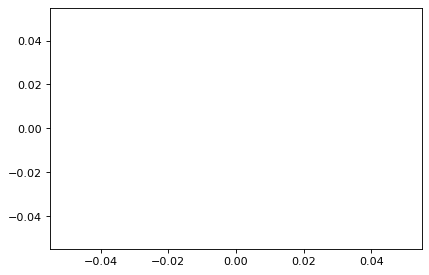

1


ValueError: x and y must have length at least 2.

In [63]:
plt.scatter(asc_rr1, spark_rr1, color="green")
plt.scatter(asc_rr2, spark_rr2, color='red')
plt.show()
print(len(asc_rr))
pearsonr(asc_rr, spark_rr)

In [ ]:
1 0.1

In [ ]:
x + y = 

In [ ]:
1.05 0.05